# Import libraries

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#Author: Sanjay Kottapalli, Dana Pe'er lab (kottapas@mskcc.org)

import numpy as np
import numpy.matlib
import pandas as pd
import scanpy as sc
from scanpy.external.pp import magic
import scipy
from sklearn.metrics import adjusted_rand_score
from scipy.stats.mstats import zscore
from scipy.stats import pearsonr
import csv
import os
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from copy import deepcopy
import timeit
from joblib import Parallel, delayed
from collections import Counter
np.random.seed(0)

# Define functions

In [4]:
def import_seqc_data(sample_name, path, dense=True):
    print('\nsample: ' + sample_name)
    if dense:
        PATH_TO_COUNT_CSV = path + sample_name + '_dense.csv'
        # import csv
        raw_counts = pd.read_csv(PATH_TO_COUNT_CSV, index_col=0, header=0)
        print(raw_counts.shape)
        #
        with open(PATH_TO_COUNT_CSV, "r") as f:
            reader = csv.reader(f)
            original_column_names = next(reader)
        # remove the first entry of this list, it belongs to the index column
        gene_names = original_column_names[1:]
        # and label the index column with name 'cell_barcodes'
        raw_counts.index.name = 'cell_barcodes'
        # convert indices to strings instead of integers for compatibility with scanpy
        raw_counts.index = raw_counts.index.astype(str)
        # python automatically converts duplicate column names to numbered column names,
        # e.g. 'X', 'X.1', 'X.2' etc. We can import the original column names from our CSV file:

        # now transpose the dataframe (for compatibility with panda's groupby function), 
        # then group by gene names, and add up the counts for genes with the same name
        raw_counts_transposed = raw_counts.T
        raw_counts_transposed_clean = raw_counts_transposed.groupby(gene_names, axis='index', sort=False).agg('sum')
        # transpose back
        raw_counts_clean = raw_counts_transposed_clean.T
        # if columns were added up, print how many:
        number_of_columns_removed = raw_counts.shape[1] - raw_counts_clean.shape[1]
        if number_of_columns_removed > 0:
            print(str(number_of_columns_removed) + ' columns were each merged with another column that had the same gene name.')
        # remove CLUSTER column:
        if 'CLUSTER' in raw_counts_clean.columns:
            raw_counts_clean.drop(columns='CLUSTER', inplace=True)
        # convert index type to string for compatibility with scanpy
        raw_counts_clean.index = raw_counts_clean.index.astype('str')
        adata = sc.AnnData(X = raw_counts_clean)
    else:
        barcodes = pd.read_csv(path+sample_name+'_sparse_counts_barcodes.csv', index_col=0, header=None)
        barcodes = barcodes[1].values
        barcodes = [str(i) for i in barcodes]
        gene_names = pd.read_csv(path+sample_name+'_sparse_counts_genes.csv', index_col=0, header=None)
        gene_names = gene_names[1].values
        sparse_counts = scipy.io.mmread(path+sample_name+'_sparse_molecule_counts.mtx').tocsc()
        #print("# of bytes: "+str(sparse_counts.data.nbytes))
        print(sparse_counts.shape)
        #sparse_counts = sparse_counts.toarray()#np.array(sparse_counts)
        #print(sparse_counts.shape)
        #raw_counts = pd.DataFrame.sparse.from_spmatrix(data=sparse_counts, index=barcodes, columns=gene_names)
        
        gene_dup = pd.Series(dict(Counter(gene_names)))
        gene_dup = gene_dup[gene_dup>1]
        #print(gene_dup)
        #print(len(set(gene_names)))
        gene_dup = list(gene_dup.keys())
        number_of_columns_removed = len(gene_dup)
        
        # sum of duplicate columns for each duplicate gene
        sum_dict = {i:sparse_counts[:,np.where(gene_names==i)[0]].sum(axis=1) for i in gene_dup}
        dup_index = []
        for i in gene_dup:
            dup_index += list(np.where(gene_names==i)[0])
        #print(sum_dict)
        #print(len(dup_index))
        #for i in sum_dict:
        #    print(sum_dict[i].sum(axis=0))
        
        #print(len(gene_names), sparse_counts.shape)
        keep_index = list(set(range(len(gene_names))) - set(dup_index))
        new_genes = list(gene_names[keep_index])
        new_counts = sparse_counts[:, keep_index]
        #print(len(new_genes), new_counts.shape)
        #print(new_counts.shape, type(new_counts))
        for i in sum_dict.keys():
            #print(sum_dict[i])
            #print(type(new_counts), type(sum_dict[i]))
            new_counts = scipy.sparse.hstack([new_counts, sum_dict[i]])
            new_genes.append(i)
        #print(len(new_genes), new_counts.shape)
        new_counts = new_counts.tocsc()
        print(new_counts.shape)#, type(new_counts))
        
        adata = sc.AnnData(X = new_counts, obs=pd.DataFrame(index=barcodes), var=pd.DataFrame(index=new_genes))
        
        if number_of_columns_removed > 0:
            print(str(number_of_columns_removed) + ' columns were each merged with another column that had the same gene name.')
       # take the min libsize in the dense cells, and 
        
        adata, mito_genes, RB_genes_in_data = qc_metrics(adata)
        # remove high mito frac cells
        cutoff = 20.0
        mito_val = adata.obs['pct_counts_mito']
        #print(mito_val)
        via_cells = mito_val[mito_val<cutoff]
        #print(via_cells)
        adata = adata[via_cells.index, :]
        print(adata.shape)
        
        PATH_TO_COUNT_CSV = path + sample_name + '_dense.csv'
        raw_counts = pd.read_csv(PATH_TO_COUNT_CSV, index_col=0, header=0)
        seqc_cells = [str(i) for i in raw_counts.index]
        libsize = adata.obs['original_total_counts'].sort_values(ascending=False)
        #pd.Series(index=adata.obs.index, data=np.array(np.sum(adata.X, axis=1).flatten())[0], dtype=str).sort_values(ascending=False)
        
        #difference = set(seqc_cells)-set([str(i) for i in libsize.iloc[:len(seqc_cells)+15000].index])
        #print(len(seqc_cells),len(difference))
        #print(seqc_cells[:20])
        #print(libsize.iloc[:20])
        
        adata = adata[libsize.iloc[:len(seqc_cells)+15000].index, :] # all dense cells + 15,000
        adata = sc.AnnData(X = adata.X, obs=pd.DataFrame(index=adata.obs.index), var=pd.DataFrame(index=adata.var.index))
        print(adata.shape)
        print("Cells filtered.")
    
    return adata

In [5]:
def qc_metrics(adata, path_RB=''):
    mito_genes = adata.var_names.str.startswith('MT-')
    adata.var['mito'] = mito_genes
    mito_genes = np.array(adata.var.index)[mito_genes]
    
    path_RB = path_RB+'RB_genes_human'
    with open(path_RB,'r') as file:
        lines = file.readlines()
    RB_genes = [x.rstrip('\n') for x in lines]
    data_genes = list(adata.var.index)
    RB_genes_in_data = set(data_genes).intersection(RB_genes)
    RB_genes_in_data = list(RB_genes_in_data)
    
    adata.var['ribo'] = False
    adata.var.loc[RB_genes_in_data, 'ribo'] = True
    
    sc.pp.calculate_qc_metrics(adata, qc_vars=('mito', 'ribo'), inplace=True)
    adata.obs['original_total_counts'] = adata.obs['total_counts']
    adata.obs['log10_original_total_counts'] = np.log10(adata.obs['original_total_counts'])
    print('QC metrics calculated.')
    
    return adata, mito_genes, RB_genes_in_data

In [6]:
def norm_filter(adata, mito_genes, RB_genes_in_data, log=True, remove_ribo=True, remove_mito=True, highly_var=False, markers=[]):
    
    adata.layers['raw_counts'] = adata.X
    # filter genes expressed in few cells
    print(adata.shape)
    sc.pp.filter_genes(adata, min_cells = 10)
    print(adata.shape)
    
    # libsize normalize
    if type(adata.X)==np.ndarray:
        med_libsize = np.median(np.sum(adata.X, axis=1))
    else:
        sums = np.array(np.sum(adata.X, axis=1).flatten())[0]
        #med_libsize = np.median(sums)
        if min(sums) == 0:
            empty_cells = set(np.where(sums==0)[0])
            print('# of 0-count droplets: '+str(len(empty_cells)))
            all_cells = set(adata.obs.index)
            keep_cells = all_cells-empty_cells
            adata = adata[keep_cells, :]
            sums = np.array(np.sum(adata.X, axis=1).flatten())[0]
        med_libsize = np.median(sums)

        print('Median library size: ' + str(med_libsize))

    sc.pp.normalize_total(adata)

    # log transform
    if log:
        adata.X = np.log2(adata.X+0.1) - np.log2(0.1)

        for i in deepcopy(markers):
            try:
                adata.obs[i+'_exp'] = adata[:,i].X
            except:
                markers.remove(i)
                print(i)

    else:
        for i in deepcopy(markers):
            try:
                adata.obs[i+'_exp'] = np.log2(adata[:,i].X+0.1)
            except:
                markers.remove(i)
                print(i)

    # remove ribosomal genes
    if remove_ribo:
        RB_genes_in_data.append('MALAT1')
        adata = adata[:,[x not in RB_genes_in_data for x in adata.var.index]]
        print(adata.shape)

    # remove mitochondrial genes
    if remove_mito:
        adata = adata[:,[x not in mito_genes for x in adata.var.index]]
        print(adata.shape)

    # highly variable gene selection
    print(highly_var)
    if highly_var:
        if not log:
            print('Im here1')
            sc.pp.highly_variable_genes(adata, layer='raw_counts', flavor='seurat_v3',max_mean=np.inf, n_top_genes=2000)#, batch_key='Sample ID')
            print(sum(adata.var['highly_variable']))
            adata.var.loc[markers, 'highly_variable'] = True
            print(sum(adata.var['highly_variable']))
            print(adata.shape)
        elif log:
            print('Im here2')
            sc.pp.highly_variable_genes(adata, layer=None, flavor='cell_ranger', max_mean=np.inf, n_top_genes=2000)#, batch_key='Sample ID')
            print(sum(adata.var['highly_variable']))
            adata.var.loc[markers, 'highly_variable'] = True
            print(sum(adata.var['highly_variable']))

    return adata, markers#adata_unlog, markers

In [7]:
def plot_pca(adata):
    #print("I am in here 1")
    
    print(adata.X)
    try:
        print(adata.shape)
        N = 1000
        adata_new = sc.tl.pca(adata, n_comps=N, copy = True)
    except:
        print(adata.shape) 
        N = min(adata.shape) - 1
        adata_new = sc.tl.pca(adata, n_comps=N, copy = True)
    
    #Plot variance explained
    x = range(len(adata_new.uns['pca']['variance_ratio']))
    y = adata_new.uns['pca']['variance_ratio']
    plt.scatter(x,y,s=4)
    plt.xlabel('PC')
    plt.ylabel('Fraction of variance explained')
    plt.title('Fraction of variance explained per PC')
    plt.show()
    
    #Plot cumulative variance
    cml_var_explained = np.cumsum(adata_new.uns['pca']['variance_ratio'])
    x = range(len(adata_new.uns['pca']['variance_ratio']))
    y = cml_var_explained
    plt.scatter(x,y,s=4)
    plt.xlabel('PC')
    plt.ylabel('Cumulative fraction of variance explained')
    plt.title('Cumulative fraction of variance explained by PCs')
    plt.show()
    
    return cml_var_explained, adata_new.uns['pca']['variance_ratio']
    
def kneepoint(vec):
    #print("I am in here 4")
    curve =  [1-x for x in vec]
    nPoints = len(curve)
    allCoord = np.vstack((range(nPoints), curve)).T
    np.array([range(nPoints), curve])
    firstPoint = allCoord[0]
    lineVec = allCoord[-1] - allCoord[0]
    lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
    vecFromFirst = allCoord - firstPoint
    scalarProduct = np.sum(vecFromFirst * numpy.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
    vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
    vecToLine = vecFromFirst - vecFromFirstParallel
    distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
    idxOfBestPoint = np.argmax(distToLine)
    
    return idxOfBestPoint
    
def run_pca_knee(adata):
    cml, var = plot_pca(adata)

    knee = kneepoint(var)
    
    print("Knee point: "+str(knee))
    print("Explained variance: " + str(cml[knee]))

    x=list(range(len(cml)))
    plt.plot(x[:5*knee],cml[:5*knee])
    plt.show()

    adata_new = sc.tl.pca(adata, n_comps=knee+1, copy=True)
    sc.pl.pca_loadings(adata_new, components=range(1,4))
    
    return adata_new

In [8]:
def files_MAST(adata, cell_type = '', outdir = ''):
    
    # if directory doesn't exist, create it
    if not os.path.exists('DEA/' + cell_type):
        os.makedirs('DEA/' + cell_type)
    
    adata_celltype = deepcopy(adata)
    #adata_celltype = adata_celltype[adata_celltype.obs['final_subclusters'].isin([cell_type]),:]
    print(cell_type + '\t'+"Dimensions" + "\t"+ "{}".format(adata_celltype.shape))
    
    # make a dataframe for the expression matrix
    expmat = pd.DataFrame(adata_celltype.X, columns = adata_celltype.var.index, index = adata_celltype.obs.index)

    # make a dataframe for the observation data
    cdata = pd.DataFrame(adata_celltype.obs, columns=adata_celltype.obs.columns, index = adata_celltype.obs.index)

    
    expmat.to_csv(r'DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv', index=True)
    cdata.to_csv(r'DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv', index=True)
    
    print("Files written for {}".format(cell_type))

In [9]:
def run_MAST_for_celltype(adata, cell_type):
    start_time = timeit.default_timer()
    MAST = './runMAST.R'
    
    # run 
    files_MAST(adata = adata, cell_type = cell_type)
    
    expmat_Inputfile = ('DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv')
    cdata_Inputfile = ('DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv')
    output_file_cort = 'DEA/' +  cell_type + "/MAST_DEA_" + cell_type + "_cort.csv" 
    output_file_bs = 'DEA/' +  cell_type + "/MAST_DEA_" + cell_type + "_bs.csv" 
    
    print("Running " + MAST + " " + expmat_Inputfile + " " + cdata_Inputfile + " " + output_file_cort + " " + output_file_bs)
    
    os.system(MAST + " " + expmat_Inputfile + " " + cdata_Inputfile + " " + output_file_cort + " " + output_file_bs)
    out_str = "Finished running MAST on"+ "( " + cell_type +  ")" +" in {} seconds.".format(timeit.default_timer()-start_time)
    
    return out_str

In [10]:
godsnot_64 = [
    # "#000000",  # remove the black, as often, we have black colored annotation
    "#d9d929", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
    "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
    "#5A0007", "#809693", "#6A3A4C", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
    "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
    "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
    "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
    "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
    "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
    "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
    "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
    "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
    "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
    "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72"]

# Populate input parameters

In [11]:
# populate from command line
samples = ['1819_C1029_Ctrl_ES_Cort_IGO_10837_23', '1820_C1029_Ctrl_ES_BS_IGO_10856_3', '1821_996_VE_ES_Cort_IGO_10875_6', '1822_996_VE_ES_BS_IGO_10875_7']
indir = '../input/'
outdir = '../output_Nov/'
figures = '../figures/'

In [11]:
adata_final_high_var = sc.read_h5ad(outdir+'adata_final_high_var_final_clusters_updated.h5ad')

In [12]:
adata_final_high_var.shape

(23060, 18947)

# Astrocyte subset

In [13]:
adata_astro = deepcopy(adata_final_high_var)
adata_astro = adata_astro[adata_astro.obs['final_subclusters'].isin(['Astrocytes']),:]
adata_astro.shape

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(1628, 18947)

In [14]:
broad_clusters = adata_astro.obs['Condition']
unique_clusters = np.unique(broad_clusters.values)
samples = adata_astro.obs['Sample ID']
print('Cell counts in each cluster for each sample: ')

for cluster in unique_clusters:
    print('Cluster: '+str(cluster))
    index = broad_clusters[broad_clusters==cluster].index
    count = Counter(samples[index].values)
    print(count)

Cell counts in each cluster for each sample: 
Cluster: Control
Counter({'1820_C1029_Ctrl_ES_BS_IGO_10856_3': 489, '1819_C1029_Ctrl_ES_Cort_IGO_10837_23': 275})
Cluster: VE
Counter({'1822_996_VE_ES_BS_IGO_10875_7': 550, '1821_996_VE_ES_Cort_IGO_10875_6': 314})


In [15]:
path_to_h5ad_file = outdir+'adata.h5ad'
adata = sc.read_h5ad(path_to_h5ad_file)
print(adata)
# Add a new column describing the sample condition
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1819_C1029_Ctrl_ES_Cort_IGO_10837_23', "Control", "NA")
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1820_C1029_Ctrl_ES_BS_IGO_10856_3', "Control", adata.obs['Condition'])
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1821_996_VE_ES_Cort_IGO_10875_6', "VE", adata.obs['Condition'])
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1822_996_VE_ES_BS_IGO_10875_7', "VE", adata.obs['Condition'])


adata.obs.head()

AnnData object with n_obs × n_vars = 26101 × 22292
    obs: 'Sample ID'


Sample ID  \
cell_barcodes                                                                              
120703436570020_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
120703455227244_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
120703455251884_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
120703455704877_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
120718441244516_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   

                                                   Condition  
cell_barcodes                                                 
120703436570020_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control  
120703455227244_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control  
120703455251884_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control  
120703455704877_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control  
120718441244516_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control

In [16]:
# Add a new column describing the sample condition
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1819_C1029_Ctrl_ES_Cort_IGO_10837_23', "Cortex", "NA")
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1820_C1029_Ctrl_ES_BS_IGO_10856_3', "BrainStem", adata.obs['B_region'])
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1821_996_VE_ES_Cort_IGO_10875_6', "Cortex", adata.obs['B_region'])
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1822_996_VE_ES_BS_IGO_10875_7', "BrainStem", adata.obs['B_region'])


#adata.obs
# count the number of NAs
sum(pd.isna(adata.obs['B_region']))

0

In [17]:
adata_astro = adata[adata_astro.obs.index, :]
adata_astro.shape

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(1628, 22292)

## QC

In [18]:
adata_astro, mito_genes, RB_genes_in_data = qc_metrics(adata_astro)
markers = []
if type(adata_astro.X)==np.ndarray:
    pass
else:
    print(type(adata_astro.X))
    #print(adata_norm.X.shape)
    adata_astro.X = adata_astro.X.toarray()
    #print(adata_norm.X.shape)
adata_astro.X = pd.DataFrame(data=adata_astro.X).fillna(0).values

Trying to set attribute `.var` of view, copying.


QC metrics calculated.
<class 'scipy.sparse.csr.csr_matrix'>


In [19]:
adata_astro.shape

(1628, 22292)

## Normalization

In [20]:
markers = []
adata_astro, markers = norm_filter(adata_astro, mito_genes, RB_genes_in_data, markers=[], highly_var=True)
adata_astro.obs.head()

(1628, 22292)


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(1628, 12540)
(1628, 12365)
(1628, 12353)
True
Im here2


Trying to set attribute `.uns` of view, copying.


2000
2000


Sample ID  \
cell_barcodes                                                                              
126913543847340_1822_996_VE_ES_BS_IGO_10875_7              1822_996_VE_ES_BS_IGO_10875_7   
200991407794422_1822_996_VE_ES_BS_IGO_10875_7              1822_996_VE_ES_BS_IGO_10875_7   
235678490352371_1819_C1029_Ctrl_ES_Cort_IGO_108...  1819_C1029_Ctrl_ES_Cort_IGO_10837_23   
134515755210549_1822_996_VE_ES_BS_IGO_10875_7              1822_996_VE_ES_BS_IGO_10875_7   
201106029439222_1820_C1029_Ctrl_ES_BS_IGO_10856_3      1820_C1029_Ctrl_ES_BS_IGO_10856_3   

                                                   Condition   B_region  \
cell_barcodes                                                             
126913543847340_1822_996_VE_ES_BS_IGO_10875_7             VE  BrainStem   
200991407794422_1822_996_VE_ES_BS_IGO_10875_7             VE  BrainStem   
235678490352371_1819_C1029_Ctrl_ES_Cort_IGO_108...   Control     Cortex   
134515755210549_1822_996_VE_ES_BS_IGO_10875_7             VE  BrainStem   
201106029439222_1820_C1029_Ctrl_ES_BS_IGO_10856_3    Control  BrainStem   

                                                    n_genes_by_counts  \
cell_barcodes                                                           
126913543847340_1822_996_VE_ES_BS_IGO_10875_7                    1520   
200991407794422_1822_996_VE_ES_BS_IGO_10875_7                    1416   
235678490352371_1819_C1029_Ctrl_ES_Cort_IGO_108...               1141   
134515755210549_1822_996_VE_ES_BS_IGO_10875_7                    1226   
201106029439222_1820_C1029_Ctrl_ES_BS_IGO_10856_3                1716   

                                                    log1p_n_genes_by_counts  \
cell_barcodes                                                                 
126913543847340_1822_996_VE_ES_BS_IGO_10875_7                      7.327123   
200991407794422_1822_996_VE_ES_BS_IGO_10875_7                      7.256297   
235678490352371_1819_C1029_Ctrl_ES_Cort_IGO_108...                 7.040536   
134515755210549_1822_996_VE_ES_BS_IGO_10875_7                      7.112327   
201106029439222_1820_C1029_Ctrl_ES_BS_IGO_10856_3                  7.448334   

                                                    total_counts  \
cell_barcodes                                                      
126913543847340_1822_996_VE_ES_BS_IGO_10875_7             2673.0   
200991407794422_1822_996_VE_ES_BS_IGO_10875_7             2370.0   
235678490352371_1819_C1029_Ctrl_ES_Cort_IGO_108...        1900.0   
134515755210549_1822_996_VE_ES_BS_IGO_10875_7             2032.0   
201106029439222_1820_C1029_Ctrl_ES_BS_IGO_10856_3         3413.0   

                                                    log1p_total_counts  \
cell_barcodes                                                            
126913543847340_1822_996_VE_ES_BS_IGO_10875_7                 7.891331   
200991407794422_1822_996_VE_ES_BS_IGO_10875_7                 7.771067   
235678490352371_1819_C1029_Ctrl_ES_Cort_IGO_108...            7.550135   
134515755210549_1822_996_VE_ES_BS_IGO_10875_7                 7.617268   
201106029439222_1820_C1029_Ctrl_ES_BS_IGO_10856_3             8.135640   

                                                    pct_counts_in_top_50_genes  \
cell_barcodes                                                                    
126913543847340_1822_996_VE_ES_BS_IGO_10875_7                        23.718668   
200991407794422_1822_996_VE_ES_BS_IGO_10875_7                        23.206751   
235678490352371_1819_C1029_Ctrl_ES_Cort_IGO_108...                   23.105263   
134515755210549_1822_996_VE_ES_BS_IGO_10875_7                        23.917323   
201106029439222_1820_C1029_Ctrl_ES_BS_IGO_10856_3                    25.080574   

                                                    pct_counts_in_top_100_genes  \
cell_barcodes                                                                     
126913543847340_1822_996_VE_ES_BS_IGO_10875_7                         31.911710   
200991407794422_1822_9

## PCA

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(1628, 12353)


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


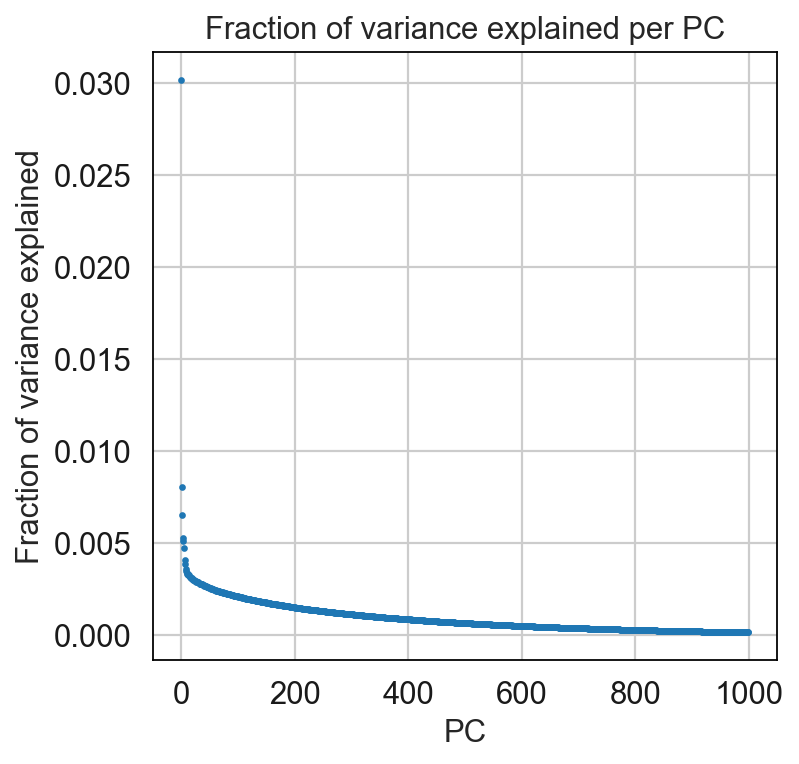

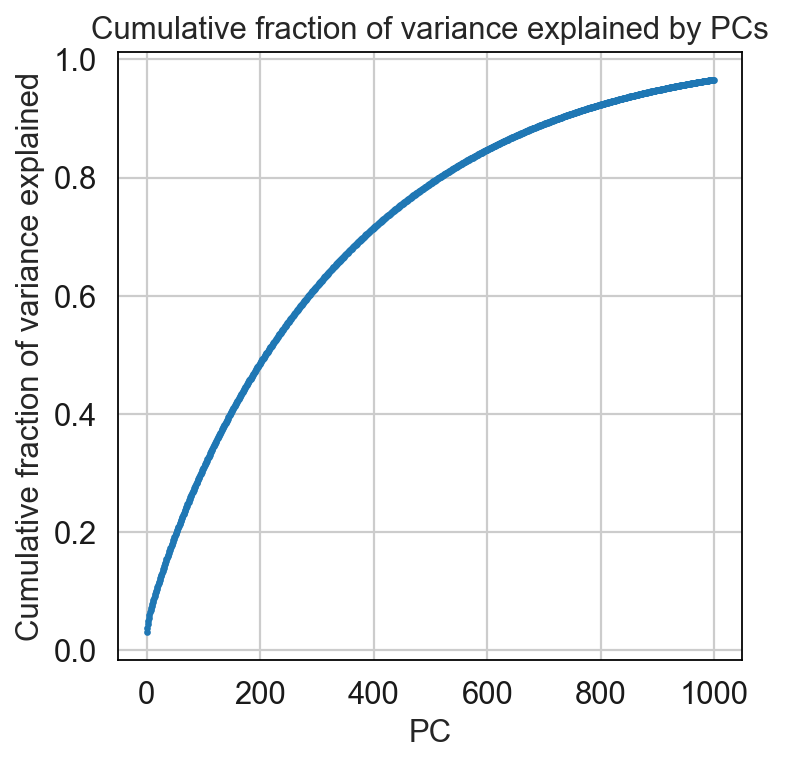

Knee point: 15
Explained variance: 0.09464926


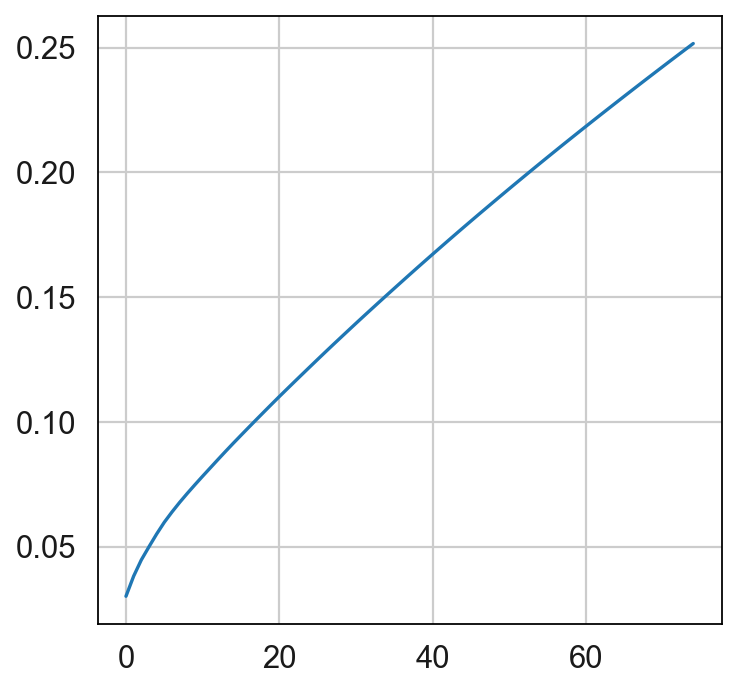

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0, flags=flags)


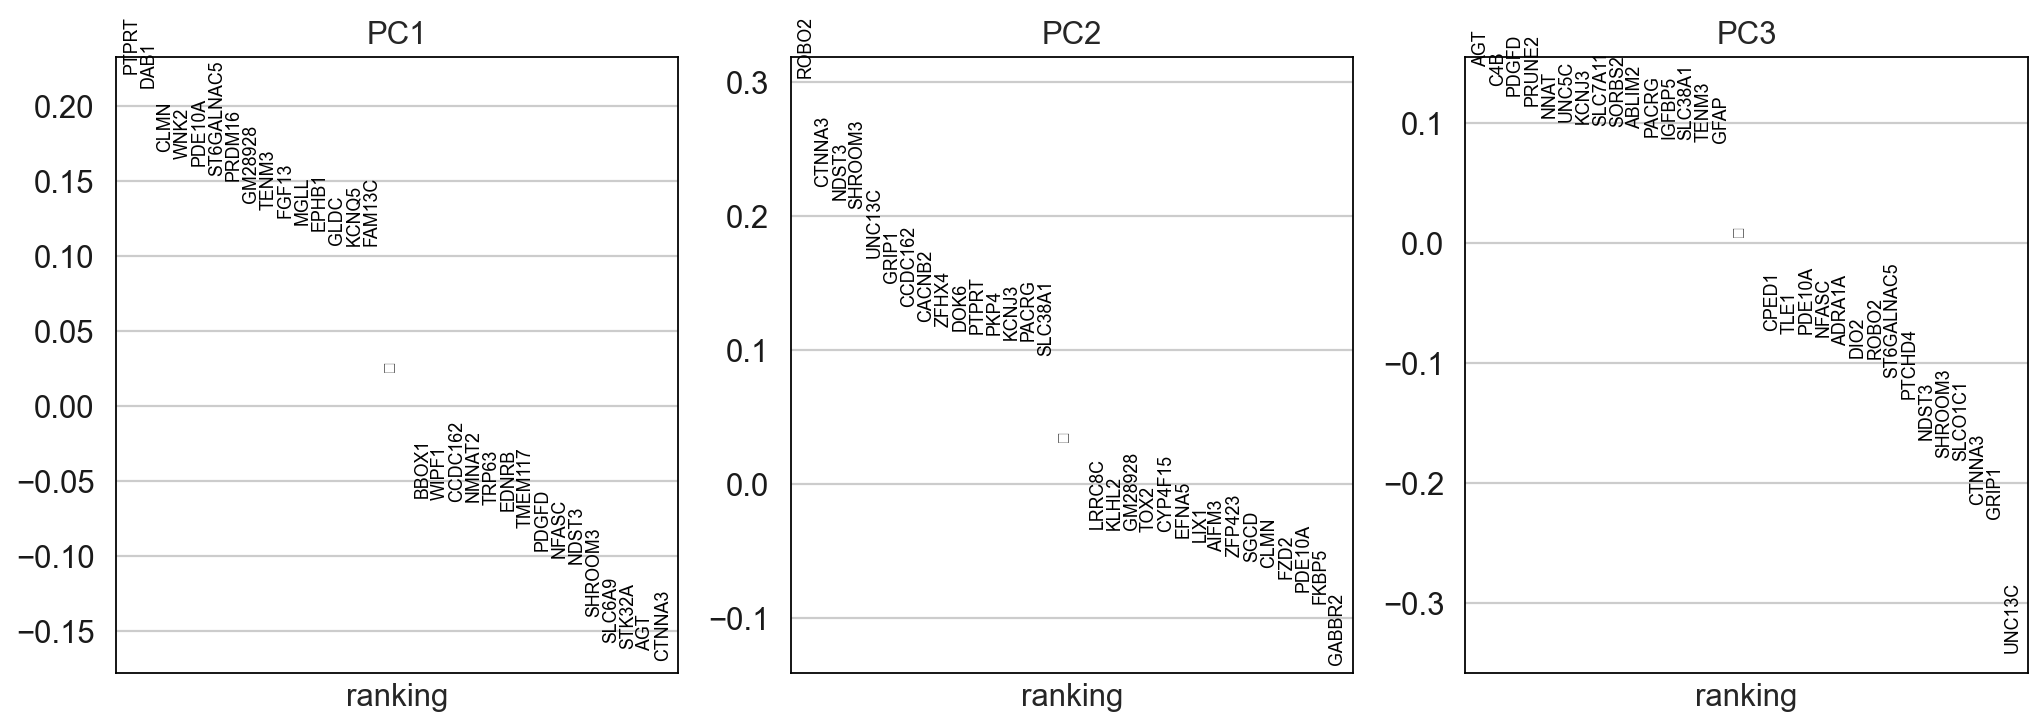

(1628, 12353)


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [21]:
sc.set_figure_params(figsize=(5, 5))
adata_astro = run_pca_knee(adata_astro)#, 0.5)
adata_astro.obs['PC 1'] = adata_astro.obsm['X_pca'][:,0] # optional
adata_astro.obs['PC 2'] = adata_astro.obsm['X_pca'][:,1]
adata_astro.obs['PC 3'] = adata_astro.obsm['X_pca'][:,2]

print(adata_astro.shape)
adata_astro.X = pd.DataFrame(adata_astro.X).fillna(0).values
index_list = np.arange(adata_astro.shape[0])
np.random.shuffle(index_list)
adata_astro = adata_astro[index_list,:]

In [22]:
print(adata_astro.shape)
adata_astro.X = pd.DataFrame(adata_astro.X).fillna(0).values
index_list = np.arange(adata_astro.shape[0])
np.random.shuffle(index_list)
adata_astro = adata_astro[index_list,:]

(1628, 12353)


## Phenograph

Finding 10 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.08170819282531738 seconds
Jaccard graph constructed in 1.6704151630401611 seconds
Wrote graph to binary file in 0.022313833236694336 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.742551
After 6 runs, maximum modularity is Q = 0.743769
After 7 runs, maximum modularity is Q = 0.744937
After 15 runs, maximum modularity is Q = 0.745984
Louvain completed 35 runs in 0.8764400482177734 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 3.2950549125671387 seconds


Trying to set attribute `.obs` of view, copying.


Finding 15 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.040495872497558594 seconds
Jaccard graph constructed in 0.8122310638427734 seconds
Wrote graph to binary file in 0.14718294143676758 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.706321
Louvain completed 21 runs in 0.5361459255218506 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 2.1724581718444824 seconds
Finding 20 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.04127788543701172 seconds
Jaccard graph constructed in 0.8310191631317139 seconds
Wrote graph to binary file in 0.04880070686340332 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.672176
After 2 runs, maximum modularity is Q = 0.680132
Louvain completed 22 runs in 0.6324043273925781 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 2.1816530227661133 seco

Text(0.5, 0, 'k')

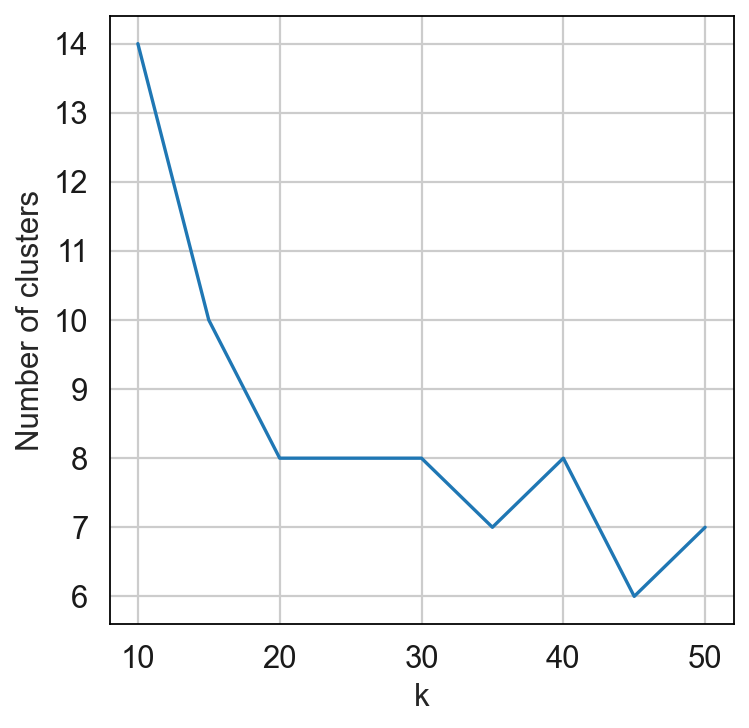

In [23]:
k_list = list(range(10, 55, 5))
n_clusters = []
for k in k_list:
    communities, graph, Q = sc.external.tl.phenograph(pd.DataFrame(adata_astro.obsm['X_pca']),k=k)
    n_clusters.append(len(np.unique(communities)))
    adata_astro.obs['PhenoGraph_clusters_astro'+str(k)] = pd.Categorical(communities)
    adata_astro.uns['PhenoGraph_Q_'+str(k)] = Q
    adata_astro.uns['PhenoGraph_k_'+str(k)] = k
plt.plot(k_list,n_clusters)
plt.ylabel("Number of clusters")
plt.xlabel("k")

In [24]:
Rand_index_df = pd.DataFrame(np.zeros((len(k_list), len(k_list))),index=k_list,columns=k_list)
Rand_index_df.index.name='k1'
Rand_index_df.columns.name='k2'
row_ind = 0
for run1 in range(len(k_list)):
    col_ind = 0
    for run2 in range(len(k_list)):
        Rand_index_df.iloc[row_ind,col_ind] = adjusted_rand_score(
            adata_astro.obs['PhenoGraph_clusters_astro'+str(k_list[run1])].values,
            adata_astro.obs['PhenoGraph_clusters_astro'+str(k_list[run2])].values)
        col_ind = col_ind+1
    row_ind = row_ind+1
    

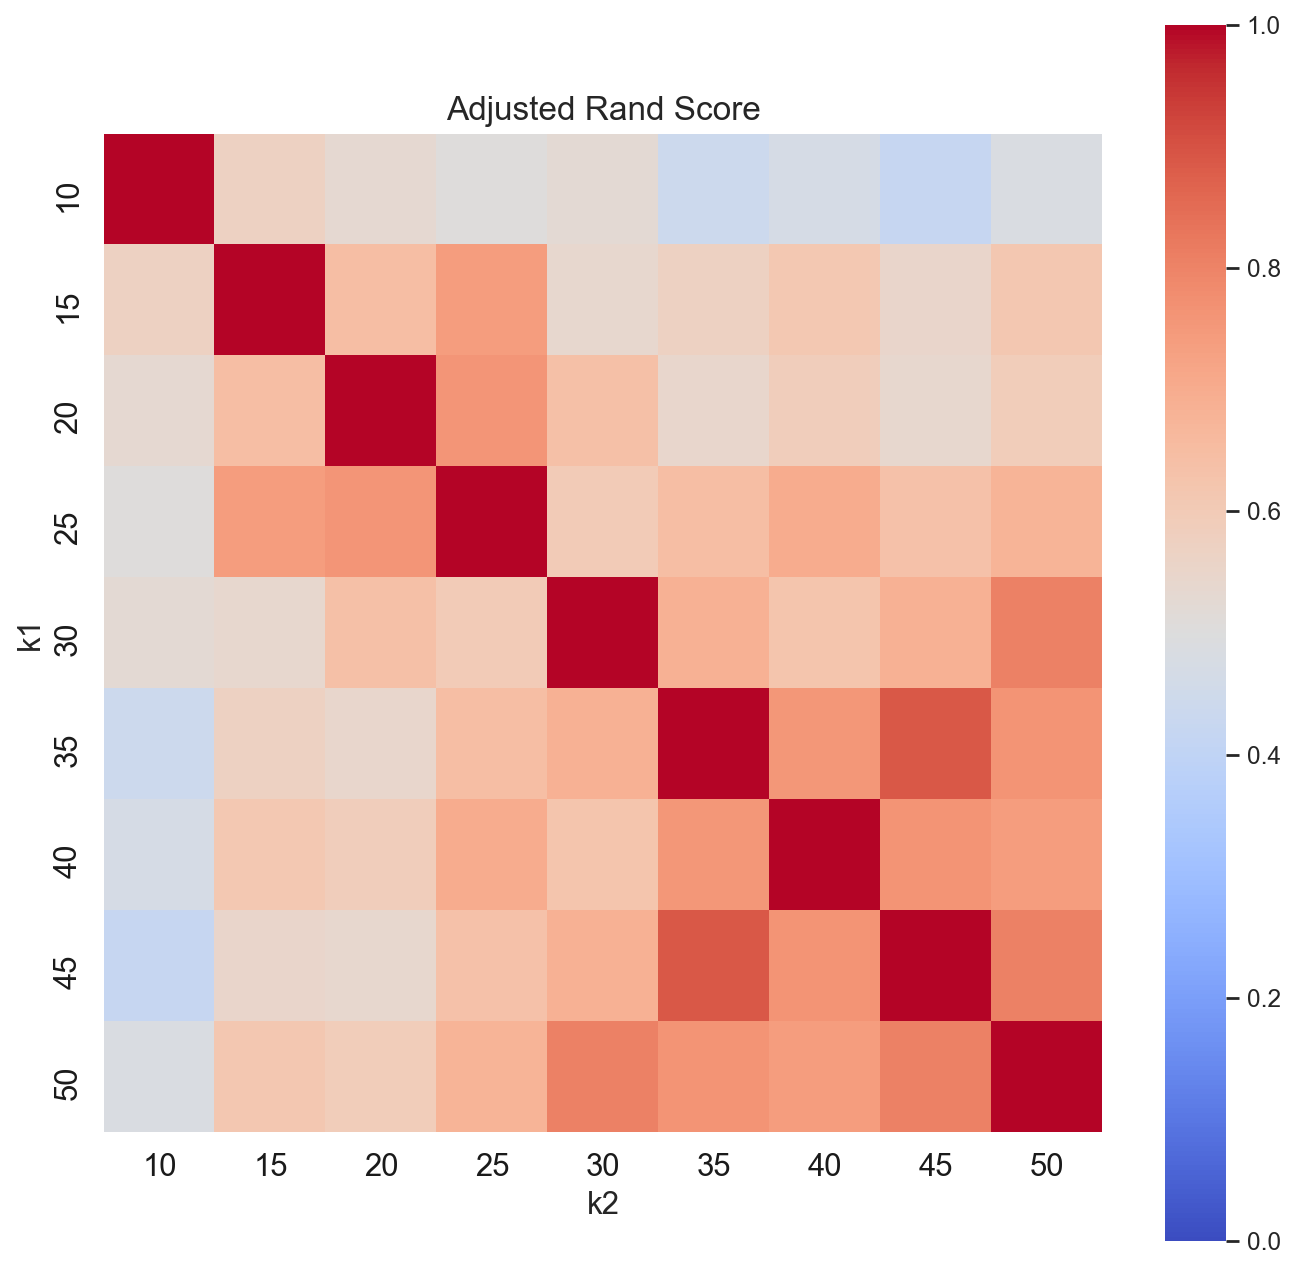

In [25]:
Rand_fig = plt.figure(figsize = (10,10))
plt.xlabel('k1')
plt.ylabel('k2')
plt.title('Adjusted Rand Score',fontsize=15)
sns.set(font_scale=1)
sns.heatmap(Rand_index_df, cmap=('coolwarm'), square=True, vmin=0, vmax=1)
# plt.colorbar(vmin=0)
plt.show();plt.close()


In [26]:
k = 45 # choose k
communities, graph, Q = sc.external.tl.phenograph(pd.DataFrame(adata_astro.obsm['X_pca']),k=k) # run PhenoGraph
adata_astro.obs['PhenoGraph_clusters_astro'] = pd.Categorical(communities)
adata_astro.uns['PhenoGraph_Q'] = Q
adata_astro.uns['PhenoGraph_k'] = k

Finding 45 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.04285383224487305 seconds
Jaccard graph constructed in 1.0896649360656738 seconds
Wrote graph to binary file in 0.18216705322265625 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.616936
After 3 runs, maximum modularity is Q = 0.619214
After 4 runs, maximum modularity is Q = 0.623531
Louvain completed 24 runs in 0.8446030616760254 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 2.819847822189331 seconds


## Vizualize Astrocyte sub-clusters

In [27]:
sc.pp.neighbors(adata_astro, method='umap', use_rep='X_pca')
sc.tl.umap(adata_astro, random_state=None)

... storing 'Condition' as categorical
... storing 'B_region' as categorical


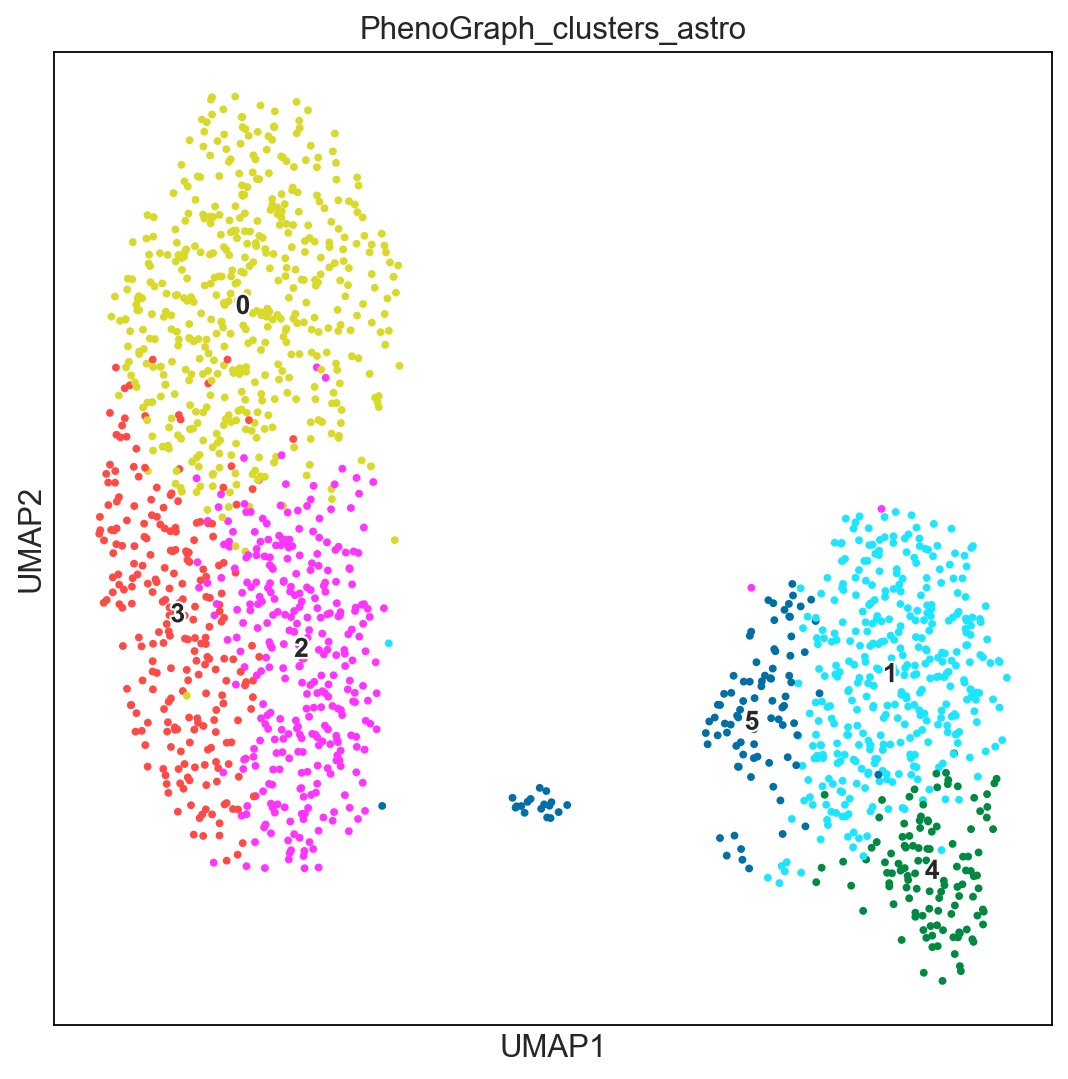

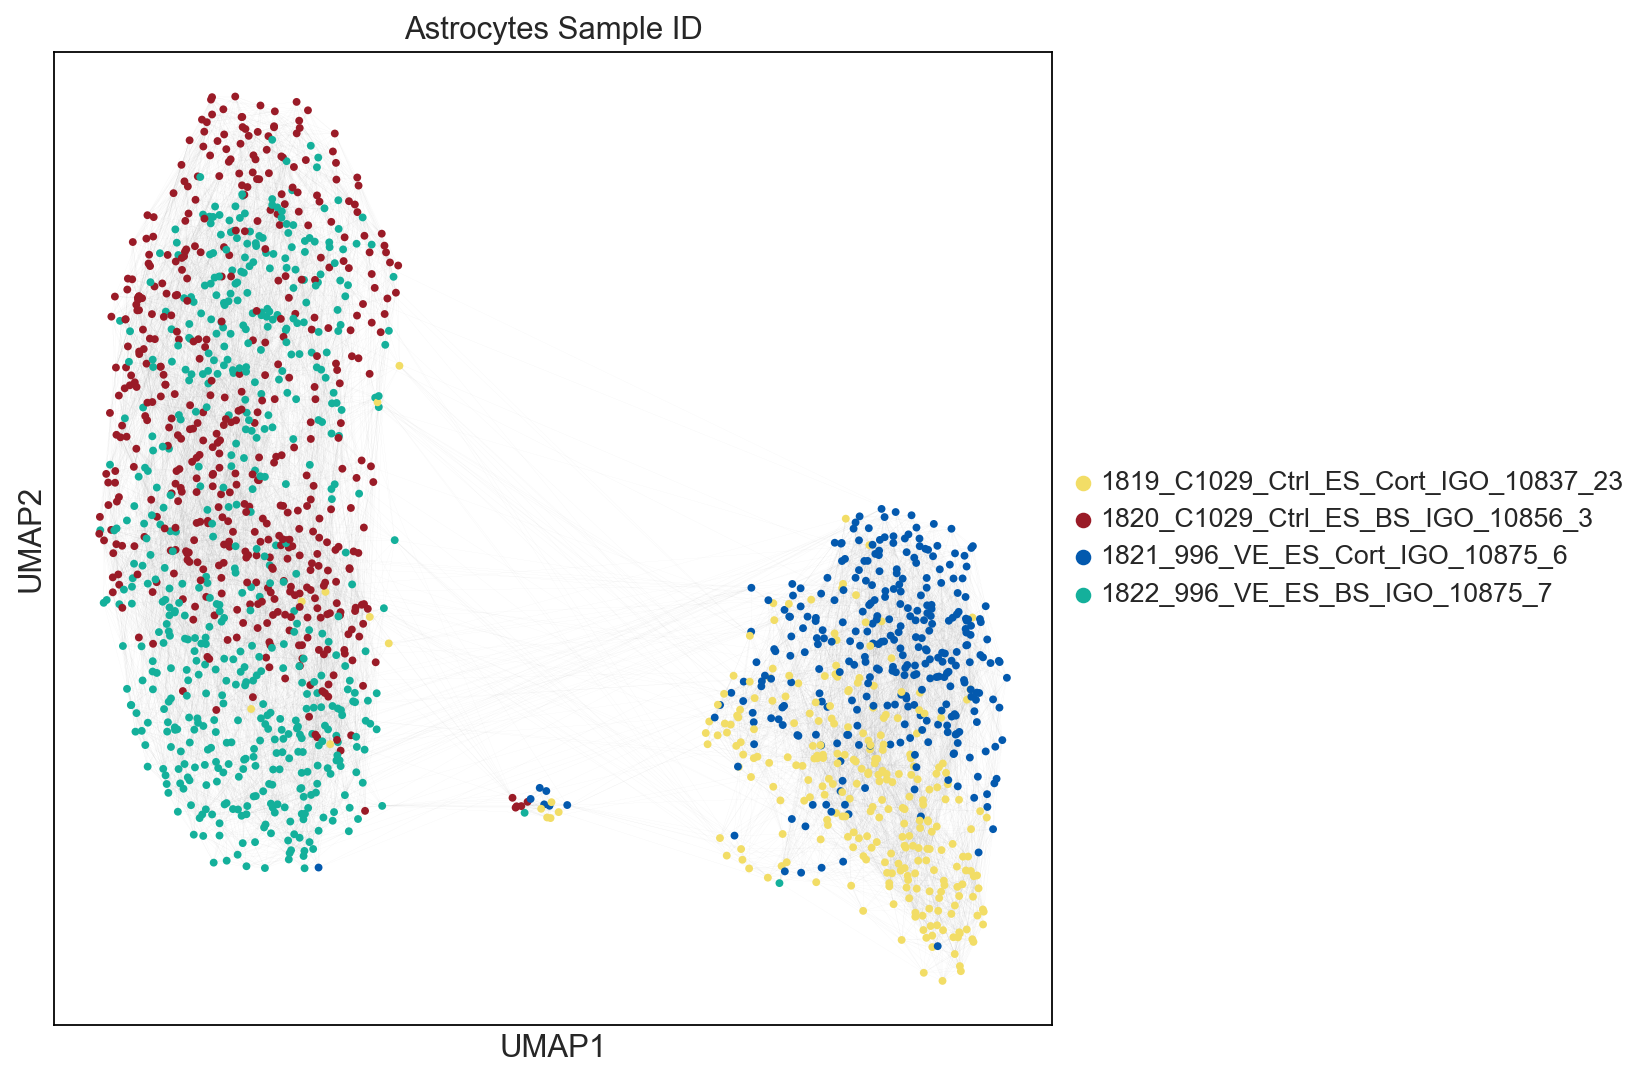

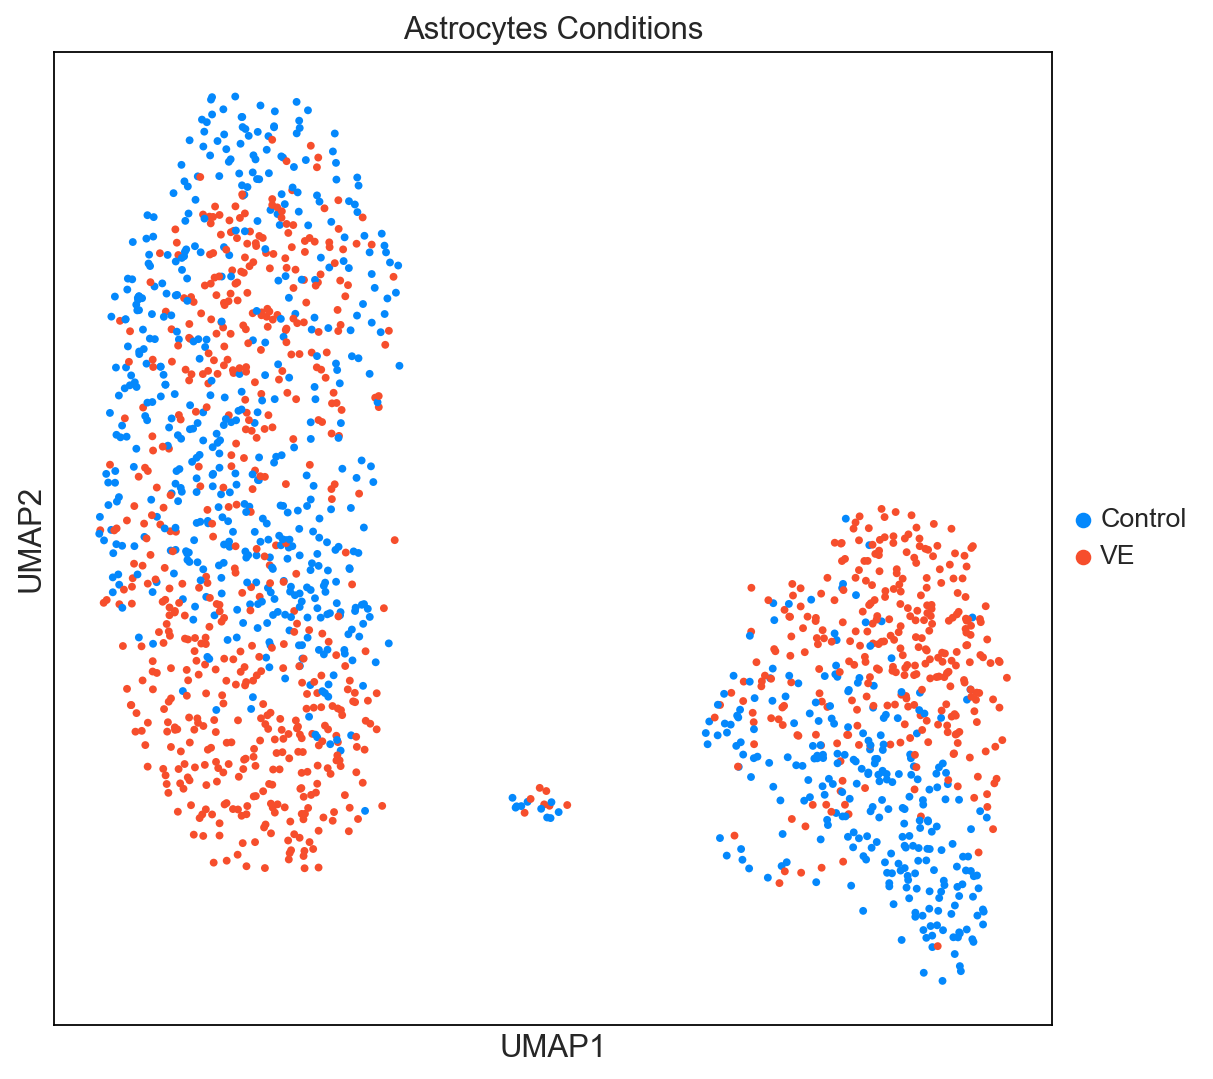

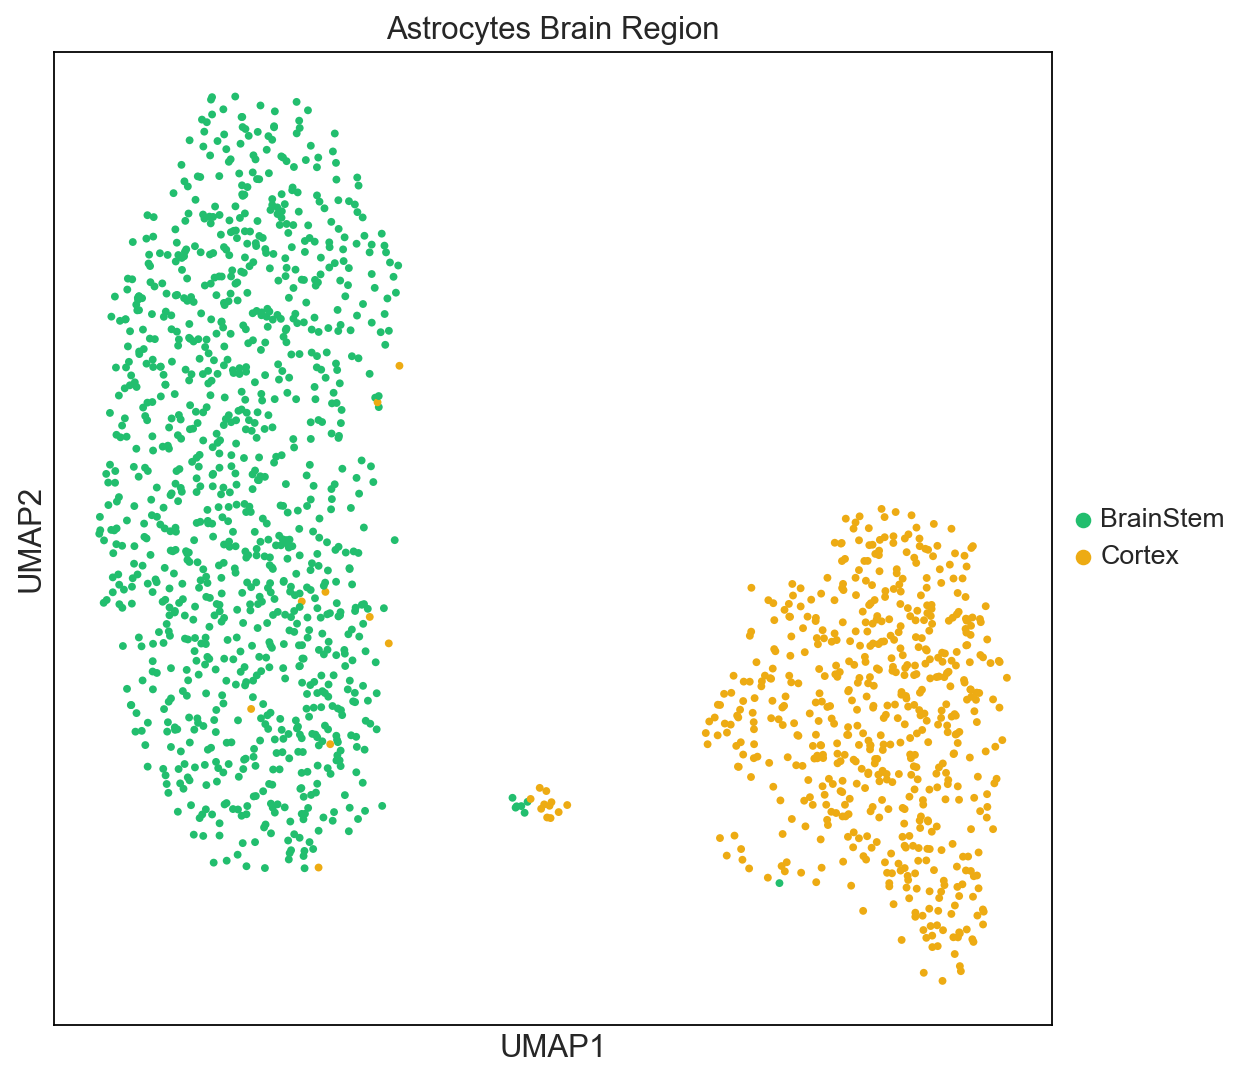

In [28]:
sc.set_figure_params(figsize=(8, 8))
sc.pl.umap(
    adata_astro,
    color=['PhenoGraph_clusters_astro'],
    ncols=2,
    sort_order=False,
    #edges = True,
    palette=godsnot_64, # 'palette' specifies the colormap to use
    cmap='Spectral_r',
    legend_loc='on data',
    legend_fontsize=12, size = 50,
    legend_fontoutline=2,
    #save= '_immune_cells_PhenoGraph_clusters'
)

sc.pl.umap(adata_astro, 
           color= ['Sample ID'],
           ncols=2,
           edges = True,
           edges_width= 0.01,
           palette= ["#F2DD66", "#9A1B27", "#0359AE", "#14B09B"],
           size=50, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Astrocytes Sample ID"])

sc.pl.umap(adata_astro,
           color=['Condition'],
           ncols=2,
           sort_order=False,
           palette=['#0488FC','#F64E2C'], # 'palette' specifies the colormap to use
           cmap='Spectral_r',
           legend_fontsize=12, size = 50, frameon = True,
           legend_fontoutline=2,
          title=["Astrocytes Conditions"])

sc.pl.umap(adata_astro, 
           color= ['B_region'],
           ncols=2,
           palette= ["#22BE6E", "#EDAB13"],
           size=50, 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Astrocytes Brain Region"])


## Find markers (Oligo clusters)

In [31]:
cl_int_to_str = dict()
cl_int_to_str = {
    0 : 'Astro0',
    1 : 'Astro1',
    2 : 'Astro2',
    3 : 'Astro3',
    4 : 'Astro4',
    5 : 'Astro5'}

adata_astro.obs['PhenoGraph_clusters_astro_str'] = adata_astro.obs['PhenoGraph_clusters_astro'].map(cl_int_to_str).astype('category')

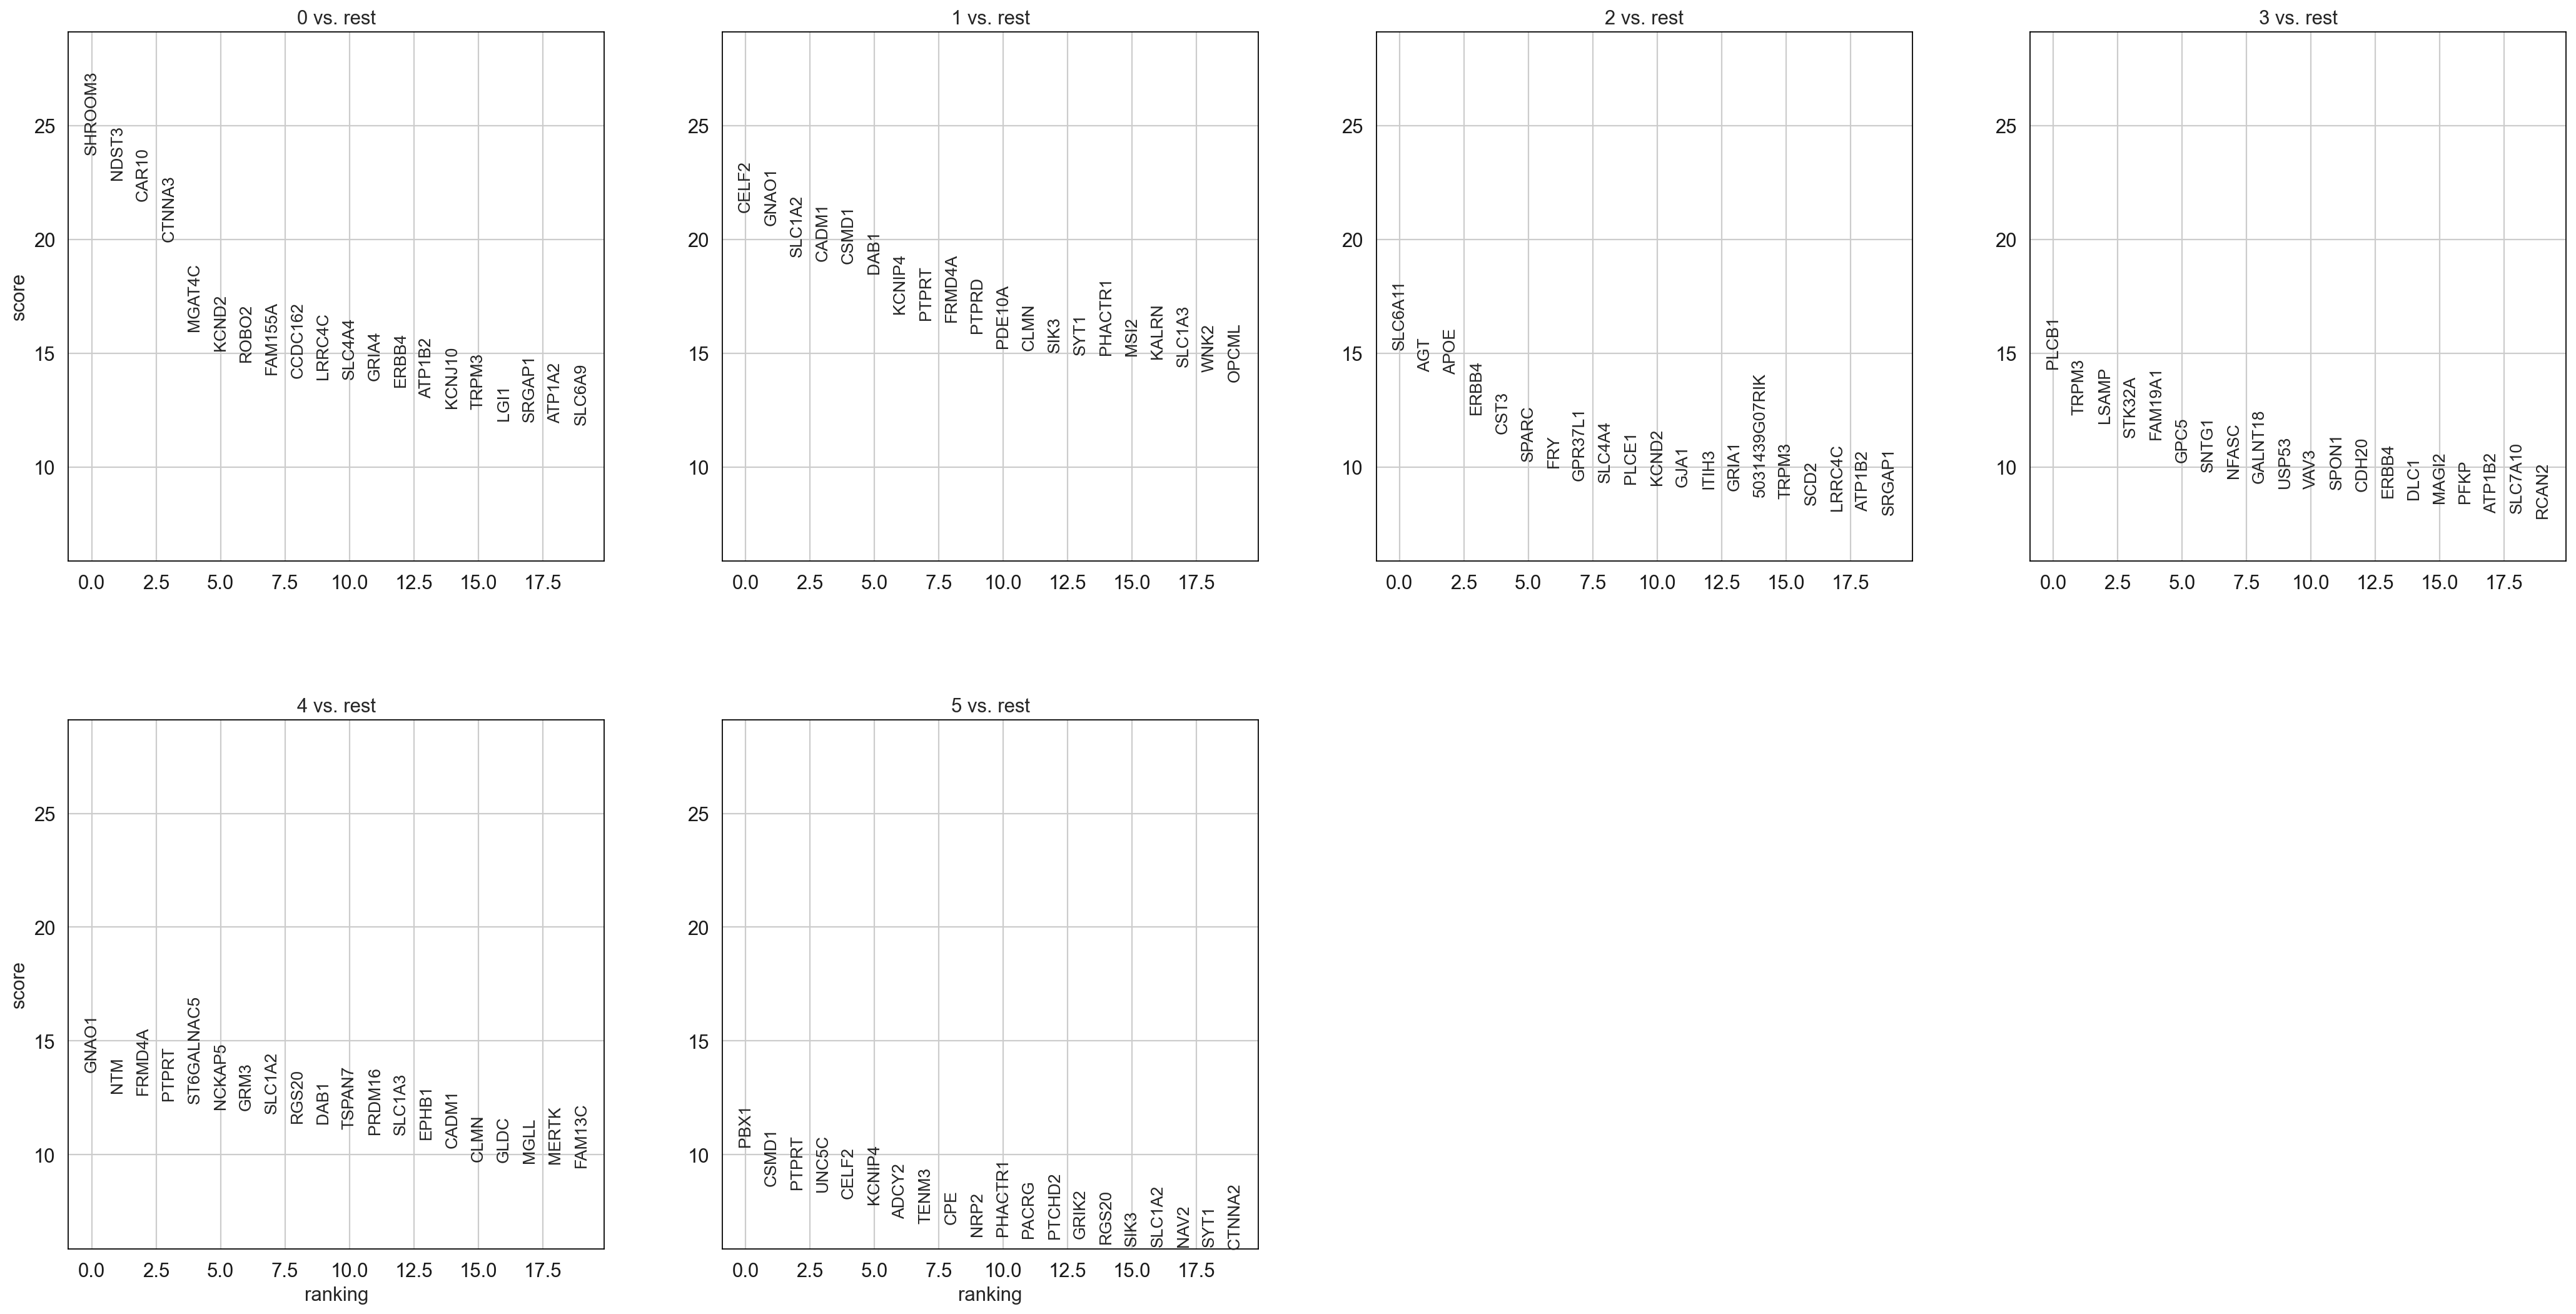

In [32]:
sc.tl.rank_genes_groups(adata_astro, groupby='PhenoGraph_clusters_astro', key_added="ranked_genes_pheno_astro", method='wilcoxon')
sc.pl.rank_genes_groups(adata_astro, key = 'ranked_genes_pheno_astro', fontsize=12)

## Visualize marker genes using heatmap

In [33]:
adata_astro.layers['scaled'] = sc.pp.scale(adata_astro, copy=True).X

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


{'heatmap_ax': <AxesSubplot:>,
 'groupby_ax': <AxesSubplot:xlabel='PhenoGraph_clusters_astro_str'>,
 'dendrogram_ax': <AxesSubplot:>,
 'gene_groups_ax': <AxesSubplot:>}

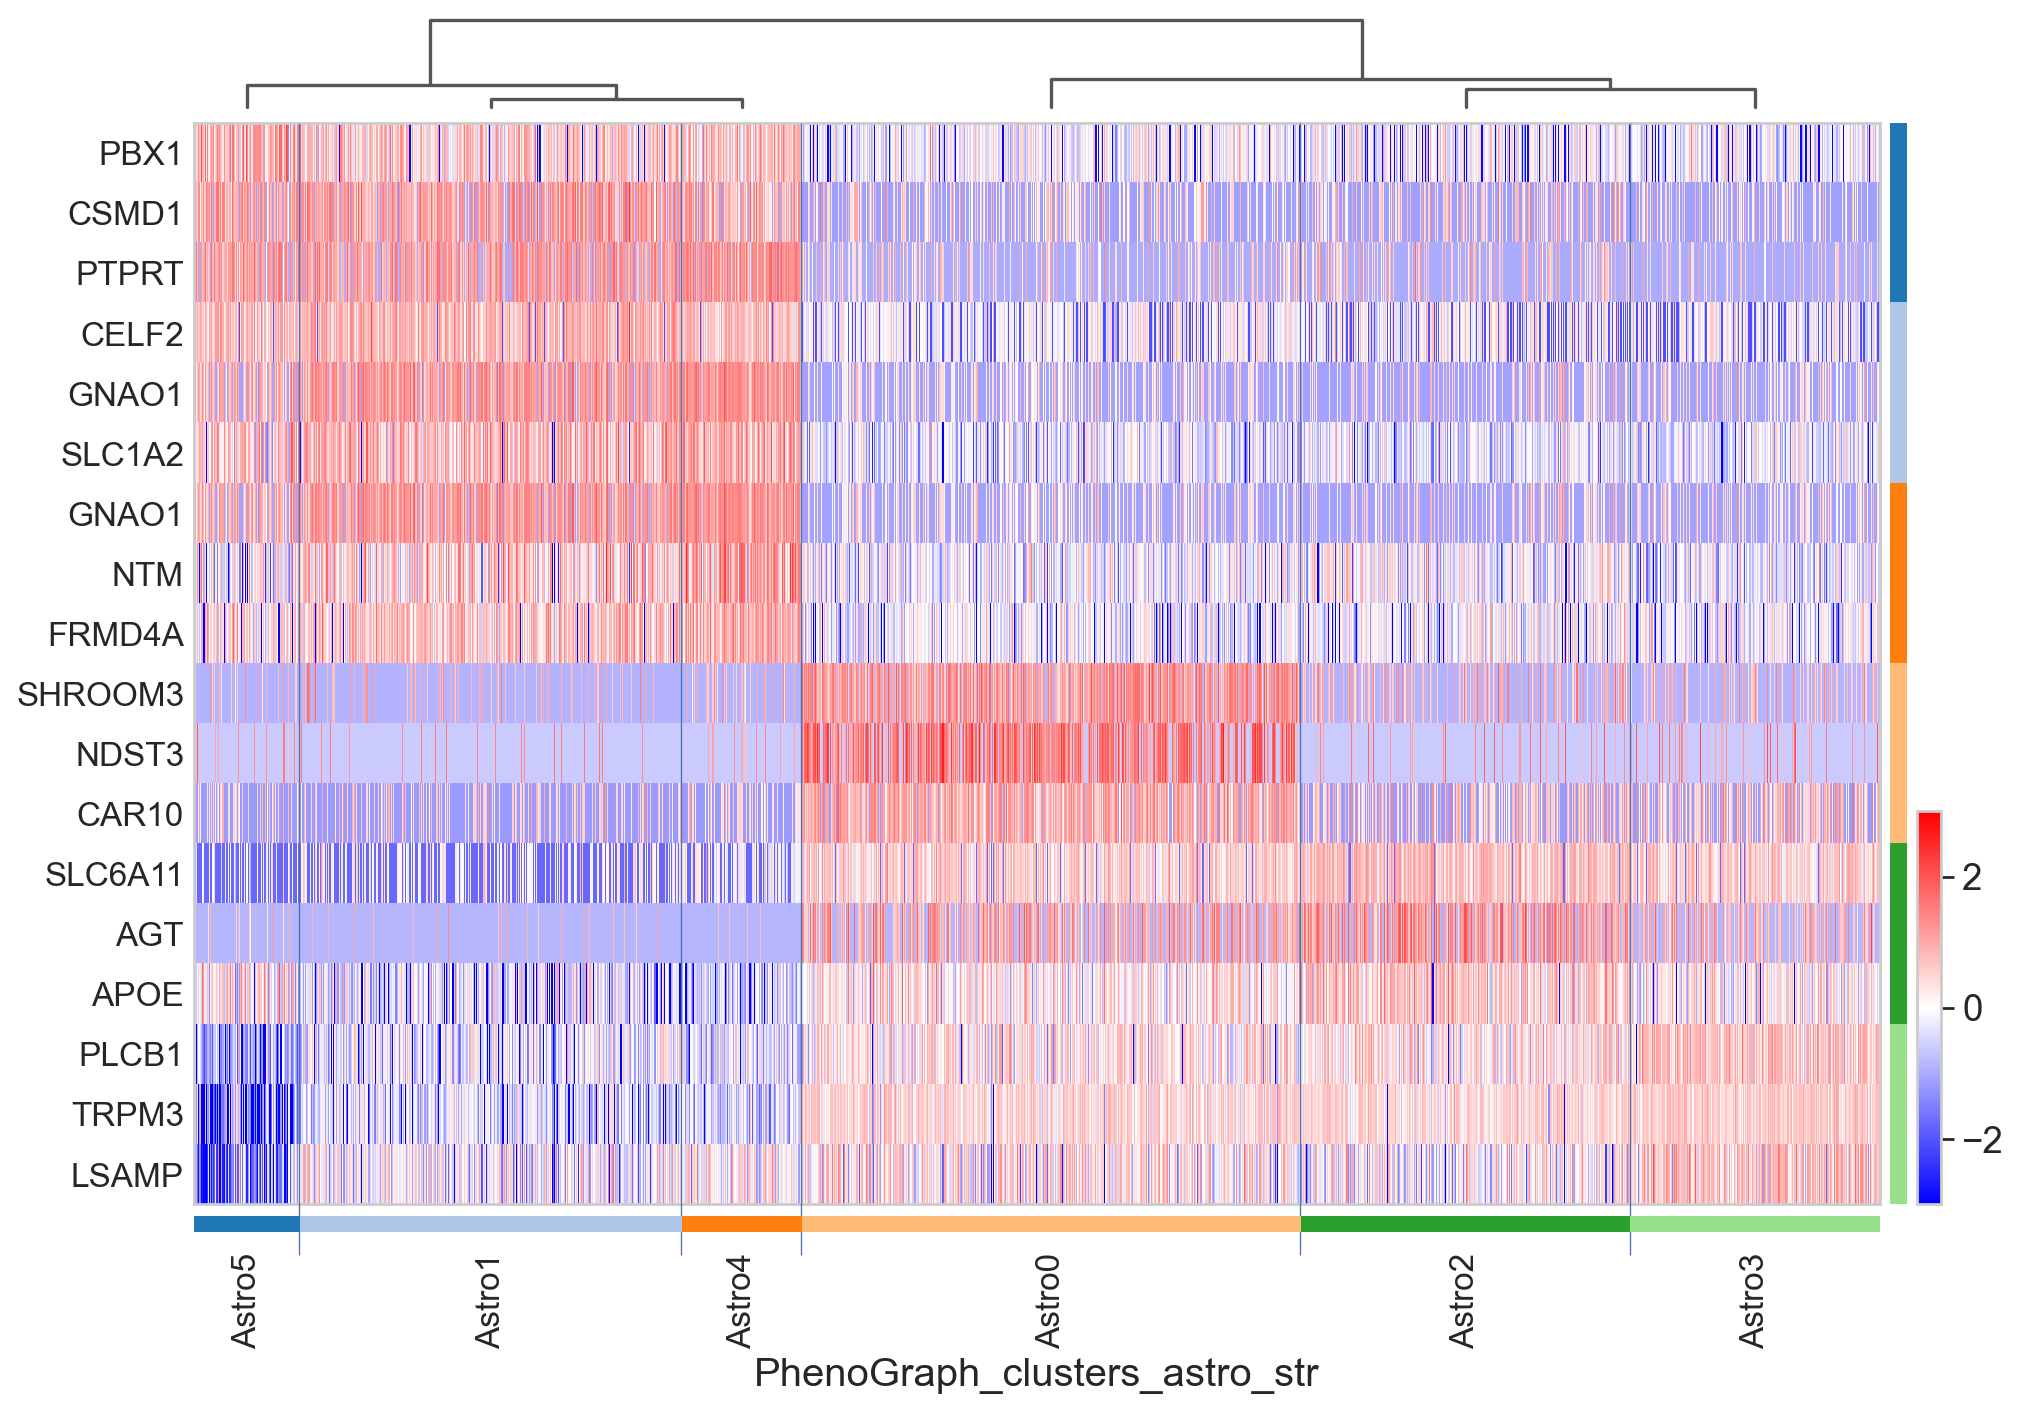

In [65]:
sc.tl.rank_genes_groups(adata_astro, groupby='PhenoGraph_clusters_astro_str', n_genes=adata_astro.shape[1], method='wilcoxon')
sc.pl.rank_genes_groups_heatmap(adata_astro, n_genes=3, use_raw=False, swap_axes=True, vmin=-3, vmax=3, cmap='bwr', layer='scaled', figsize=(14,10), show=False)

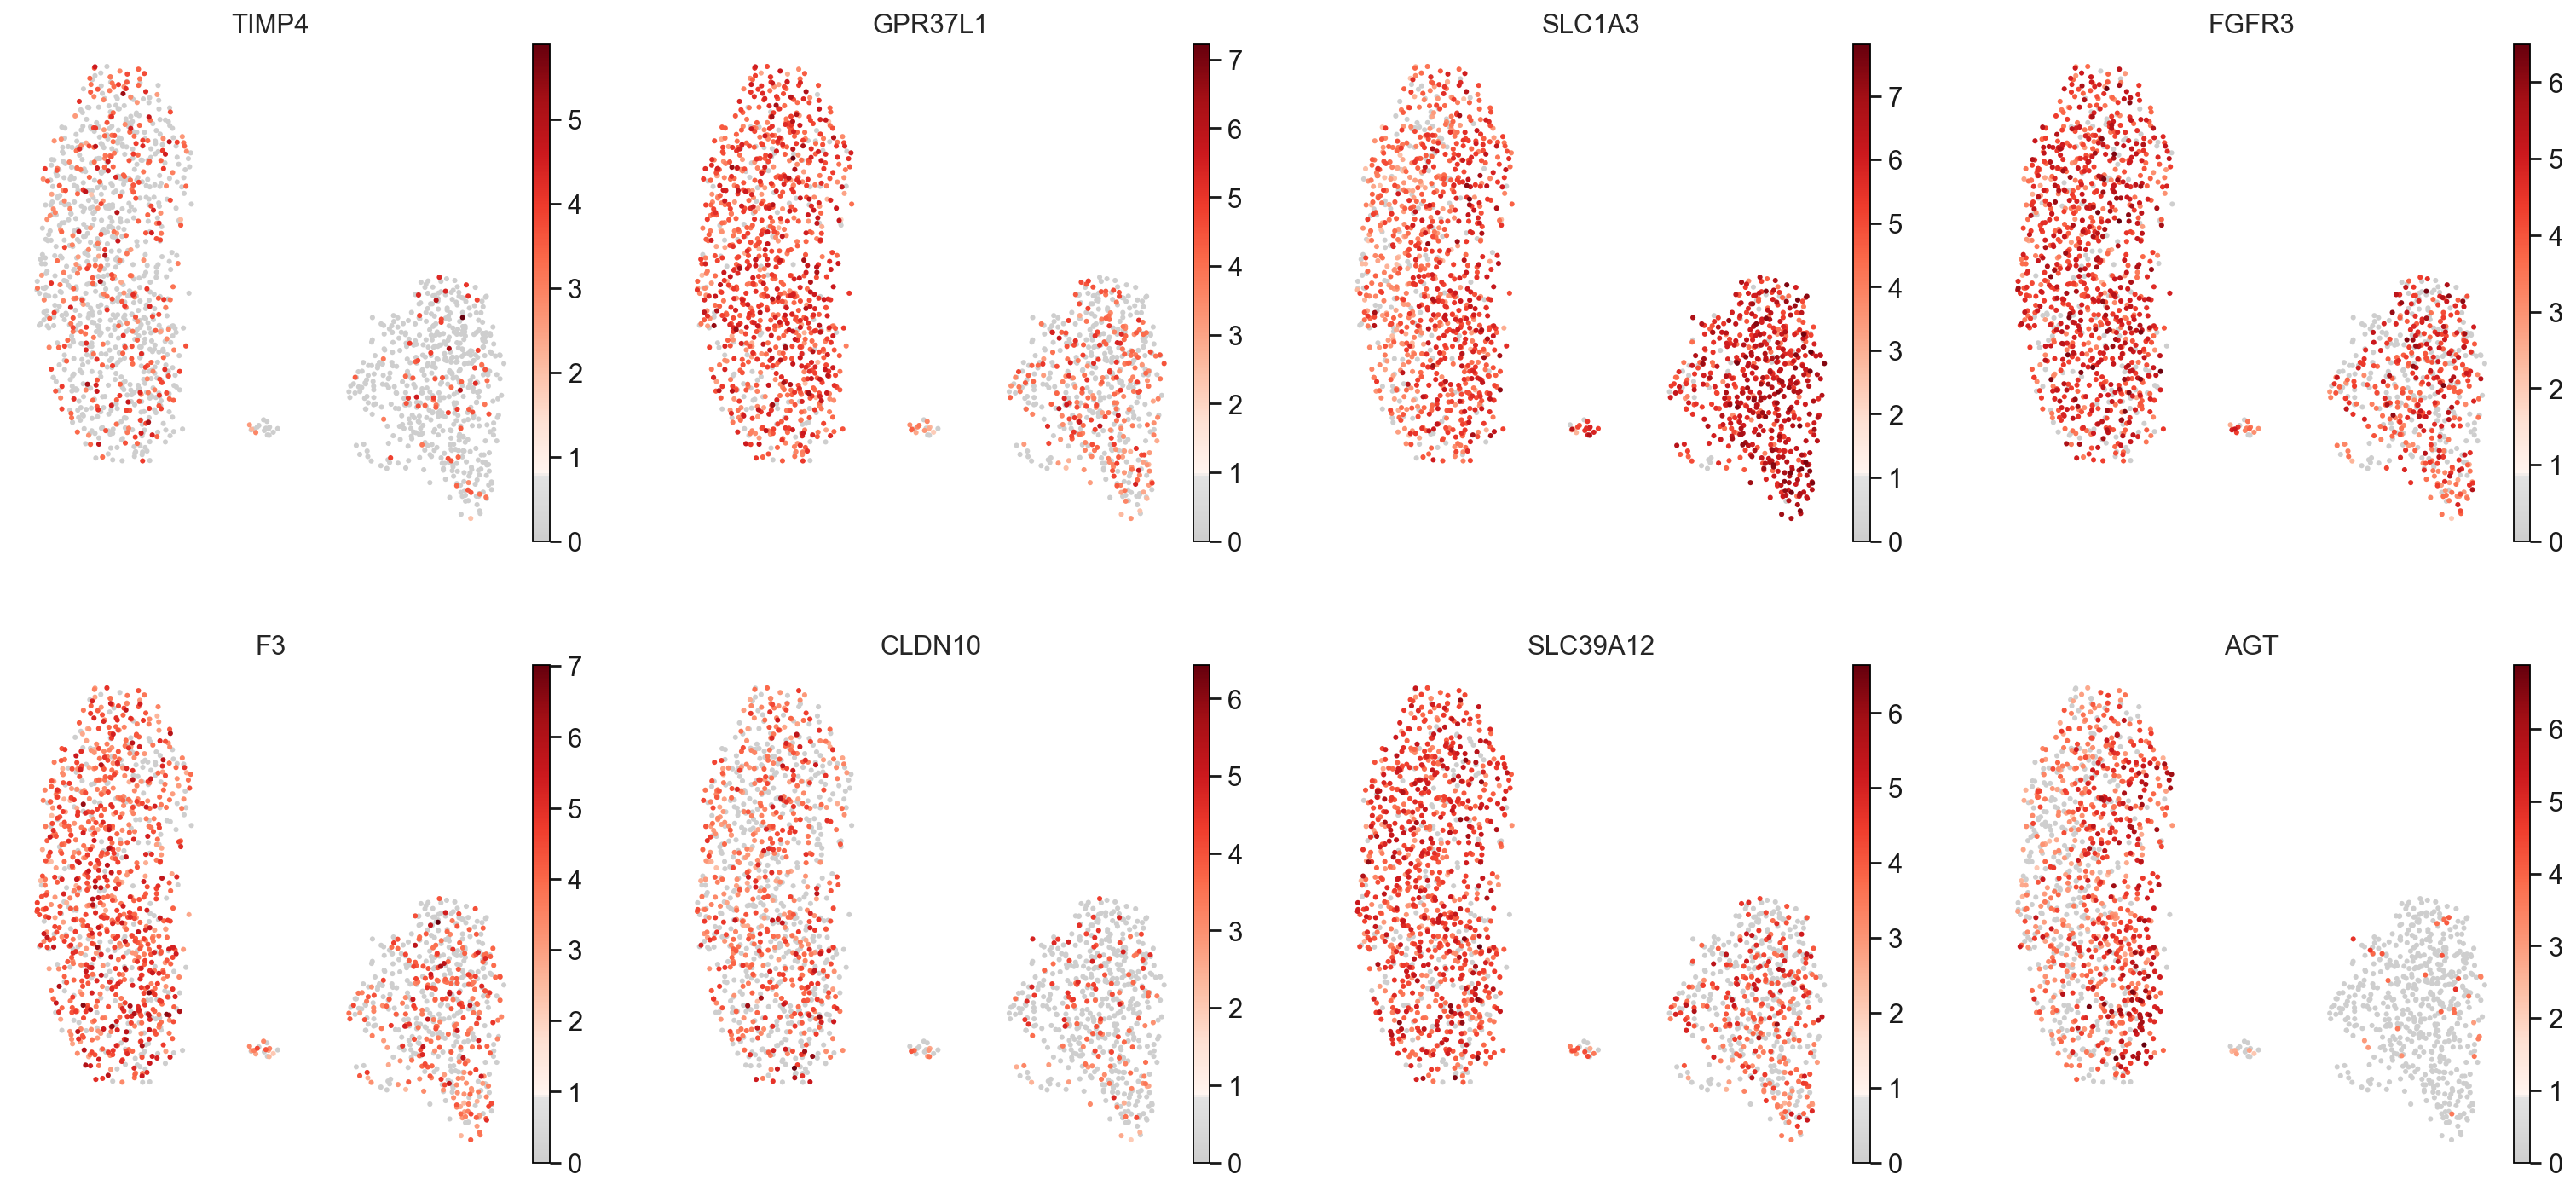

In [110]:
sc.set_figure_params(figsize=(5, 5))
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = matplotlib.colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)
 
sc.pl.umap(adata_astro,
           size = 30,
           color=['TIMP4','GPR37L1','SLC1A3','FGFR3','F3', 'CLDN10', 'SLC39A12', 'AGT'],
           color_map=mymap,
          frameon=False)

In [36]:
adata_astro.obs.PhenoGraph_clusters_astro.value_counts()

0    482
1    369
2    318
3    241
4    116
5    102
Name: PhenoGraph_clusters_astro, dtype: int64

## Save result Adata Astrocytes

In [37]:
#adata_astro.write_h5ad(outdir+'adata_high_var_Astro_diff_norm_clusters.h5ad')

In [12]:
adata_astro = sc.read_h5ad(outdir+'adata_high_var_Astro_diff_norm_clusters.h5ad')

## Differential expression with MAST for Cortex & Brainstem

Load the adata object that holds the latest cell type annotations..

In [13]:
run_MAST_for_celltype(adata_astro, "Astrocytes")

Astrocytes	Dimensions	(1628, 12353)
Files written for Astrocytes
Running ./runMAST.R DEA/Astrocytes/adata_Astrocytes_exp_mat.csv DEA/Astrocytes/adata_Astrocytes_cdata.csv DEA/Astrocytes/MAST_DEA_Astrocytes_cort.csv DEA/Astrocytes/MAST_DEA_Astrocytes_bs.csv


'Finished running MAST on( Astrocytes) in 435.203148835 seconds.'

### Brainstem Enricher

In [15]:
# import the MAST results
mast_astro_res = pd.read_csv (filepath_or_buffer= 'DEA/Astrocytes/MAST_DEA_Astrocytes_bs.csv')
print(mast_astro_res)

              gene             p     p.fdr.adj     logFC
0            FKBP5  2.137871e-52  2.640912e-48  1.842475
1            NPAS3  6.022862e-30  3.720021e-26 -0.554352
2              SON  1.540099e-29  6.341616e-26 -0.868324
3              NTM  3.953258e-27  1.220865e-23 -0.503676
4           MGAT4C  3.800735e-20  9.390095e-17 -0.939421
..             ...           ...           ...       ...
396  B020031H02RIK  1.536230e-03  4.780114e-02  0.112186
397           PFKP  1.548842e-03  4.807247e-02  0.489942
398           NRF1  1.563684e-03  4.841150e-02  0.308929
399            B2M  1.585701e-03  4.897042e-02  0.206295
400        S100A13  1.590880e-03  4.900783e-02  0.177338

[401 rows x 4 columns]


In [17]:
#filter DE results
mast_astro_res = mast_astro_res.sort_values(by='logFC', ascending=False)
# Upregulated genes
mast_astro_res_UP = mast_astro_res[(mast_astro_res['logFC'] >=0.01) & (mast_astro_res['p.fdr.adj'] <= 0.05)]
mast_astro_res_DOWN = mast_astro_res[(mast_astro_res['logFC'] <=0.01) & (mast_astro_res['p.fdr.adj'] <= 0.05)]
#mast_C0_res_UP['gene'].head(20)
mast_astro_res_UP.shape

(203, 4)

In [ ]:
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
import gseapy
gene_set_names = gseapy.get_library_name(database='Mouse')
#print(gene_set_names)

mast_astro_res_UP_n_list = mast_astro_res_UP.gene.str.strip().tolist()
enr_res = gseapy.enrichr(gene_list=mast_astro_res_UP_n_list,
                     organism='Mouse',
                     gene_sets=['KEGG_2019_Mouse'],
                     description='pathway',
                     cutoff = 0.5)

In [21]:
enr_res.results.head(10)

Gene_set                               Term Overlap   P-value  \
0  KEGG_2019_Mouse  Thyroid hormone signaling pathway   9/115  0.000003   
1  KEGG_2019_Mouse             Long-term potentiation    6/67  0.000061   
2  KEGG_2019_Mouse              Glutamatergic synapse   7/114  0.000165   
3  KEGG_2019_Mouse         Oxytocin signaling pathway   8/154  0.000181   
4  KEGG_2019_Mouse              Wnt signaling pathway   8/160  0.000235   
5  KEGG_2019_Mouse               Long-term depression    5/61  0.000385   
6  KEGG_2019_Mouse            HIF-1 signaling pathway   6/104  0.000675   
7  KEGG_2019_Mouse                 Salivary secretion    5/78  0.001188   
8  KEGG_2019_Mouse                       Gap junction    5/86  0.001836   
9  KEGG_2019_Mouse             FoxO signaling pathway   6/132  0.002307   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.000522            0                     0    8.617925   
1          0.005934            0                     0    9.854040   
2          0.008852            0                     0    6.572096   
3          0.008852            0                     0    5.521883   
4          0.009195            0                     0    5.302294   
5          0.012564            0                     0    8.901966   
6          0.018904            0                     0    6.122138   
7          0.029101            0                     0    6.823025   
8          0.039979            0                     0    6.146652   
9          0.044317            0                     0    4.754895   

   Combined Score                                              Genes  
0      110.625413  CREBBP;THRA;RCAN2;EP300;PRKCA;PLCB1;PLCD4;PFKP...  
1       95.703348                CREBBP;ITPR1;EP300;PRKCA;PLCB1;GRM1  
2       57.255744             GNAO1;ITPR1;PRKCA;PLD1;PLCB1;GLUL;GRM1  
3       47.592848  GNAO1;CDKN1A;CAMK1D;ITPR1;NFATC3;PRKAG1;PRKCA;...  
4       44.315378  CCND3;CREBBP;DAAM2;NFATC3;EP300;PRKCA;PRICKLE1...  
5       69.998305                       GNAO1;ITPR1;PRKCA;PLCB1;GRM1  
6       44.695315             CREBBP;CDKN1A;ANGPT1;STAT3;EP300;PRKCA  
7       45.957529                      CST3;KCNMA1;ITPR1;PRKCA;PLCB1  
8       38.725658                       PDGFD;ITPR1;PRKCA;PLCB1;GRM1  
9       28.871519              CREBBP;CDKN1A;STAT3;PRKAG1;EP300;GRM1

## Astrocytes Brainstem

In [210]:
adata_astro_BS = adata_astro.copy()
adata_astro_BS = adata_astro_BS[adata_astro_BS.obs['B_region'].isin(['BrainStem']),:]
adata_astro_BS.shape

(1039, 12353)

In [211]:
adata_astro_BS.obs.Condition.value_counts()

VE         550
Control    489
Name: Condition, dtype: int64

#### Astrocytes BS control 

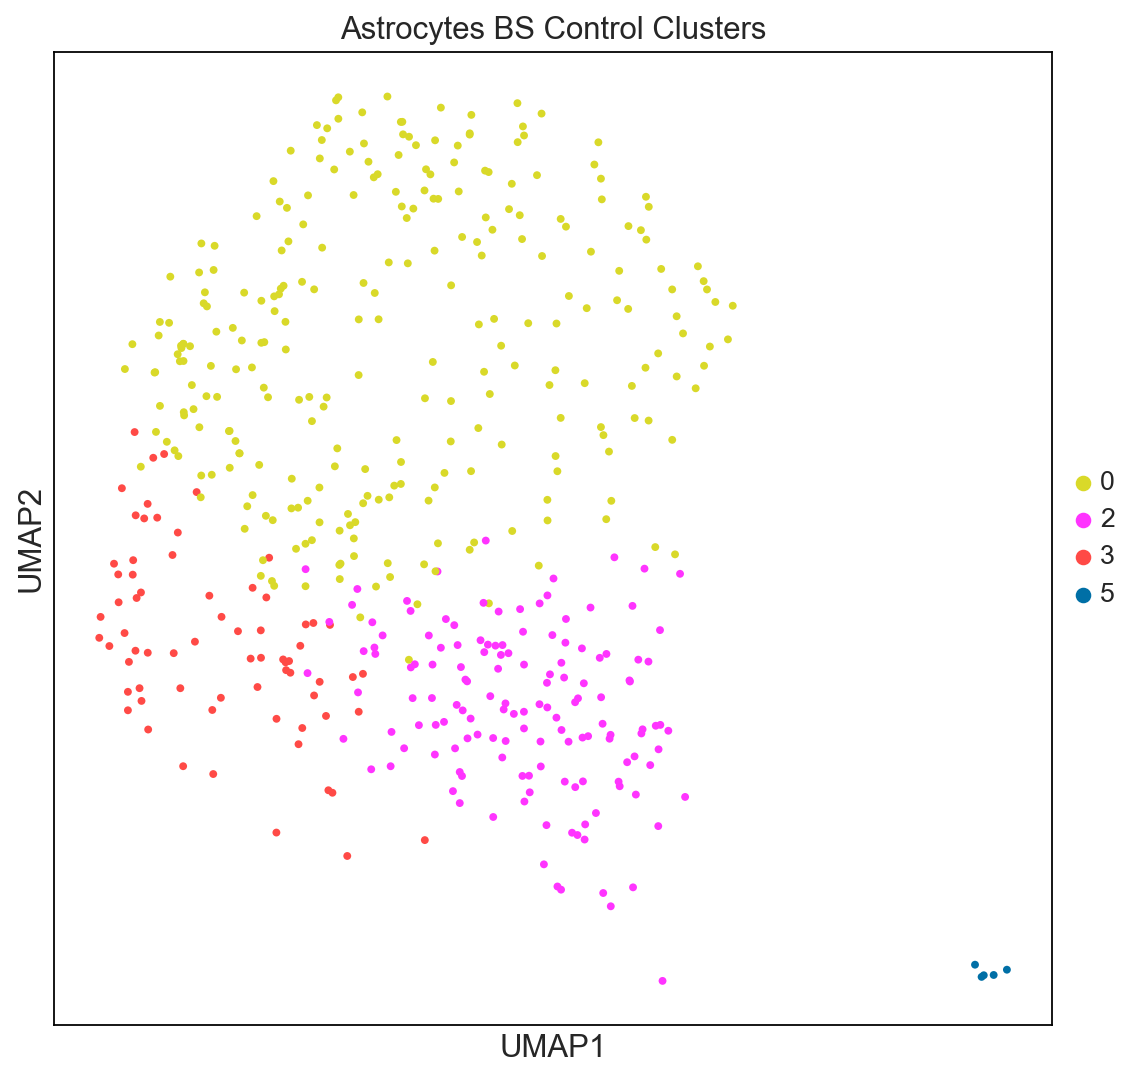

In [49]:
adata_astro_BS_control = adata_astro_BS[adata_astro_BS.obs['Condition'].isin(['Control']),:].copy()

sc.set_figure_params(figsize=(8, 8))
sc.pl.umap(adata_astro_BS_control, 
           color= ['PhenoGraph_clusters_astro'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=["#d9d929", "#FF34FF", "#FF4A46", "#006FA6", "#A30059",],
           size=50, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Astrocytes BS Control Clusters"])

In [50]:
cell_counts_per_cluster_BS_ctrl= adata_astro_BS_control.obs.PhenoGraph_clusters_astro.value_counts()
cell_counts_per_cluster_BS_ctrl = cell_counts_per_cluster_BS_ctrl.to_frame()
cell_counts_per_cluster_BS_ctrl

PhenoGraph_clusters_astro
0                        271
2                        143
3                         70
5                          5

#### Astrocytes BS VE

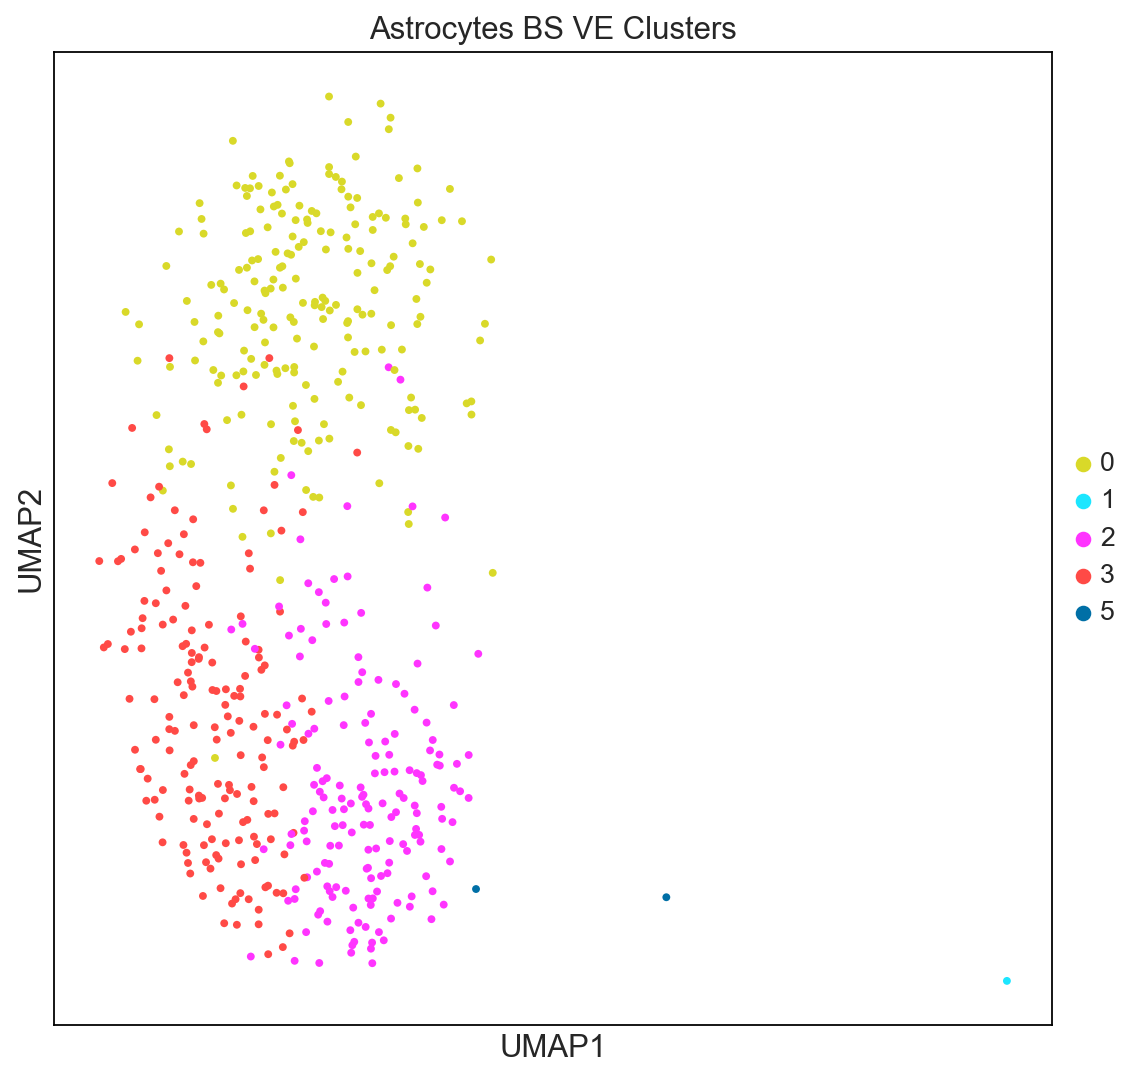

In [180]:
adata_astro_BS_VE = adata_astro_BS[adata_astro_BS.obs['Condition'].isin(['VE']),:].copy()

sc.set_figure_params(figsize=(8, 8))
sc.pl.umap(adata_astro_BS_VE, 
           color= ['PhenoGraph_clusters_astro'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=["#d9d929", "#1CE6FF", "#FF34FF", "#FF4A46", "#006FA6", "#A30059"],
           size=50, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Astrocytes BS VE Clusters"])

In [ ]:
#sc.pl.violin(adata_astro_BS_VE, ['APOE','PLCB1'], groupby='PhenoGraph_clusters_astro', inner='point', palette = godsnot_64)


In [18]:
cell_counts_per_cluster_BS_VE = adata_astro_BS_VE.obs.PhenoGraph_clusters_astro.value_counts()
cell_counts_per_cluster_BS_VE = cell_counts_per_cluster_BS_VE.to_frame()
cell_counts_per_cluster_BS_VE

PhenoGraph_clusters_astro
0                        209
3                        170
2                        168
5                          2
1                          1

### Heatmaps of gene expression

In [46]:
marker_genes_dict = dict()

marker_genes_dict = {'Astro-BS':['FKBP5',
'FAM19A1',
'GALNT18',
'NELL2',
'KCNQ3',
'SPON1',
'KCNMA1',
'KCNT1',
'CPE',
'ASIC2',
'MEG3',
'SGCD',
'EFR3B',
'LRRTM4',
'SLC24A4',
'FAM20A',
'ZFP423',
'CCND3',
'AIFM3',
'TSC22D3']}




categories: Astro0_Control, Astro0_VE, Astro1_VE, etc.
var_group_labels: Astro-BS


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  __ = ax.pcolor(_color_df, **kwds)


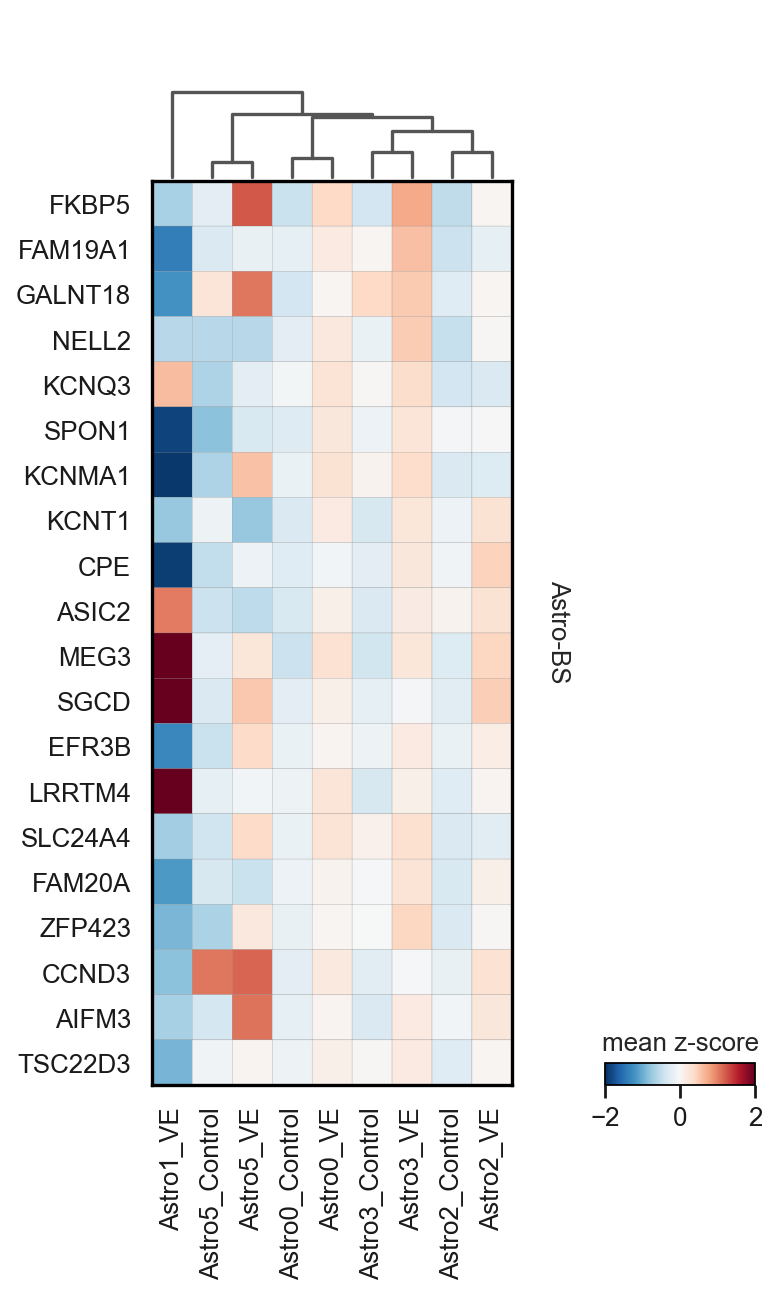

categories: Astro0_Control, Astro0_VE, Astro1_VE, etc.
var_group_labels: Astro-BS


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


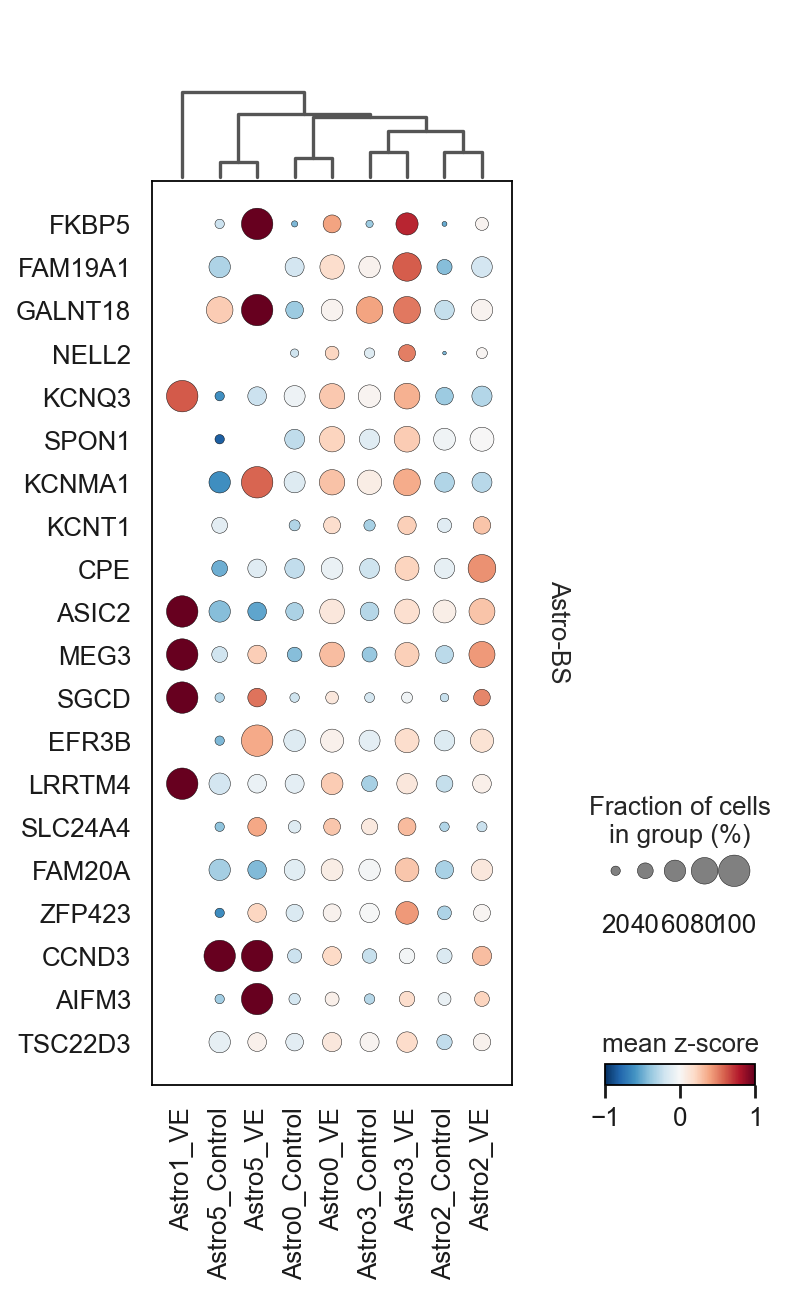

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


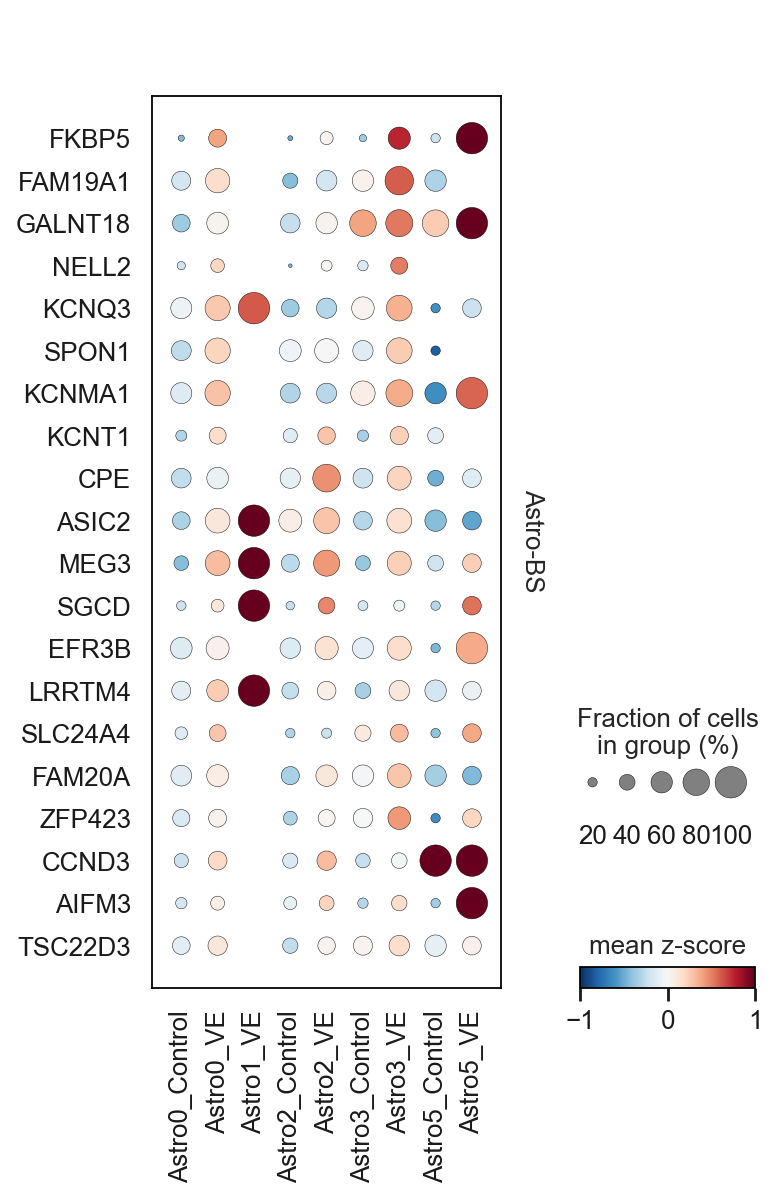

In [47]:
adata_astro_BS.layers['scaled'] = sc.pp.scale(adata_astro_BS, copy=True).X
sc.pl.matrixplot(adata_astro_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_astro_str','Condition'], dendrogram=True,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_astro_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_astro_str','Condition'], dendrogram=True,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_astro_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_astro_str','Condition'], dendrogram=False,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

## Astrocytes Cortex

In [111]:
adata_astro_cortex = adata_astro.copy()
adata_astro_cortex = adata_astro_cortex[adata_astro_cortex.obs['B_region'].isin(['Cortex']),:]
adata_astro_cortex.shape

(589, 12353)

In [112]:
adata_astro_cortex.obs.Condition.value_counts()

VE         314
Control    275
Name: Condition, dtype: int64

Trying to set attribute `.uns` of view, copying.


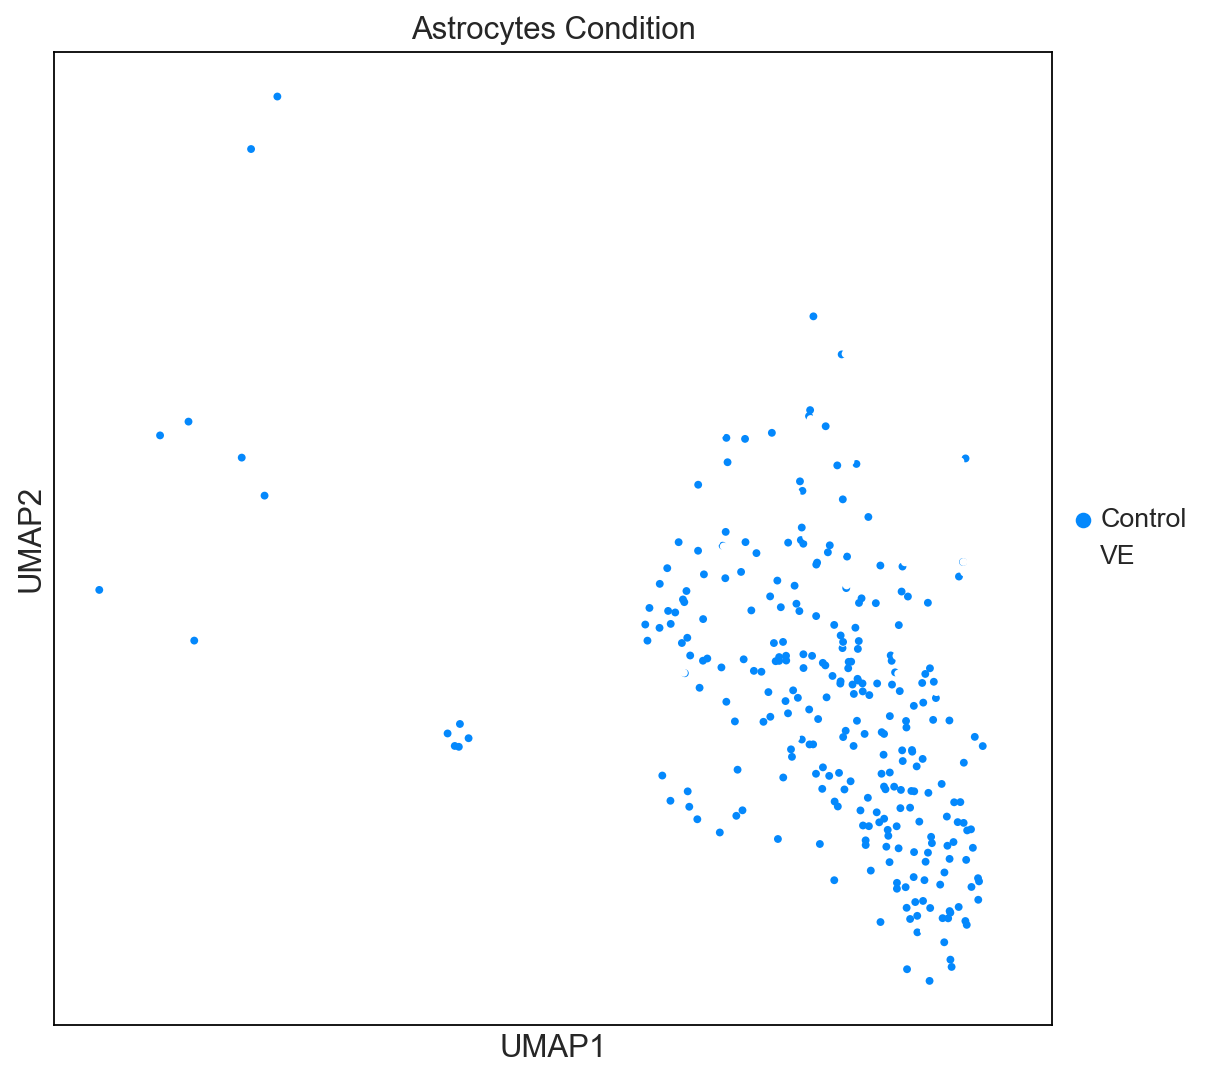

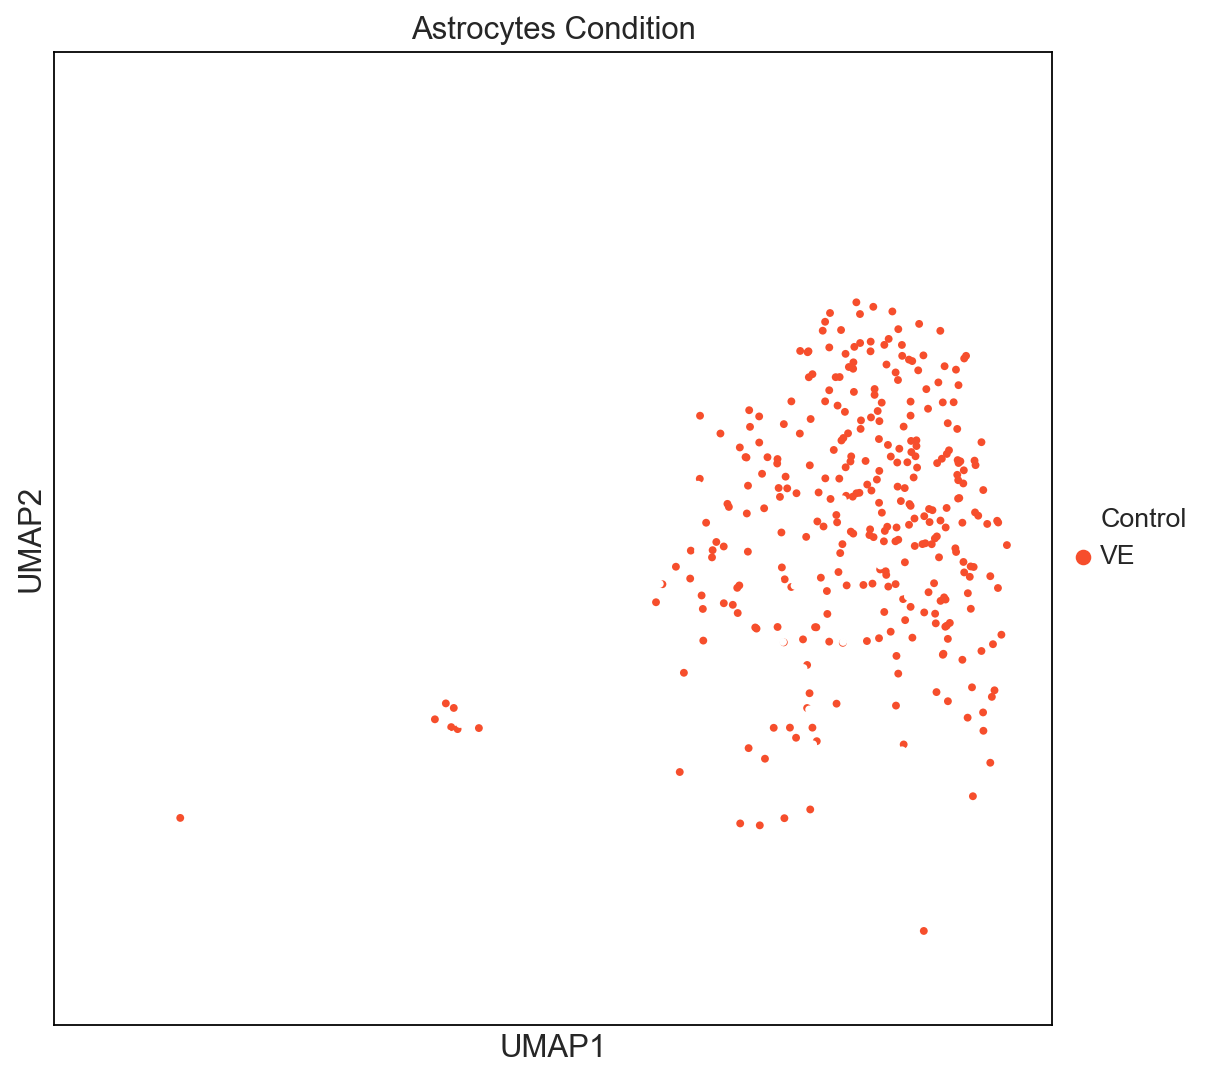

In [113]:
sc.set_figure_params(figsize=(8, 8))
sc.pl.umap(adata_astro_cortex, 
           color= ['Condition'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=['#0488FC','#FFFFFFFF'],
           size=50, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Astrocytes Condition"])


sc.pl.umap(adata_astro_cortex, 
           color= ['Condition'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=['#FFFFFFFF','#F64E2C'],
           size=50, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Astrocytes Condition"])

#### Astrocytes cortex control

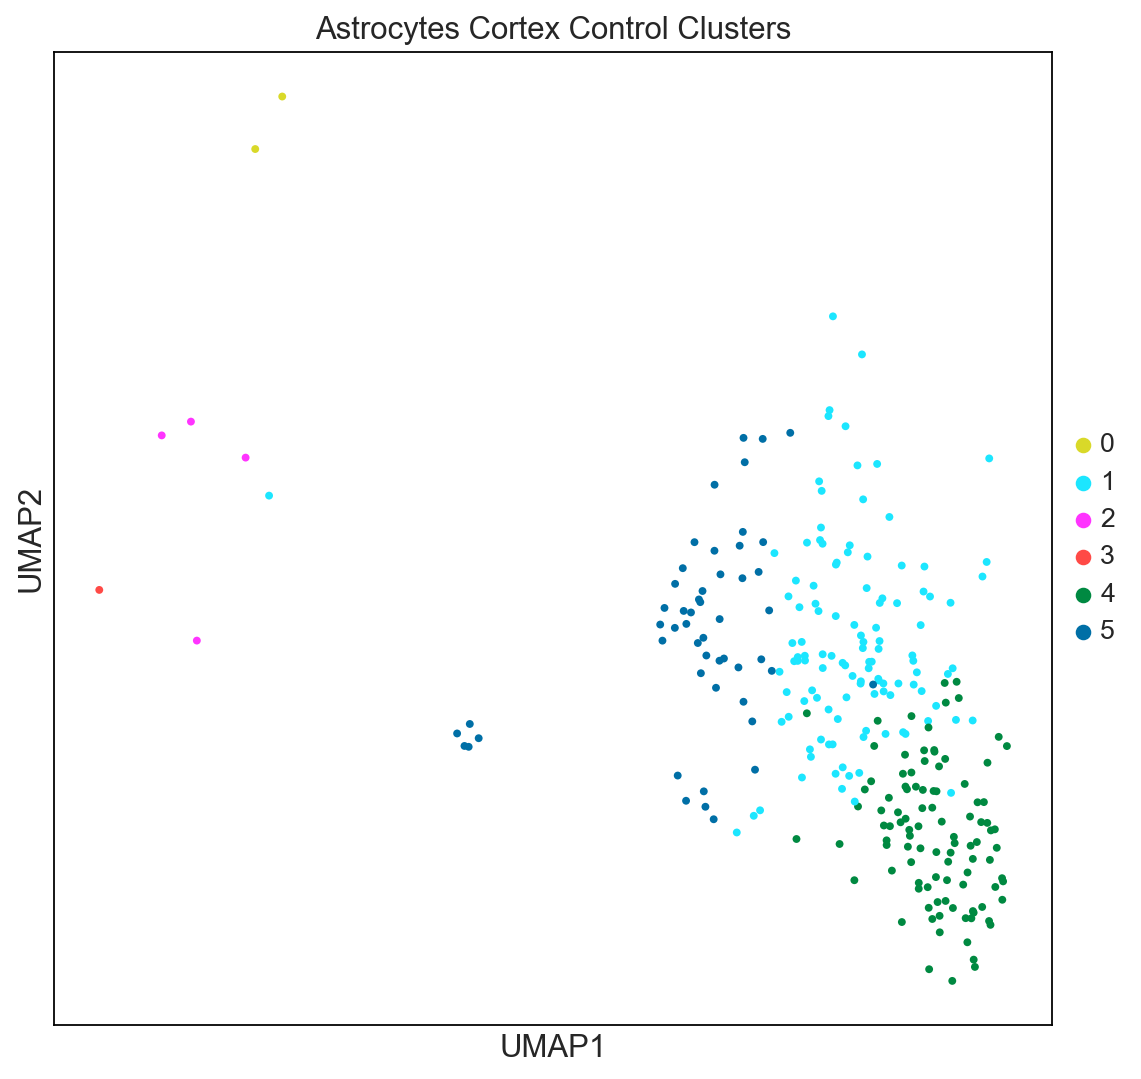

In [114]:
adata_astro_cortex_control = adata_astro_cortex[adata_astro_cortex.obs['Condition'].isin(['Control']),:].copy()

sc.set_figure_params(figsize=(8, 8))
sc.pl.umap(adata_astro_cortex_control, 
           color= ['PhenoGraph_clusters_astro'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=godsnot_64,
           size=50, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Astrocytes Cortex Control Clusters"])

In [115]:
cell_counts_per_cluster_cortex_ctrl = adata_astro_cortex_control.obs.PhenoGraph_clusters_astro.value_counts()
cell_counts_per_cluster_cortex_ctrl = cell_counts_per_cluster_cortex_ctrl.to_frame()
cell_counts_per_cluster_cortex_ctrl

PhenoGraph_clusters_astro
1                        116
4                        101
5                         51
2                          4
0                          2
3                          1

#### Astrocyte Cortex VE

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


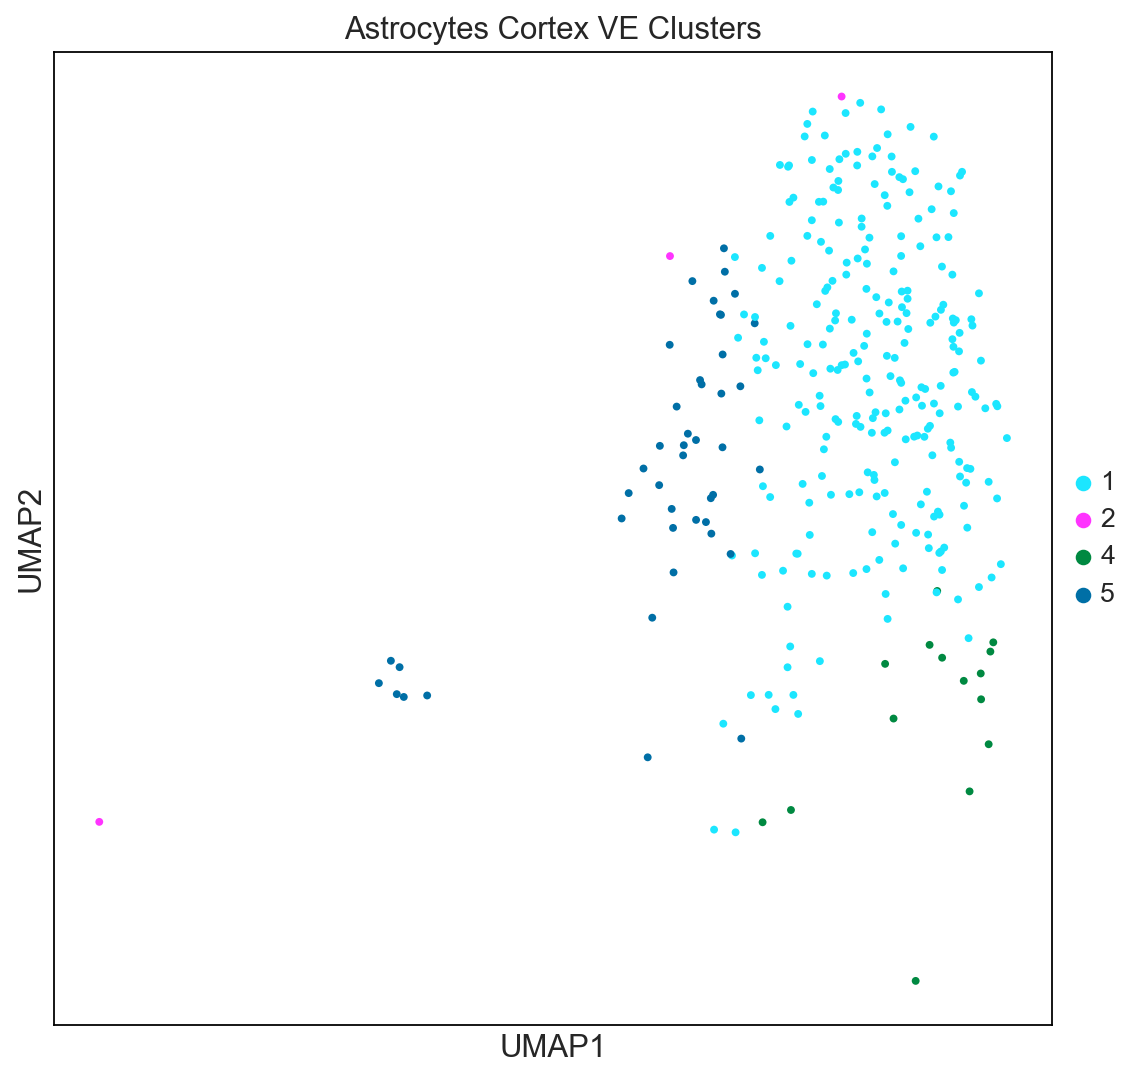

In [116]:
adata_astro_cortex_VE = adata_astro_cortex[adata_astro_cortex.obs['Condition'].isin(['VE']),:].copy()

sc.set_figure_params(figsize=(8, 8))
sc.pl.umap(adata_astro_cortex_VE, 
           color= ['PhenoGraph_clusters_astro'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette= ["#1CE6FF", "#FF34FF", "#008941", "#006FA6"],
           size=50, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Astrocytes Cortex VE Clusters"])

In [117]:
cell_counts_per_cluster_cortex_VE = adata_astro_cortex_VE.obs.PhenoGraph_clusters_astro.value_counts()
cell_counts_per_cluster_cortex_VE = cell_counts_per_cluster_cortex_VE.to_frame()
cell_counts_per_cluster_cortex_VE

PhenoGraph_clusters_astro
1                        252
5                         44
4                         15
2                          3

### Heatmaps of gene expression

In [57]:
marker_genes_dict = dict()

marker_genes_dict = {'Astro-Cortex':['PDE10A',
'FKBP5',
'CCND3',
'MAT2A',
'TTYH1',
'ZBTB16',
'PRKCA',
'CDH19',
'ASIC2',
'HNRNPA2B1',
'GALNT18',
'GABBR2',
'NRG1',
'CLMN',
'CYP4F15',
'SLC24A4',
'MDGA2',
'NEAT1',
'GPATCH8']}





categories: Astro0_Control, Astro1_Control, Astro1_VE, etc.
var_group_labels: Astro-Cortex


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  __ = ax.pcolor(_color_df, **kwds)


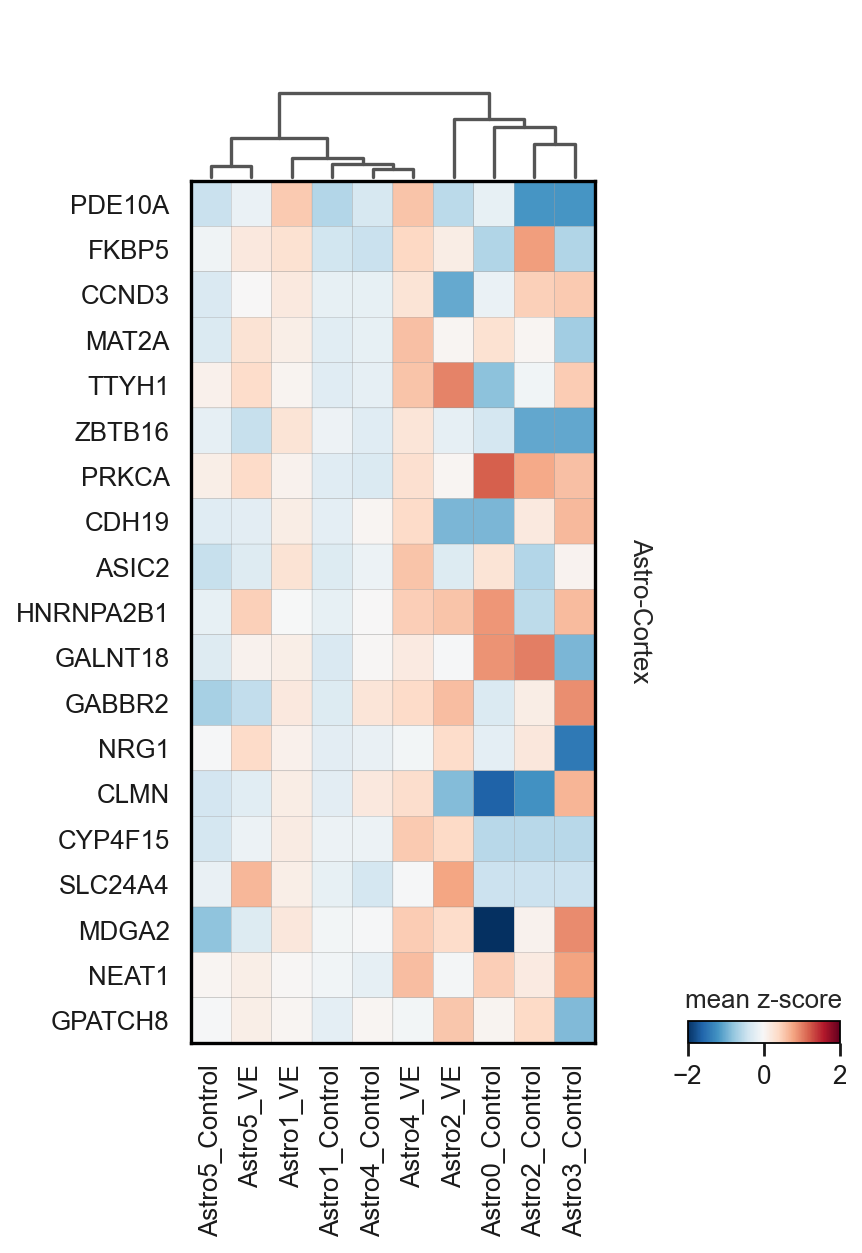

categories: Astro0_Control, Astro1_Control, Astro1_VE, etc.
var_group_labels: Astro-Cortex


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


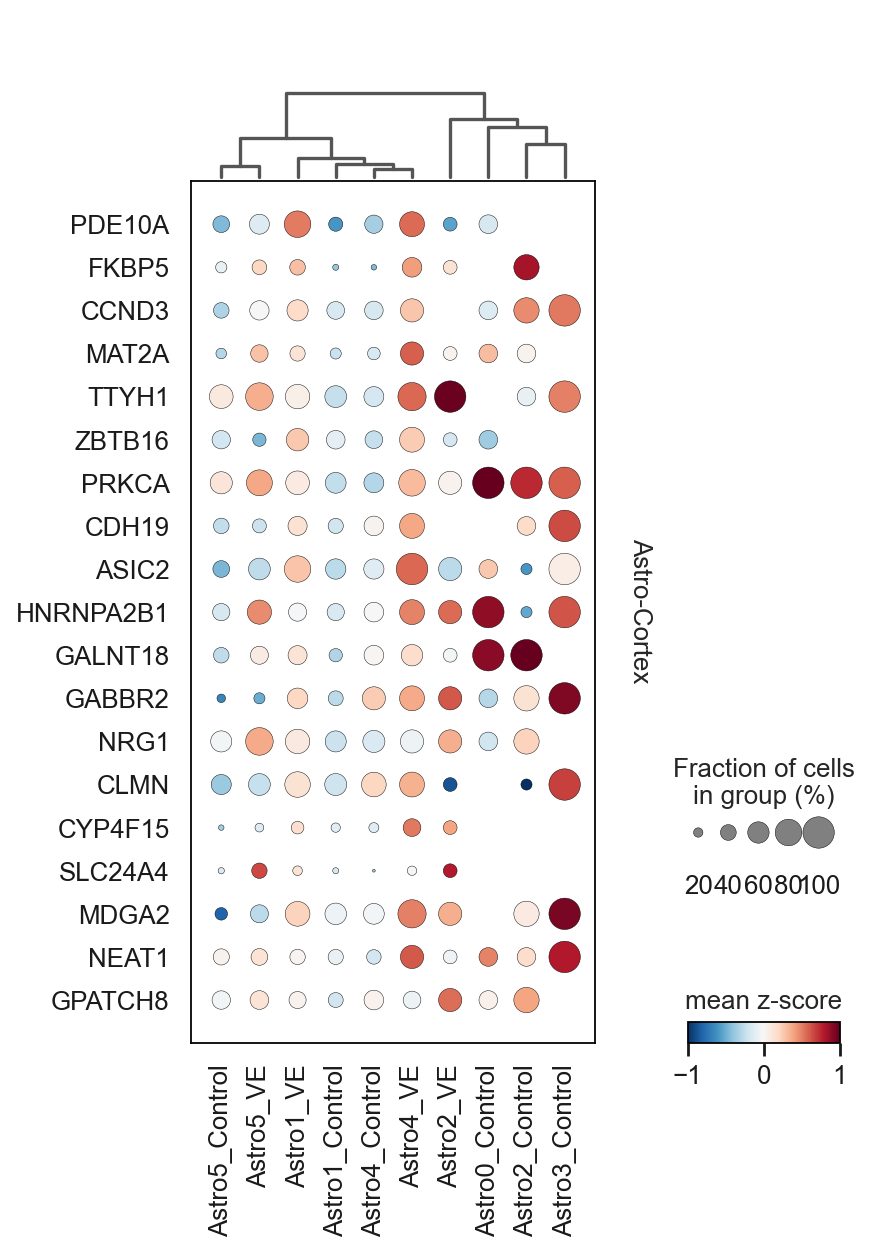

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


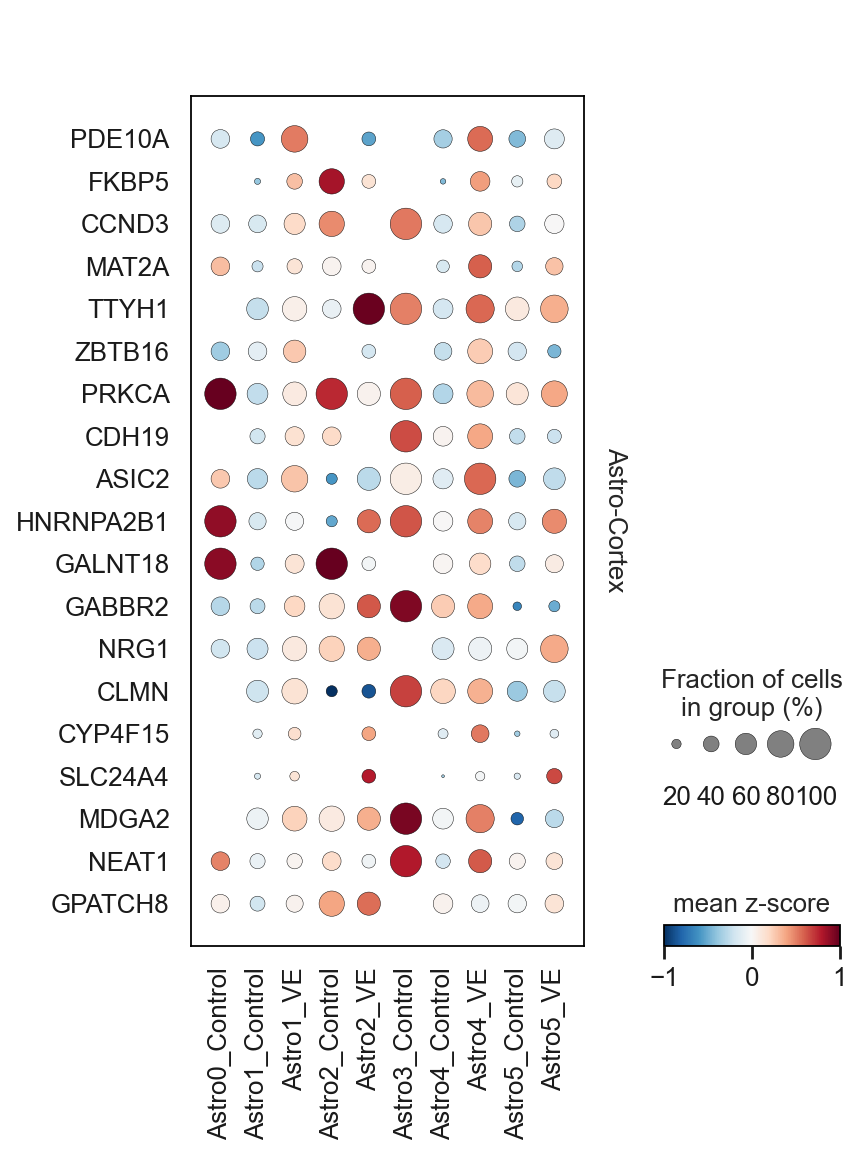

In [58]:
adata_astro_cortex.layers['scaled'] = sc.pp.scale(adata_astro_cortex, copy=True).X
sc.pl.matrixplot(adata_astro_cortex, marker_genes_dict, groupby=['PhenoGraph_clusters_astro_str','Condition'], dendrogram=True,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_astro_cortex, marker_genes_dict, groupby=['PhenoGraph_clusters_astro_str','Condition'], dendrogram=True,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_astro_cortex, marker_genes_dict, groupby=['PhenoGraph_clusters_astro_str','Condition'], dendrogram=False,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

### Make a grouped bar plot of the number of cells per cluster per condition

**Brainstem**

In [62]:
# First merge the 2 data frames by indeces
mergedDF= cell_counts_per_cluster_BS_ctrl.merge(cell_counts_per_cluster_BS_VE, left_index=True, right_index=True, suffixes=('_Control', '_VE'), how = 'outer')
mergedDF.rename(columns = {'PhenoGraph_clusters_astro_Control' : 'Control', 'PhenoGraph_clusters_astro_VE' : 'VE'}, inplace = True)
mergedDF

Control   VE
0    271.0  209
1      NaN    1
2    143.0  168
3     70.0  170
5      5.0    2

In [63]:
mergedDF = mergedDF.reset_index()
mergedDF = mergedDF.melt(id_vars=["index"])
mergedDF.rename(columns = {'index' : 'ClusterID', 'variable' : 'Condition', 'value' : 'N_cells'}, inplace = True)
mergedDF

ClusterID Condition  N_cells
0          0   Control    271.0
1          1   Control      NaN
2          2   Control    143.0
3          3   Control     70.0
4          5   Control      5.0
5          0        VE    209.0
6          1        VE      1.0
7          2        VE    168.0
8          3        VE    170.0
9          5        VE      2.0

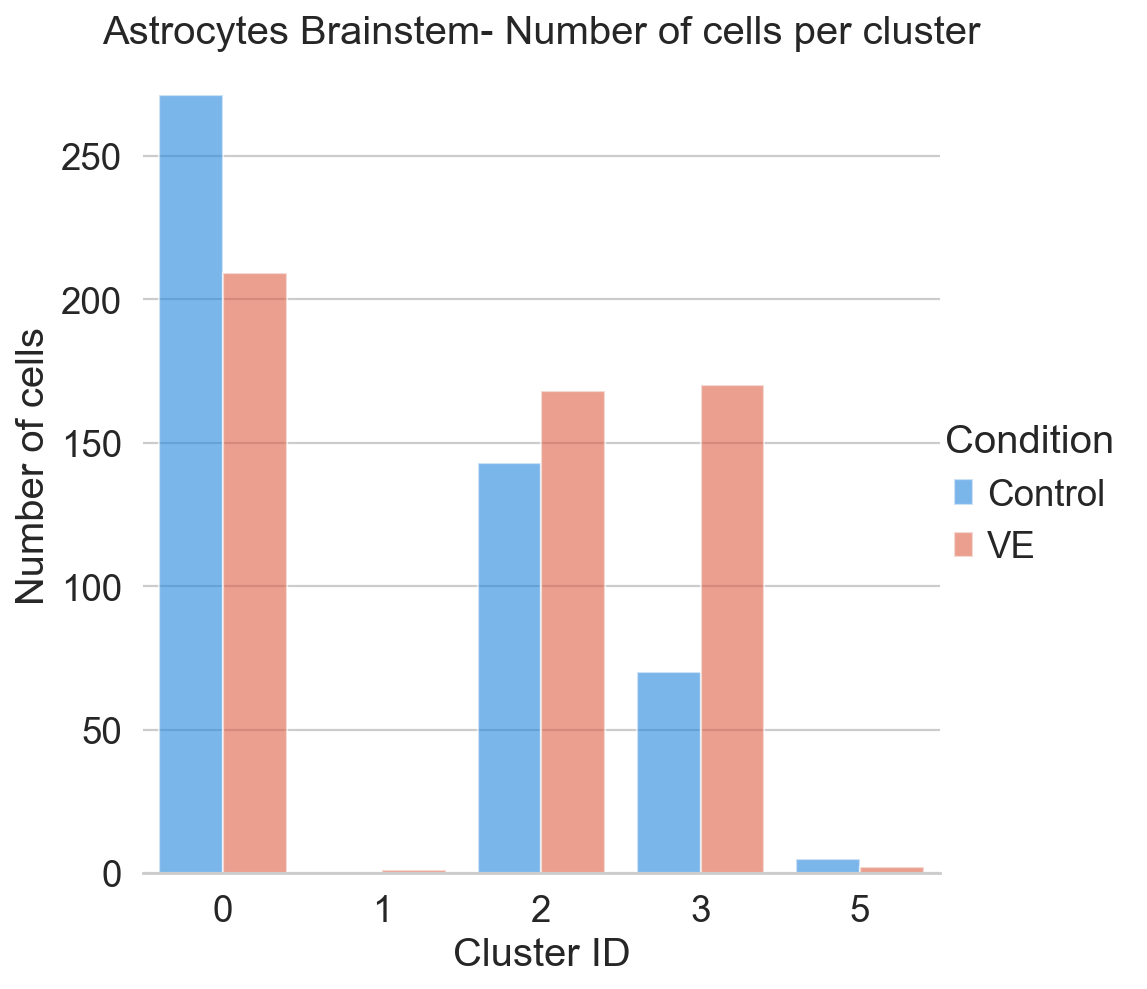

In [64]:
sns.set(font_scale=1.5, style = 'whitegrid') 
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=mergedDF, kind="bar",
    x="ClusterID", y="N_cells", hue="Condition",
    ci="sd", palette=['#0488FC','#F64E2C'], alpha=.6, height=6
)
g.despine(left=True)
g.set(title='Astrocytes Brainstem- Number of cells per cluster')
g.set_axis_labels("Cluster ID", "Number of cells")

**Cortex**

In [124]:
# First merge the 2 data frames by indeces
mergedDF_2= cell_counts_per_cluster_cortex_ctrl.merge(cell_counts_per_cluster_cortex_VE, left_index=True, right_index=True, suffixes=('_Control', '_VE'), how = 'outer')
mergedDF_2.rename(columns = {'PhenoGraph_clusters_astro_Control' : 'Control', 'PhenoGraph_clusters_astro_VE' : 'VE'}, inplace = True)
mergedDF_2

Control     VE
0        2    NaN
1      116  252.0
2        4    3.0
3        1    NaN
4      101   15.0
5       51   44.0

In [125]:
mergedDF_2 = mergedDF_2.reset_index()
mergedDF_2 = mergedDF_2.melt(id_vars=["index"])
mergedDF_2.rename(columns = {'index' : 'ClusterID', 'variable' : 'Condition', 'value' : 'N_cells'}, inplace = True)
mergedDF_2

ClusterID Condition  N_cells
0           0   Control      2.0
1           1   Control    116.0
2           2   Control      4.0
3           3   Control      1.0
4           4   Control    101.0
5           5   Control     51.0
6           0        VE      NaN
7           1        VE    252.0
8           2        VE      3.0
9           3        VE      NaN
10          4        VE     15.0
11          5        VE     44.0

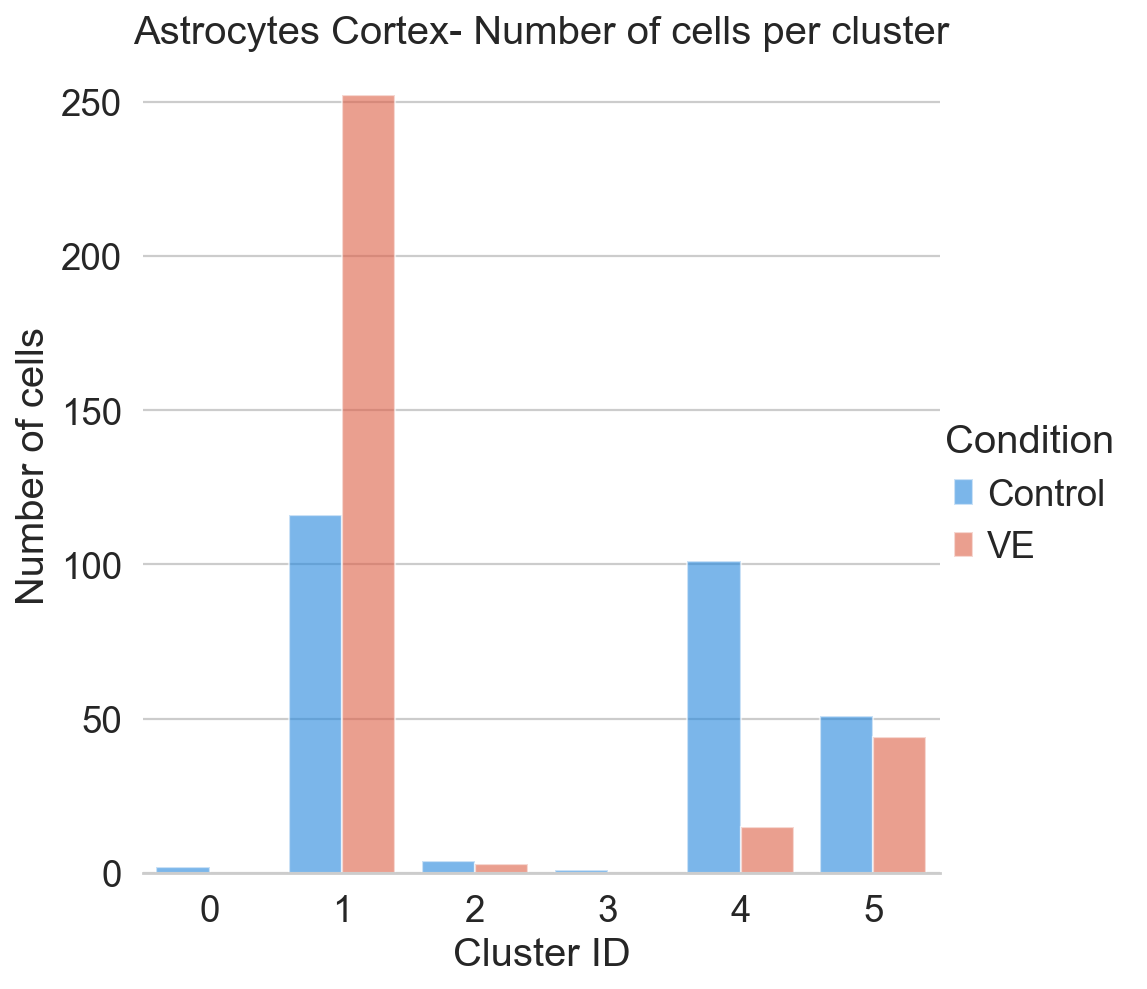

In [126]:
sns.set(font_scale=1.5, style = 'whitegrid') 
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=mergedDF_2, kind="bar",
    x="ClusterID", y="N_cells", hue="Condition",
    ci="sd", palette=['#0488FC','#F64E2C'], alpha=.6, height=6
)
g.despine(left=True)
g.set(title='Astrocytes Cortex- Number of cells per cluster')
g.set_axis_labels("Cluster ID", "Number of cells")

## Brainstem - Tests markers between specific clusters  

In [ ]:
sc.pl.violin(adata_astro_BS, ['FKBP5','CACNA2D3','SGCD','NELL2','APOE','CST3'], groupby='PhenoGraph_clusters_astro', inner='point', palette = godsnot_64, )

## Compare Clusters 0 (VE) Versus All Controls

### T-test 

In [15]:
adata_astro_BS_copy = adata_astro_BS.copy()
# For loop creating a groups for pairwise comparison
adata_astro_BS_copy.obs['groups'] = ['group_0VE' if int(i) in [0] and j == 'VE' else 'group_restCTRL' if j == 'Control' else 'Error' for i,j in zip(adata_astro_BS_copy.obs['PhenoGraph_clusters_astro'],adata_astro_BS_copy.obs['Condition'] )]

In [16]:
adata_astro_BS_copy.obs.groups.value_counts()

group_restCTRL    489
Error             341
group_0VE         209
Name: groups, dtype: int64

In [17]:
adata_astro_BS_copy.obs[['groups','PhenoGraph_clusters_astro','PhenoGraph_clusters_astro_str','Condition']]

groups  \
cell_barcodes                                                       
227295685654444_1822_996_VE_ES_BS_IGO_10875_7               Error   
196500616763310_1820_C1029_Ctrl_ES_BS_IGO_10856_3  group_restCTRL   
121887371450286_1822_996_VE_ES_BS_IGO_10875_7           group_0VE   
121812496571299_1820_C1029_Ctrl_ES_BS_IGO_10856_3  group_restCTRL   
166425395129070_1820_C1029_Ctrl_ES_BS_IGO_10856_3  group_restCTRL   
...                                                           ...   
135504954617190_1822_996_VE_ES_BS_IGO_10875_7               Error   
135143806323499_1822_996_VE_ES_BS_IGO_10875_7           group_0VE   
130615032072628_1822_996_VE_ES_BS_IGO_10875_7               Error   
161943443626339_1822_996_VE_ES_BS_IGO_10875_7           group_0VE   
227929308122548_1822_996_VE_ES_BS_IGO_10875_7               Error   

                                                  PhenoGraph_clusters_astro  \
cell_barcodes                                                                 
227295685654444_1822_996_VE_ES_BS_IGO_10875_7                             2   
196500616763310_1820_C1029_Ctrl_ES_BS_IGO_10856_3                         2   
121887371450286_1822_996_VE_ES_BS_IGO_10875_7                             0   
121812496571299_1820_C1029_Ctrl_ES_BS_IGO_10856_3                         0   
166425395129070_1820_C1029_Ctrl_ES_BS_IGO_10856_3                         3   
...                                                                     ...   
135504954617190_1822_996_VE_ES_BS_IGO_10875_7                             3   
135143806323499_1822_996_VE_ES_BS_IGO_10875_7                             0   
130615032072628_1822_996_VE_ES_BS_IGO_10875_7                             3   
161943443626339_1822_996_VE_ES_BS_IGO_10875_7                             0   
227929308122548_1822_996_VE_ES_BS_IGO_10875_7                             2   

                                                  PhenoGraph_clusters_astro_str  \
cell_barcodes                                                                     
227295685654444_1822_996_VE_ES_BS_IGO_10875_7                            Astro2   
196500616763310_1820_C1029_Ctrl_ES_BS_IGO_10856_3                        Astro2   
121887371450286_1822_996_VE_ES_BS_IGO_10875_7                            Astro0   
121812496571299_1820_C1029_Ctrl_ES_BS_IGO_10856_3                        Astro0   
166425395129070_1820_C1029_Ctrl_ES_BS_IGO_10856_3                        Astro3   
...                                                                         ...   
135504954617190_1822_996_VE_ES_BS_IGO_10875_7                            Astro3   
135143806323499_1822_996_VE_ES_BS_IGO_10875_7                            Astro0   
130615032072628_1822_996_VE_ES_BS_IGO_10875_7                            Astro3   
161943443626339_1822_996_VE_ES_BS_IGO_10875_7                            Astro0   
227929308122548_1822_996_VE_ES_BS_IGO_10875_7                            Astro2   

                                                  Condition  
cell_barcodes                                                
227295685654444_1822_996_VE_ES_BS_IGO_10875_7            VE  
196500616763310_1820_C1029_Ctrl_ES_BS_IGO_10856_3   Control  
121887371450286_1822_996_VE_ES_BS_IGO_10875_7            VE  
121812496571299_1820_C1029_Ctrl_ES_BS_IGO_10856_3   Control  
166425395129070_1820_C1029_Ctrl_ES_BS_IGO_10856_3   Control  
...                                                     ...  
135504954617190_1822_996_VE_ES_BS_IGO_10875_7            VE  
135143806323499_1822_996_VE_ES_BS_IGO_10875_7            VE  
130615032072628_1822_996_VE_ES_BS_IGO_10875_7            VE  
161943443626339_1822_996_VE_ES_BS_IGO_10875_7            VE  
227929308122548_1822_996_VE_ES_BS_IGO_10875_7            VE  

[1039 rows x 4 columns]

In [18]:
# select only cells that are in these 2 groups that I want to compare
adata_astro_BS_to_compare = adata_astro_BS_copy[[group in ['group_restCTRL', 'group_0VE'] for group in adata_astro_BS_copy.obs['groups']],].copy()
adata_astro_BS_to_compare.obs.groups.value_counts()

/Users/fragkogs/miniconda3/envs/std/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


group_restCTRL    489
group_0VE         209
Name: groups, dtype: int64

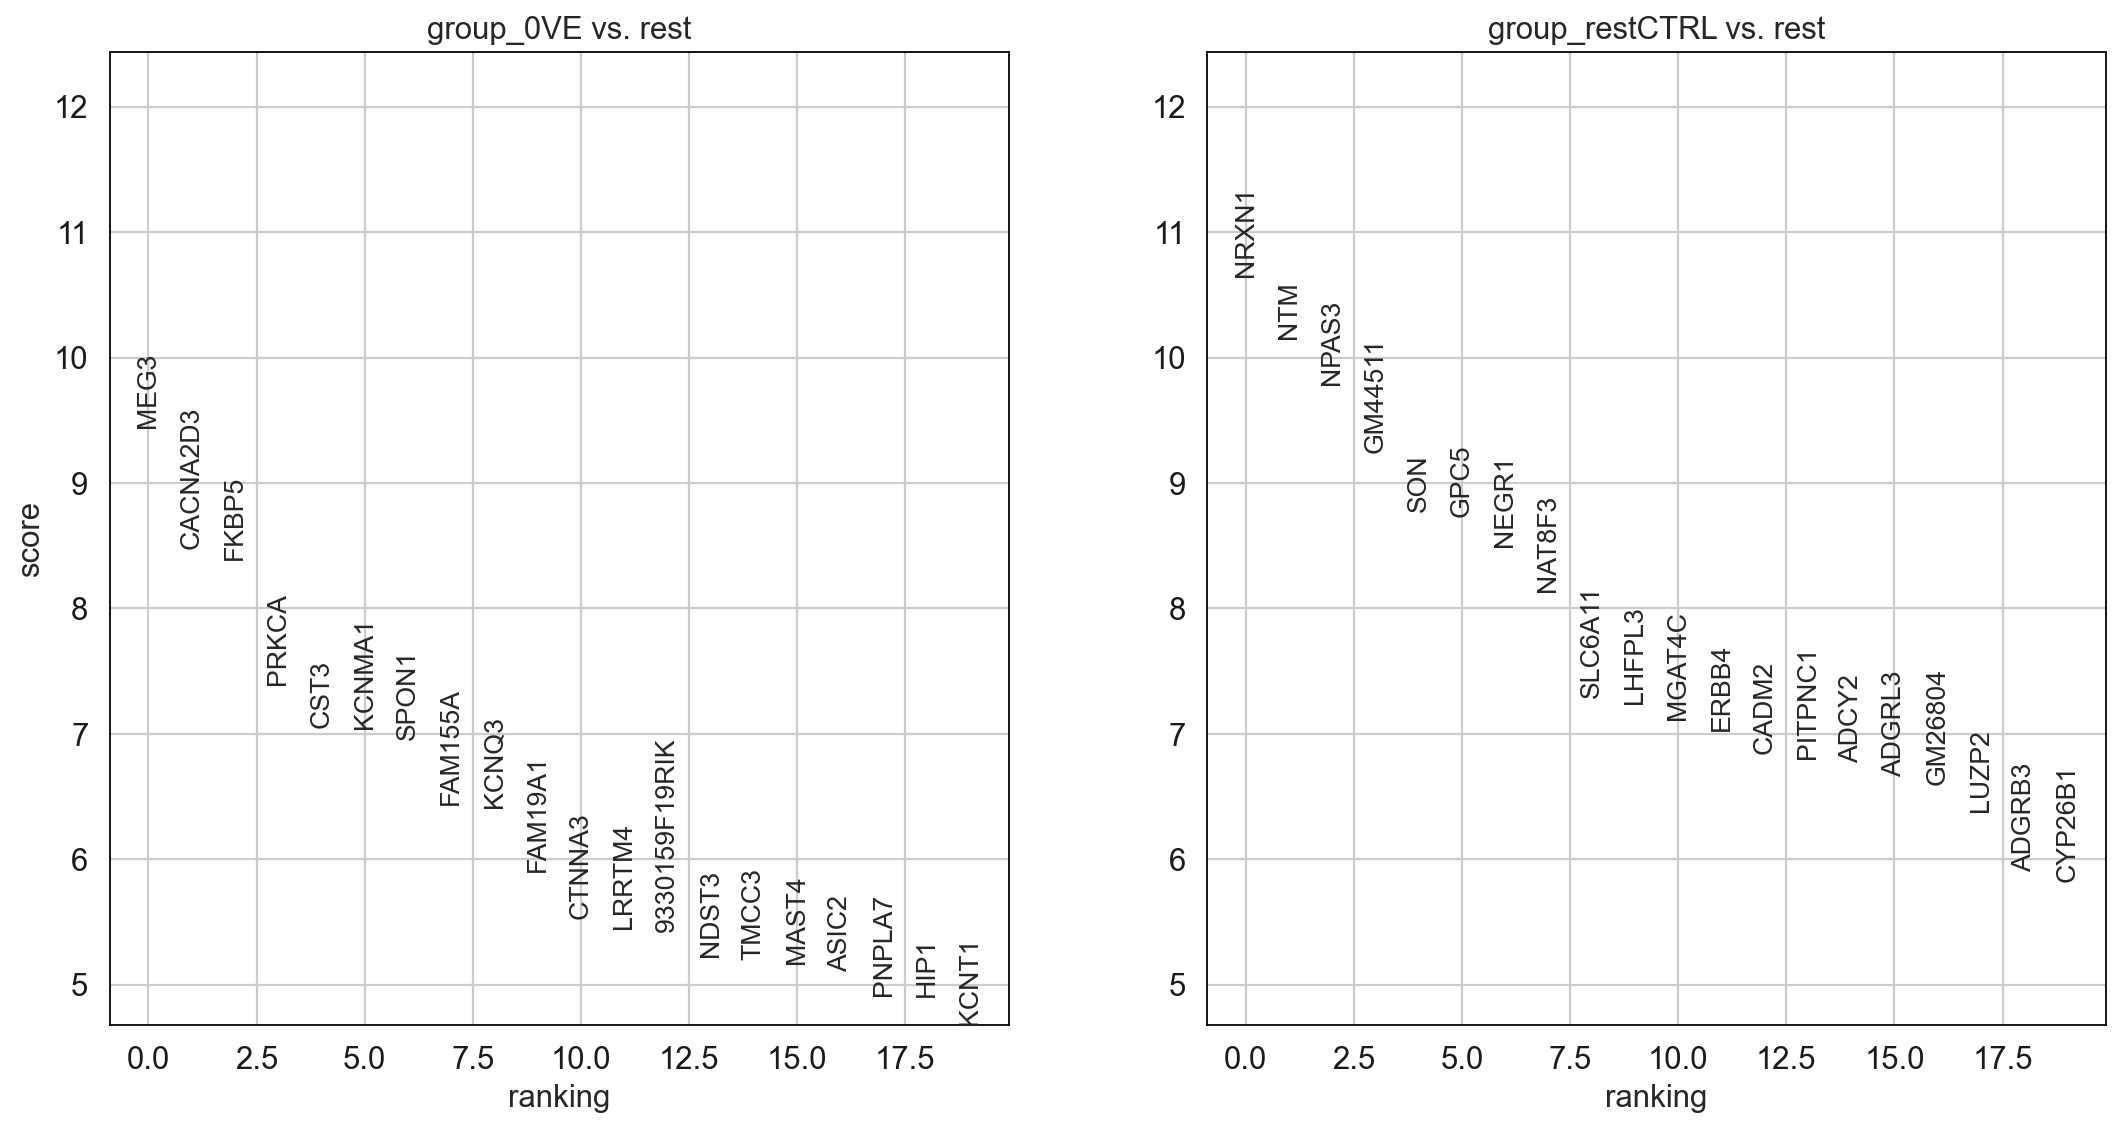

In [20]:
sc.set_figure_params(figsize=(8, 8))
key_ad = 'group_0VE'
n_genes = 100000

sc.tl.rank_genes_groups(adata_astro_BS_to_compare, groupby='groups', key_added="group_0VE", method='wilcoxon')
sc.pl.rank_genes_groups(adata_astro_BS_to_compare, key = 'group_0VE', fontsize=12)

result = adata_astro_BS_to_compare.uns[key_ad]
groups = result['names'].dtype.names
pval_table = pd.DataFrame(
        {group + '_' + key[:1]: result[key][group]
        for group in groups for key in ['names','logfoldchanges', 'pvals_adj']}).head(n_genes)
#pval_table.to_excel(os.path.join("/Users/fragkogs/Desktop/", key_ad + '_' + method + '_pval_table_' + '_clusters_' + str(n_genes) + 'genes_filtered_corrected.xlsx'), engine='openpyxl')

In [22]:
pval_table = pval_table.sort_values(by= 'group_0VE_l', ascending=False)
pval_table[(pval_table.group_0VE_p < 0.05) & (pval_table.group_0VE_l > 0.5)].head(10)

group_0VE_n  group_0VE_l   group_0VE_p group_restCTRL_n  group_restCTRL_l  \
2        FKBP5     3.816759  6.260192e-14            NPAS3          0.789302   
1     CACNA2D3     2.608358  3.247333e-14              NTM          0.816953   
23       NELL2     2.091727  1.589111e-03            PCDH9          0.436101   
46       NTNG1     1.880068  4.694209e-02         MIR9-3HG          1.483039   
10      CTNNA3     1.842839  1.258250e-05           MGAT4C          1.566073   
7      FAM155A     1.825310  6.017398e-08           NAT8F3          2.900069   
37          HR     1.578596  2.181789e-02            ACSL6          1.414619   
19       KCNT1     1.545768  6.046426e-04          CYP26B1          2.975211   
13       NDST3     1.527569  4.939256e-05          PITPNC1          1.166890   
39       KLHL2     1.526418  2.495190e-02            NTRK3          1.318524   

    group_restCTRL_p  
2       5.659373e-19  
1       2.131612e-20  
23      1.589694e-05  
46      1.328243e-03  
10      9.410883e-10  
7       4.645623e-13  
37      3.380067e-04  
19      2.372179e-06  
13      6.285966e-09  
39      6.299998e-04

### MAST 

In [24]:
cell_type = 'Astrocytes_C0'
expmat = pd.DataFrame(adata_astro_BS_to_compare.X, columns = adata_astro_BS_to_compare.var.index, index = adata_astro_BS_to_compare.obs.index)
cdata = pd.DataFrame(adata_astro_BS_to_compare.obs, columns=adata_astro_BS_to_compare.obs.columns, index = adata_astro_BS_to_compare.obs.index)
expmat.to_csv(r'DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv', index=True)
cdata.to_csv(r'DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv', index=True)

In [27]:
start_time = timeit.default_timer()
MAST = './runMAST_clusters.R'
expmat_Inputfile = ('DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv')
cdata_Inputfile = ('DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv')
output_file_cort = 'DEA/' +  cell_type + "/MAST_DEA_" + cell_type + "_RESULTS.csv" 

os.system(MAST + " " + expmat_Inputfile + " " + cdata_Inputfile + " " + output_file_cort + " " )
out_str = "Finished running MAST on"+ "( " + cell_type +  ")" +" in {} seconds.".format(timeit.default_timer()-start_time)

In [28]:
# import the MAST results
mast_C0_res = pd.read_csv (filepath_or_buffer= 'DEA/Astrocytes_C0/MAST_DEA_Astrocytes_C0_RESULTS.csv')
print(mast_C0_res)

           gene             p     p.fdr.adj     logFC
0         FKBP5  1.820227e-33  2.248526e-29  1.822691
1           NTM  1.228170e-22  7.585791e-19 -0.553209
2         NPAS3  1.703492e-18  7.014413e-15 -0.504426
3           SON  2.664398e-18  8.228326e-15 -0.800906
4      CACNA2D3  5.473403e-16  1.352259e-12  1.567951
...         ...           ...           ...       ...
12348   ZSCAN12  9.558758e-01  1.000000e+00 -0.001790
12349    ZSCAN2  9.598090e-01  1.000000e+00 -0.005046
12350   ZSCAN20  9.539021e-01  1.000000e+00 -0.000831
12351   ZSCAN25  9.820175e-01  1.000000e+00 -0.003782
12352    ZSWIM3  9.150855e-01  1.000000e+00 -0.018908

[12353 rows x 4 columns]


In [192]:
#filter DE results
mast_C0_res = mast_C0_res.sort_values(by='logFC', ascending=False)
# Upregulated genes
mast_C0_res_UP = mast_C0_res[(mast_C0_res['logFC'] >=0.01) & (mast_C0_res['p.fdr.adj'] <= 0.05)]
mast_C0_res_DOWN = mast_C0_res[(mast_C0_res['logFC'] <=0.01) & (mast_C0_res['p.fdr.adj'] <= 0.05)]
mast_C0_res_UP['gene'].head(20)

0              FKBP5
4           CACNA2D3
24           FAM155A
10             NDST3
40            CTNNA3
23             KCNQ3
21           FAM19A1
12            KCNMA1
11             PRKCA
13             NELL2
39    X9330159F19RIK
54             PDGFD
34             CCND3
32           SLC24A4
51            LRRTM4
20             SPON1
46             ROBO2
31            PNPLA7
29             KCNT1
38              HIP1
Name: gene, dtype: object

#### HEATMAP OF TOP10 UPREGULATED GENES

In [197]:
genes_to_plot =  mast_C0_res_UP['gene'].head(20)
genes_to_plot = genes_to_plot.drop([39])
genes_to_plot

0        FKBP5
4     CACNA2D3
24     FAM155A
10       NDST3
40      CTNNA3
23       KCNQ3
21     FAM19A1
12      KCNMA1
11       PRKCA
13       NELL2
54       PDGFD
34       CCND3
32     SLC24A4
51      LRRTM4
20       SPON1
46       ROBO2
31      PNPLA7
29       KCNT1
38        HIP1
Name: gene, dtype: object

/Users/fragkogs/miniconda3/envs/std/lib/python3.8/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  __ = ax.pcolor(_color_df, **kwds)


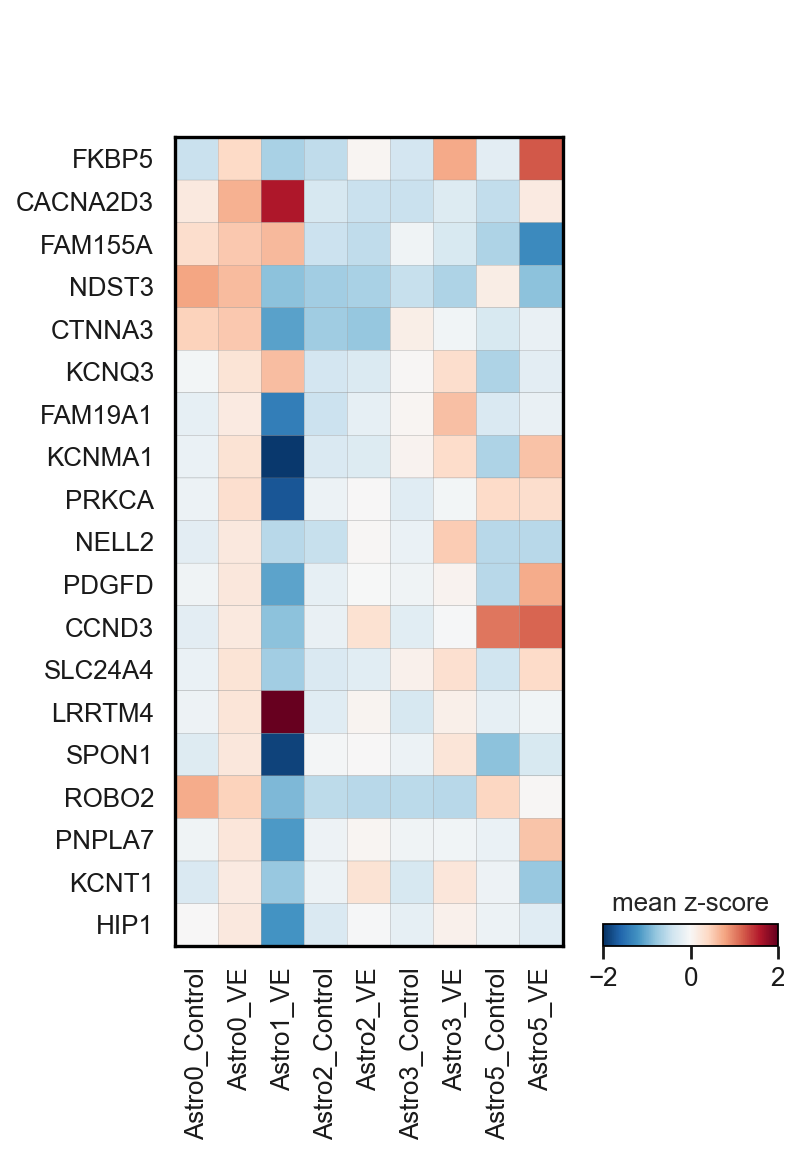

"sc.pl.dotplot(adata_astro_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_astro_str','Condition'], dendrogram=True,\n             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)\n\nsc.pl.dotplot(adata_astro_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_astro_str','Condition'], dendrogram=False,\n             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)\n"

In [213]:
adata_astro_BS.layers['scaled'] = sc.pp.scale(adata_astro_BS, copy=True).X
sc.pl.matrixplot(adata_astro_BS, genes_to_plot, groupby=['PhenoGraph_clusters_astro_str','Condition'], dendrogram=False,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r',swap_axes=True)

'''sc.pl.dotplot(adata_astro_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_astro_str','Condition'], dendrogram=True,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_astro_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_astro_str','Condition'], dendrogram=False,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)
'''

#### Enricher

In [151]:
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
import gseapy
gene_set_names = gseapy.get_library_name(database='Mouse')
#print(gene_set_names)

mast_C0_res_n_list = mast_C0_res_UP.gene.str.strip().tolist()
enr_res = gseapy.enrichr(gene_list=mast_C0_res_n_list,
                     organism='Mouse',
                     gene_sets=['KEGG_2019_Mouse'],
                     description='pathway',
                     cutoff = 0.5)

In [152]:
enr_res.results.head(20)

Gene_set                                               Term Overlap  \
0   Reactome_2016  PLC beta mediated events Homo sapiens R-HSA-11...    4/44   
1   Reactome_2016             cGMP effects Homo sapiens R-HSA-418457    3/18   
2   Reactome_2016  G-protein mediated events Homo sapiens R-HSA-1...    4/45   
3   Reactome_2016  Nitric oxide stimulates guanylate cyclase Homo...    3/25   
4   Reactome_2016            Ca2+ pathway Homo sapiens R-HSA-4086398    4/61   
5   Reactome_2016  Acetylcholine regulates insulin secretion Homo...    2/10   
6   Reactome_2016        Opioid Signalling Homo sapiens R-HSA-111885    4/81   
7   Reactome_2016      Cardiac conduction Homo sapiens R-HSA-5576891   5/135   
8   Reactome_2016      Collagen formation Homo sapiens R-HSA-1474290    4/85   
9   Reactome_2016  Phase 0 - rapid depolarisation Homo sapiens R-...    3/44   
10  Reactome_2016  Depolarization of the Presynaptic Terminal Tri...    2/13   
11  Reactome_2016        Signaling by PDGF Homo sapiens R-HSA-186797   8/364   
12  Reactome_2016         Signaling by Wnt Homo sapiens R-HSA-195721   7/295   
13  Reactome_2016          Neuronal System Homo sapiens R-HSA-112316   7/301   
14  Reactome_2016  Assembly of collagen fibrils and other multime...    3/54   
15  Reactome_2016   Developmental Biology Homo sapiens R-HSA-1266738  12/786   
16  Reactome_2016  Downstream signal transduction Homo sapiens R-...   7/341   
17  Reactome_2016  Collagen biosynthesis and modifying enzymes Ho...    3/63   
18  Reactome_2016     Innate Immune System Homo sapiens R-HSA-168249  12/807   
19  Reactome_2016         DAP12 signaling Homo sapiens R-HSA-2424491   7/344   

     P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0   0.000231          0.036272            0                     0   14.904511   
1   0.000238          0.036272            0                     0   29.623881   
2   0.000252          0.036272            0                     0   14.540253   
3   0.000648          0.069777            0                     0   20.190977   
4   0.000813          0.070044            0                     0   10.450336   
5   0.002022          0.128528            0                     0   36.768519   
6   0.002332          0.128528            0                     0    7.728152   
7   0.002386          0.128528            0                     0    5.749709   
8   0.002779          0.131002            0                     0    7.345029   
9   0.003392          0.131002            0                     0   10.823808   
10  0.003458          0.131002            0                     0   26.736700   
11  0.003647          0.131002            0                     0    3.398136   
12  0.004266          0.141449            0                     0    3.659856   
13  0.004757          0.146441            0                     0    3.584066   
14  0.006044          0.173670            0                     0    8.697103   
15  0.007847          0.205111            0                     0    2.367628   
16  0.009187          0.205111            0                     0    3.148388   
17  0.009255          0.205111            0                     0    7.389179   
18  0.009560          0.205111            0                     0    2.302551   
19  0.009611          0.205111            0                     0    3.119881   

    Combined Score                                              Genes  
0       124.780511                            GNAO1;ITPR1;PRKCA;PLCB1  
1       247.165070                                PDE10A;KCNMA1;ITPR1  
2       120.454368                            GNAO1;ITPR1;PRKCA;PLCB1  
3       148.247409                                PDE10A;KCNMA1;ITPR1  
4        74.357242                            GNAO1;ITPR1;PRKCA;PLCB1  
5       228.099526                                        PRKCA;PLCB1  
6        46.841876                            GNAO1;ITPR1;PRKCA;PLCB1  
7        34.718307                 CAMK2D;CACNB4;C

#### GSEA pre-rank

In [82]:
mast_C0_res = mast_C0_res.dropna()
pval_table_rnk = mast_C0_res[['gene','logFC','p.fdr.adj']]

rank_score = pval_table_rnk['logFC'] * -np.log10(pval_table_rnk['p.fdr.adj'])
rank_score
pval_table_rnk['score'] = rank_score

In [83]:
pval_table_rnk = pval_table_rnk.sort_values(by= 'score', ascending=False)
pval_table_rnk = pval_table_rnk[['gene', 'score']]
pval_table_rnk.head(15)

gene      score
0      FKBP5  52.216630
4   CACNA2D3  18.609917
10     NDST3   9.467896
11     PRKCA   7.680131
12    KCNMA1   7.468628
24   FAM155A   7.095637
13     NELL2   6.830420
21   FAM19A1   6.209756
23     KCNQ3   6.153473
20     SPON1   5.251777
15      MEG3   5.194420
40    CTNNA3   4.866606
32   SLC24A4   4.393601
34     CCND3   4.242364
31    PNPLA7   4.112266

In [86]:
pre_res = gseapy.prerank(rnk=pval_table_rnk, 
                     gene_sets='WikiPathways_2019_Mouse',
                     processes=4,
                     permutation_num=100, # reduce number to speed up testing
                     outdir='test/prerank_report_kegg', format='png', seed=6, graph_num=5)

In [ ]:
pre_res.res2d.sort_index().head(n=25).sort_values('fdr')

## Compare Clusters 2 (VE) Versus All Controls

### T-test

In [137]:
adata_astro_BS_copy = adata_astro_BS.copy()
# For loop creating a groups for pairwise comparison
adata_astro_BS_copy.obs['groups'] = ['group_2VE' if int(i) in [2] and j == 'VE' else 'group_restCTRL' if j == 'Control' else 'Error' for i,j in zip(adata_astro_BS_copy.obs['PhenoGraph_clusters_astro'],adata_astro_BS_copy.obs['Condition'] )]

In [138]:
adata_astro_BS_copy.obs.groups.value_counts()

group_restCTRL    489
Error             382
group_2VE         168
Name: groups, dtype: int64

In [139]:
#adata_astro_BS_copy.obs[['groups','PhenoGraph_clusters_astro','PhenoGraph_clusters_astro_str','Condition']]

In [140]:
# select only cells that are in these 2 groups that I want to compare
adata_astro_BS_to_compare = adata_astro_BS_copy[[group in ['group_restCTRL', 'group_2VE'] for group in adata_astro_BS_copy.obs['groups']],].copy()
adata_astro_BS_to_compare.obs.groups.value_counts()

/Users/fragkogs/miniconda3/envs/std/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


group_restCTRL    489
group_2VE         168
Name: groups, dtype: int64

/Users/fragkogs/miniconda3/envs/std/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'groups' as categorical


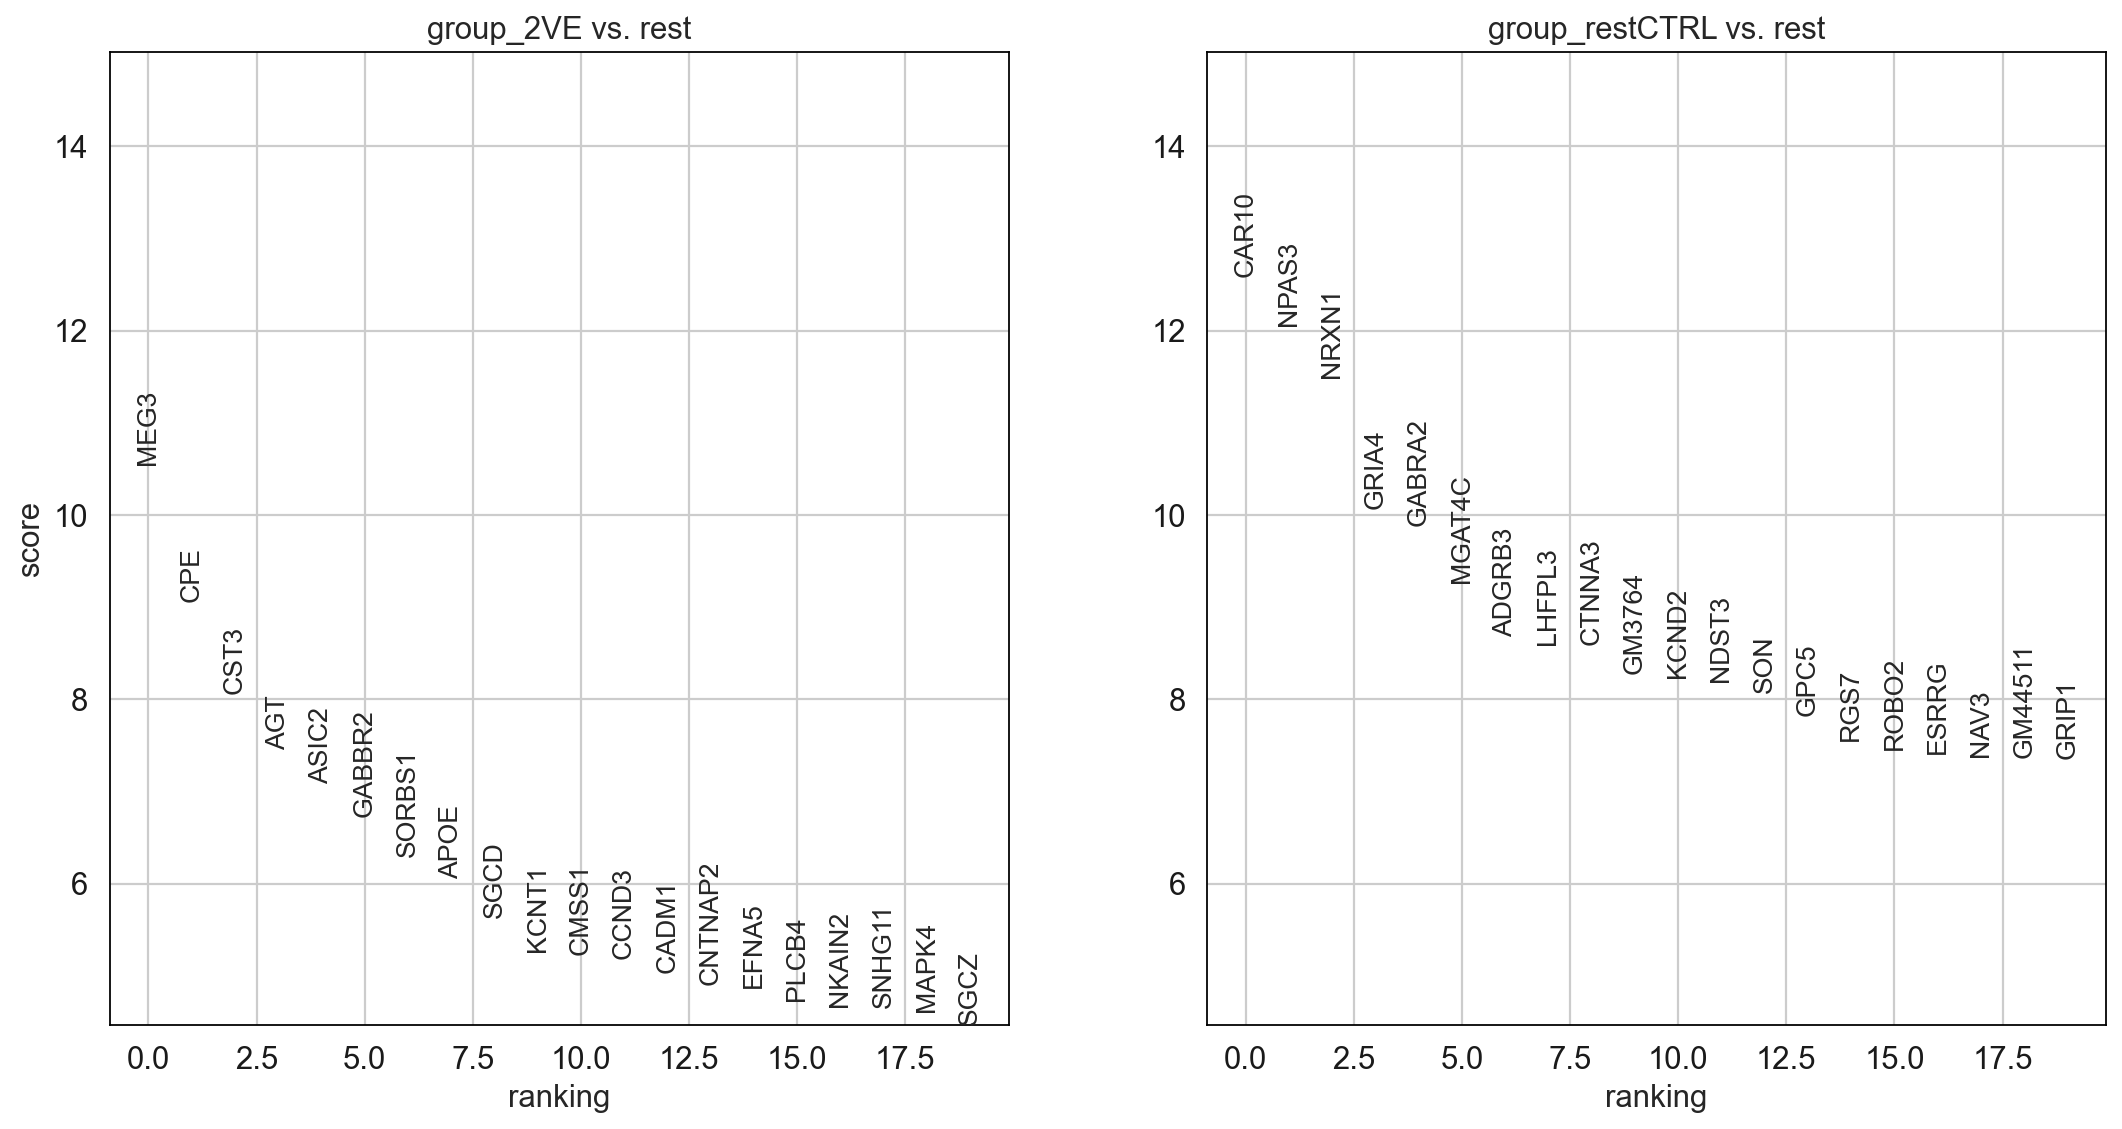

In [141]:
key_ad = 'group_2VE'
n_genes = 100000

sc.tl.rank_genes_groups(adata_astro_BS_to_compare, groupby='groups', key_added="group_2VE", method='wilcoxon')
sc.pl.rank_genes_groups(adata_astro_BS_to_compare, key = 'group_2VE', fontsize=12)

result = adata_astro_BS_to_compare.uns[key_ad]
groups = result['names'].dtype.names
pval_table = pd.DataFrame(
        {group + '_' + key[:1]: result[key][group]
        for group in groups for key in ['names','logfoldchanges', 'pvals_adj']}).head(n_genes)
#pval_table.to_excel(os.path.join("/Users/fragkogs/Desktop/", key_ad + '_' + method + '_pval_table_' + '_clusters_' + str(n_genes) + 'genes_filtered_corrected.xlsx'), engine='openpyxl')

In [101]:
pval_table = pval_table.sort_values(by= 'group_2VE_l', ascending=False)
pval_table[(pval_table.group_2VE_p < 0.05) & (pval_table.group_2VE_l > 0.5)].head(5)

group_2VE_n  group_2VE_l   group_2VE_p group_restCTRL_n  group_restCTRL_l  \
8         SGCD     2.592858  4.123219e-06           CTNNA3          3.855451   
21       FKBP5     2.571410  1.428861e-03             CHL1          2.542031   
14       EFNA5     2.504786  1.547904e-04             RGS7          2.595471   
5       GABBR2     2.129421  6.510555e-09           MGAT4C          2.198024   
9        KCNT1     1.904079  2.749127e-05           GM3764          1.071483   

    group_restCTRL_p  
8       9.730297e-15  
21      6.524623e-10  
14      2.868155e-11  
5       3.430787e-17  
9       1.296597e-13

### MAST 

In [102]:
cell_type = 'Astrocytes_C2'
expmat = pd.DataFrame(adata_astro_BS_to_compare.X, columns = adata_astro_BS_to_compare.var.index, index = adata_astro_BS_to_compare.obs.index)
cdata = pd.DataFrame(adata_astro_BS_to_compare.obs, columns=adata_astro_BS_to_compare.obs.columns, index = adata_astro_BS_to_compare.obs.index)
expmat.to_csv(r'DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv', index=True)
cdata.to_csv(r'DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv', index=True)

In [103]:
start_time = timeit.default_timer()
MAST = './runMAST_clusters.R'
expmat_Inputfile = ('DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv')
cdata_Inputfile = ('DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv')
output_file_cort = 'DEA/' +  cell_type + "/MAST_DEA_" + cell_type + "_RESULTS.csv" 

os.system(MAST + " " + expmat_Inputfile + " " + cdata_Inputfile + " " + output_file_cort + " " )
out_str = "Finished running MAST on"+ "( " + cell_type +  ")" +" in {} seconds.".format(timeit.default_timer()-start_time)

In [142]:
# import the MAST results
mast_C2_res = pd.read_csv (filepath_or_buffer= 'DEA/Astrocytes_C2/MAST_DEA_Astrocytes_C2_RESULTS.csv')
print(mast_C2_res)

         gene             p     p.fdr.adj     logFC
0       CAR10  3.258273e-22  4.024945e-18 -2.168772
1       NPAS3  7.938098e-22  4.902966e-18 -0.659521
2         CPE  2.659060e-15  1.094912e-11  1.305739
3      CTNNA3  3.590142e-14  8.869806e-11 -1.990467
4        SGCD  3.159363e-14  8.869806e-11  1.468913
...       ...           ...           ...       ...
12348  ZSWIM3  7.881331e-01  1.000000e+00  0.008682
12349  ZSWIM4  6.948266e-01  1.000000e+00 -0.011821
12350   ZUFSP  7.009817e-01  1.000000e+00 -0.037320
12351    ZXDB  7.506364e-01  1.000000e+00 -0.025064
12352     ZYX  6.554206e-01  1.000000e+00  0.046204

[12353 rows x 4 columns]


In [175]:
#filter DE results
mast_C2_res = mast_C2_res.sort_values(by='logFC', ascending=False)
# Upregulated genes
mast_C2_res_UP = mast_C2_res[(mast_C2_res['logFC'] >=0.01) & (mast_C2_res['p.fdr.adj'] <= 0.05)]
mast_C2_res_DOWN = mast_C2_res[(mast_C2_res['logFC'] <=0.01) & (mast_C2_res['p.fdr.adj'] <= 0.05)]
#mast_C0_res_UP['gene'].head(20)
mast_C2_res_UP.head(10)

gene             p     p.fdr.adj     logFC
4     SGCD  3.159363e-14  8.869806e-11  1.468913
2      CPE  2.659060e-15  1.094912e-11  1.305739
13   EFNA5  4.621293e-11  4.077631e-08  1.257238
25  GABBR2  1.070068e-07  5.084059e-05  1.143929
9    FKBP5  1.147312e-11  1.417275e-08  1.140097
47   CCND3  4.141928e-06  1.052771e-03  0.966486
52   RGS20  7.925466e-06  1.847232e-03  0.961493
35   AIFM3  5.550779e-07  1.904688e-04  0.955428
44  SPIRE1  2.832686e-06  7.840295e-04  0.937436
18   KCNT1  8.420913e-09  5.474923e-06  0.927667

In [174]:
mast_C2_res.shape

(12353, 4)

#### HEATMAP OF TOP10 UPREGULATED GENES

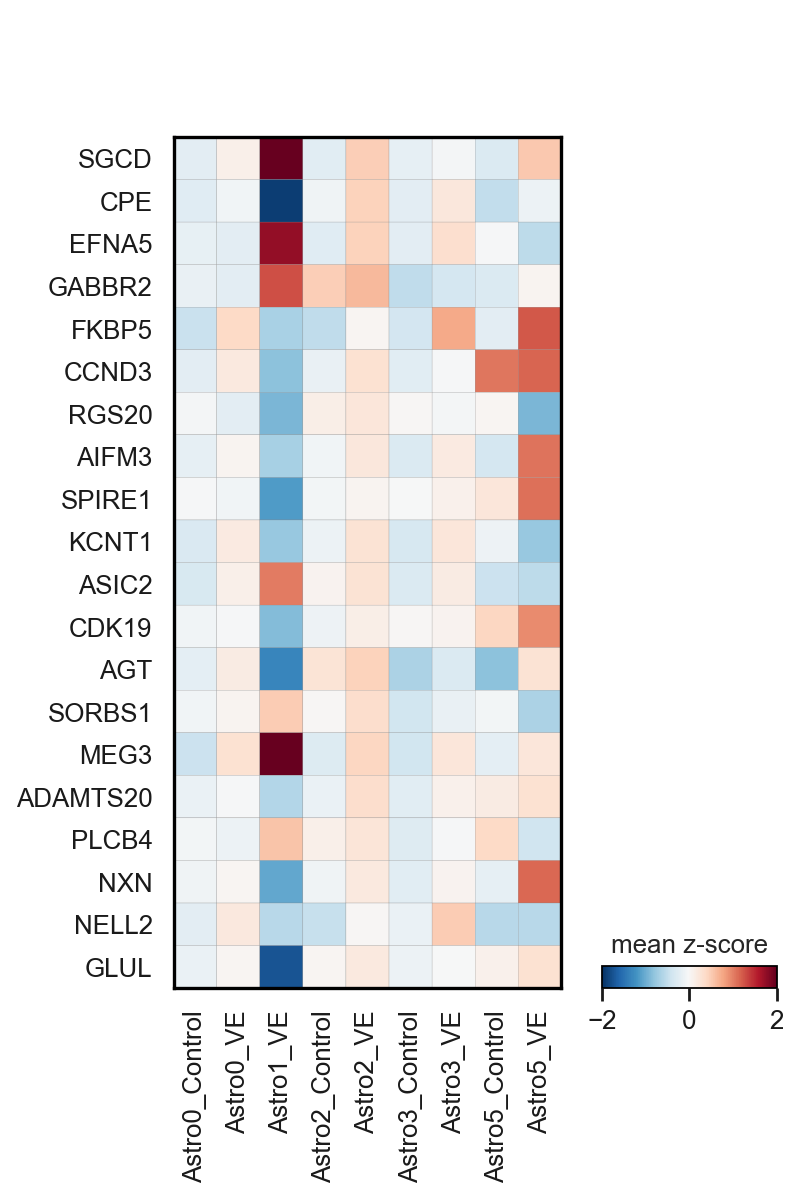

"sc.pl.dotplot(adata_astro_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_astro_str','Condition'], dendrogram=True,\n             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)\n\nsc.pl.dotplot(adata_astro_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_astro_str','Condition'], dendrogram=False,\n             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)\n"

In [214]:
genes_to_plot =  mast_C2_res_UP['gene'].head(20)
adata_astro_BS.layers['scaled'] = sc.pp.scale(adata_astro_BS, copy=True).X
sc.pl.matrixplot(adata_astro_BS, genes_to_plot, groupby=['PhenoGraph_clusters_astro_str','Condition'], dendrogram=False,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r',swap_axes=True)

'''sc.pl.dotplot(adata_astro_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_astro_str','Condition'], dendrogram=True,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_astro_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_astro_str','Condition'], dendrogram=False,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)
'''

#### Enricher

In [149]:
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
import gseapy
gene_set_names = gseapy.get_library_name(database='Mouse')
#print(gene_set_names)

mast_C2_res_n_list = mast_C2_res_UP.gene.str.strip().tolist()
enr_res = gseapy.enrichr(gene_list=mast_C2_res_n_list,
                     organism='Mouse',
                     gene_sets=['KEGG_2019_Mouse'],
                     description='pathway',
                     cutoff = 0.5)

In [150]:
enr_res.results.head(20)

Gene_set                                               Term  \
0   KEGG_2019_Mouse                                   Cushing syndrome   
1   KEGG_2019_Mouse                              Wnt signaling pathway   
2   KEGG_2019_Mouse                   Cortisol synthesis and secretion   
3   KEGG_2019_Mouse                                      Melanogenesis   
4   KEGG_2019_Mouse                                 Pathways in cancer   
5   KEGG_2019_Mouse                  Thyroid hormone signaling pathway   
6   KEGG_2019_Mouse                         Estrogen signaling pathway   
7   KEGG_2019_Mouse                             Long-term potentiation   
8   KEGG_2019_Mouse                     Human papillomavirus infection   
9   KEGG_2019_Mouse             Adrenergic signaling in cardiomyocytes   
10  KEGG_2019_Mouse                             Gastric acid secretion   
11  KEGG_2019_Mouse                            Hippo signaling pathway   
12  KEGG_2019_Mouse                                    Renin secretion   
13  KEGG_2019_Mouse                                 Salivary secretion   
14  KEGG_2019_Mouse                                  GABAergic synapse   
15  KEGG_2019_Mouse  AGE-RAGE signaling pathway in diabetic complic...   
16  KEGG_2019_Mouse                Aldosterone synthesis and secretion   
17  KEGG_2019_Mouse                         Glucagon signaling pathway   
18  KEGG_2019_Mouse          Chagas disease (American trypanosomiasis)   
19  KEGG_2019_Mouse  Parathyroid hormone synthesis, secretion and a...   

   Overlap   P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0    6/159  0.000023          0.001579            0                     0   
1    6/160  0.000024          0.001579            0                     0   
2     4/69  0.000112          0.004883            0                     0   
3    4/100  0.000466          0.015275            0                     0   
4    8/535  0.000663          0.017241            0                     0   
5    4/115  0.000790          0.017241            0                     0   
6    4/134  0.001393          0.026076            0                     0   
7     3/67  0.001817          0.026246            0                     0   
8    6/360  0.001877          0.026246            0                     0   
9    4/148  0.002005          0.026246            0                     0   
10    3/74  0.002415          0.026246            0                     0   
11   4/159  0.002601          0.026246            0                     0   
12    3/76  0.002605          0.026246            0                     0   
13    3/78  0.002805          0.026246            0                     0   
14    3/90  0.004200          0.036684            0                     0   
15   3/101  0.005793          0.042171            0                     0   
16   3/102  0.005953          0.042171            0                     0   
17   3/102  0.005953          0.042171            0                     0   
18   3/103  0.006116          0.042171            0                     0   
19   3/107  0.006795          0.044506            0                     0   

    Odds Ratio  Combined Score                                         Genes  
0    11.749851      125.350879             CDKN1A;FZD2;PLCB4;PLCB1;KCNK2;AGT  
1    11.672963      124.117436           CCND3;CREBBP;FZD2;PLCB4;DAAM2;PLCB1  
2    17.975566      163.550563                         PLCB4;PLCB1;KCNK2;AGT  
3    12.151961       93.210592                       CREBBP;FZD2;PLCB4;PLCB1  
4     4.601755       33.681313  CCND3;CREBBP;CDKN1A;FZD2;PLCB4;DCC;PLCB1;AGT  
5    10.501855       75.024248                      CREBBP;NCOR1;PLCB4;PLCB1  
6     8.958371       58.910335                      GABBR2;PLCB4;PLCB1;FKBP5  
7    13.494565       85.159430                            CREBBP;PLCB4;PLCB1  
8     5.026708       31.557445         CCND3;CREBBP;CDKN1A;FZD2;DLG2;PPP2R2B  
9     8.081699       50.203056                  

## Compare Clusters 3 (VE) Versus All Controls

### T-test

In [153]:
adata_astro_BS_copy = adata_astro_BS.copy()
# For loop creating a groups for pairwise comparison
adata_astro_BS_copy.obs['groups'] = ['group_3VE' if int(i) in [3] and j == 'VE' else 'group_restCTRL' if j == 'Control' else 'Error' for i,j in zip(adata_astro_BS_copy.obs['PhenoGraph_clusters_astro'],adata_astro_BS_copy.obs['Condition'] )]

In [154]:
adata_astro_BS_copy.obs.groups.value_counts()

group_restCTRL    489
Error             380
group_3VE         170
Name: groups, dtype: int64

In [156]:
#adata_astro_BS_copy.obs[['groups','PhenoGraph_clusters_astro','PhenoGraph_clusters_astro_str','Condition']]

In [157]:
# select only cells that are in these 2 groups that I want to compare
adata_astro_BS_to_compare = adata_astro_BS_copy[[group in ['group_restCTRL', 'group_3VE'] for group in adata_astro_BS_copy.obs['groups']],].copy()
adata_astro_BS_to_compare.obs.groups.value_counts()

/Users/fragkogs/miniconda3/envs/std/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


group_restCTRL    489
group_3VE         170
Name: groups, dtype: int64

/Users/fragkogs/miniconda3/envs/std/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'groups' as categorical


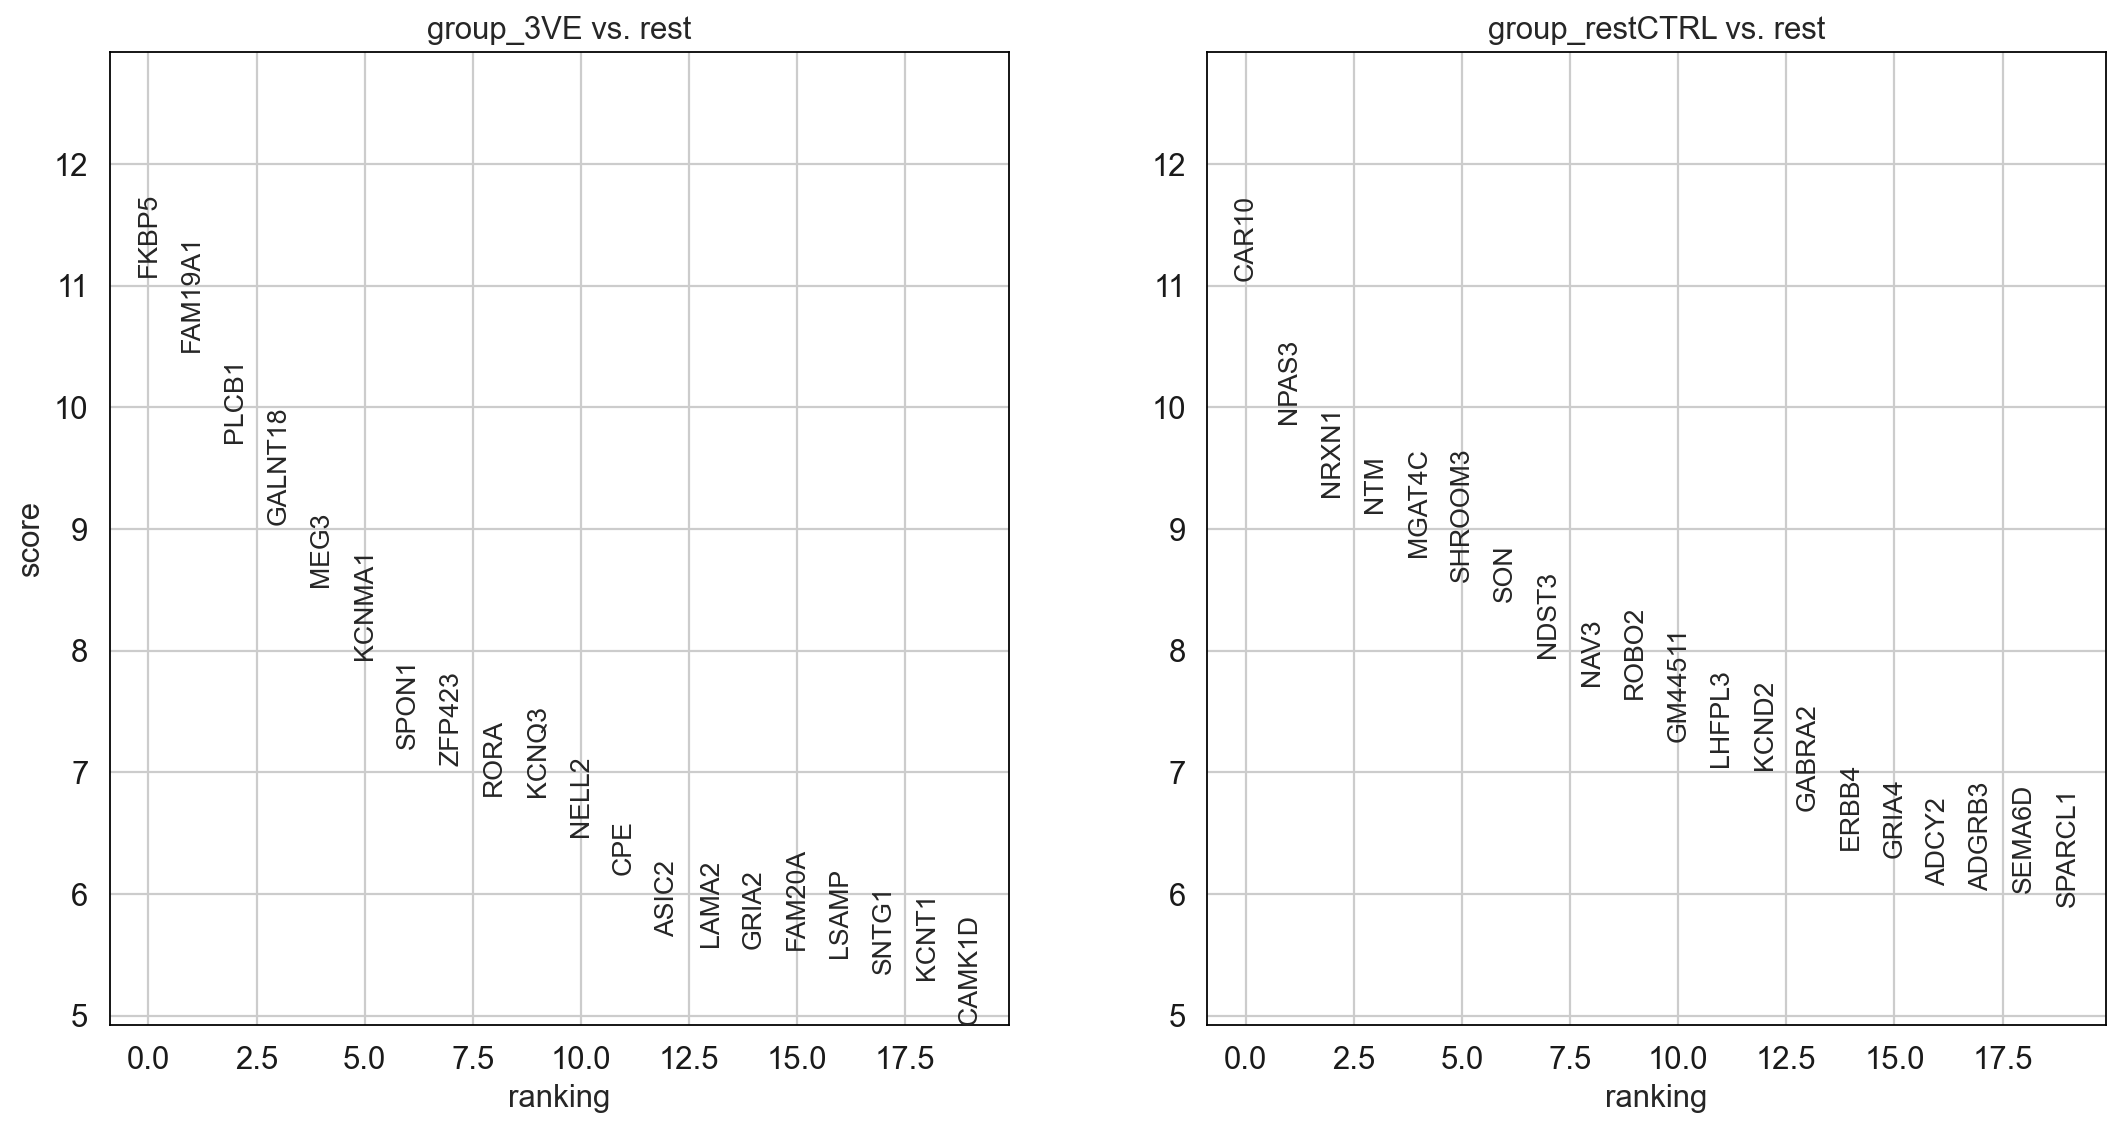

In [158]:
key_ad = 'group_3VE'
n_genes = 100000

sc.tl.rank_genes_groups(adata_astro_BS_to_compare, groupby='groups', key_added="group_3VE", method='wilcoxon')
sc.pl.rank_genes_groups(adata_astro_BS_to_compare, key = 'group_3VE', fontsize=12)

result = adata_astro_BS_to_compare.uns[key_ad]
groups = result['names'].dtype.names
pval_table = pd.DataFrame(
        {group + '_' + key[:1]: result[key][group]
        for group in groups for key in ['names','logfoldchanges', 'pvals_adj']}).head(n_genes)
#pval_table.to_excel(os.path.join("/Users/fragkogs/Desktop/", key_ad + '_' + method + '_pval_table_' + '_clusters_' + str(n_genes) + 'genes_filtered_corrected.xlsx'), engine='openpyxl')

In [159]:
pval_table = pval_table.sort_values(by= 'group_3VE_l', ascending=False)
pval_table[(pval_table.group_3VE_p < 0.05) & (pval_table.group_3VE_l > 0.5)].head(5)

group_3VE_n  group_3VE_l   group_3VE_p group_restCTRL_n  group_restCTRL_l  \
0        FKBP5     4.860847  1.524320e-24            CAR10          3.251353   
10       NELL2     2.991720  4.918536e-08          GM44511          2.358288   
1      FAM19A1     2.942048  5.407589e-22            NPAS3          0.972577   
3      GALNT18     2.449935  2.518006e-16              NTM          0.816330   
30      PDE10A     2.185052  3.628947e-03            NTRK3          1.438843   

    group_restCTRL_p  
0       1.524320e-24  
10      3.085181e-10  
1       1.768081e-19  
3       1.154206e-16  
30      9.744495e-06

### MAST 

In [160]:
cell_type = 'Astrocytes_C3'
expmat = pd.DataFrame(adata_astro_BS_to_compare.X, columns = adata_astro_BS_to_compare.var.index, index = adata_astro_BS_to_compare.obs.index)
cdata = pd.DataFrame(adata_astro_BS_to_compare.obs, columns=adata_astro_BS_to_compare.obs.columns, index = adata_astro_BS_to_compare.obs.index)
expmat.to_csv(r'DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv', index=True)
cdata.to_csv(r'DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv', index=True)

In [161]:
start_time = timeit.default_timer()
MAST = './runMAST_clusters.R'
expmat_Inputfile = ('DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv')
cdata_Inputfile = ('DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv')
output_file_cort = 'DEA/' +  cell_type + "/MAST_DEA_" + cell_type + "_RESULTS.csv" 

os.system(MAST + " " + expmat_Inputfile + " " + cdata_Inputfile + " " + output_file_cort + " " )
out_str = "Finished running MAST on"+ "( " + cell_type +  ")" +" in {} seconds.".format(timeit.default_timer()-start_time)

In [163]:
# import the MAST results
mast_C3_res = pd.read_csv (filepath_or_buffer= 'DEA/Astrocytes_C3/MAST_DEA_Astrocytes_C3_RESULTS.csv')
print(mast_C3_res)

          gene             p     p.fdr.adj     logFC
0        FKBP5  4.007852e-44  4.950899e-40  2.389266
1      FAM19A1  5.321293e-25  3.286697e-21  2.013370
2        PLCB1  7.468804e-24  3.075405e-20  0.814824
3        CAR10  2.574642e-21  7.951137e-18 -1.816398
4        NELL2  1.043363e-19  2.577733e-16  1.524109
...        ...           ...           ...       ...
12348     ZW10  4.522352e-01  1.000000e+00 -0.089233
12349    ZWINT  9.883839e-01  1.000000e+00 -0.015899
12350     ZXDB  9.699402e-01  1.000000e+00 -0.007717
12351      ZYX  9.066548e-01  1.000000e+00  0.011155
12352     ZZZ3  4.494283e-01  1.000000e+00 -0.151070

[12353 rows x 4 columns]


In [176]:
#filter DE results
mast_C3_res = mast_C3_res.sort_values(by='logFC', ascending=False)
# Upregulated genes
mast_C3_res_UP = mast_C3_res[(mast_C3_res['logFC'] >=0.01) & (mast_C3_res['p.fdr.adj'] <= 0.05)]
mast_C3_res_DOWN = mast_C3_res[(mast_C3_res['logFC'] <=0.01) & (mast_C3_res['p.fdr.adj'] <= 0.05)]
mast_C3_res_UP.head(10)

gene             p     p.fdr.adj     logFC
0     FKBP5  4.007852e-44  4.950899e-40  2.389266
1   FAM19A1  5.321293e-25  3.286697e-21  2.013370
8   GALNT18  1.259151e-16  1.728255e-13  1.572466
4     NELL2  1.043363e-19  2.577733e-16  1.524109
13   ZFP423  5.430792e-13  4.791898e-10  1.314427
29    SNTG1  2.326049e-09  9.577893e-07  1.269928
21    KCNQ3  1.187852e-10  6.669790e-08  1.176299
10   KCNMA1  9.387782e-15  1.054248e-11  1.161047
22    EFNA5  1.722969e-10  9.253840e-08  1.087224
49    RCAN2  3.680308e-07  9.092570e-05  1.029420

In [166]:
mast_C3_res_UP.shape

(87, 4)

#### HEATMAP OF TOP10 UPREGULATED GENES

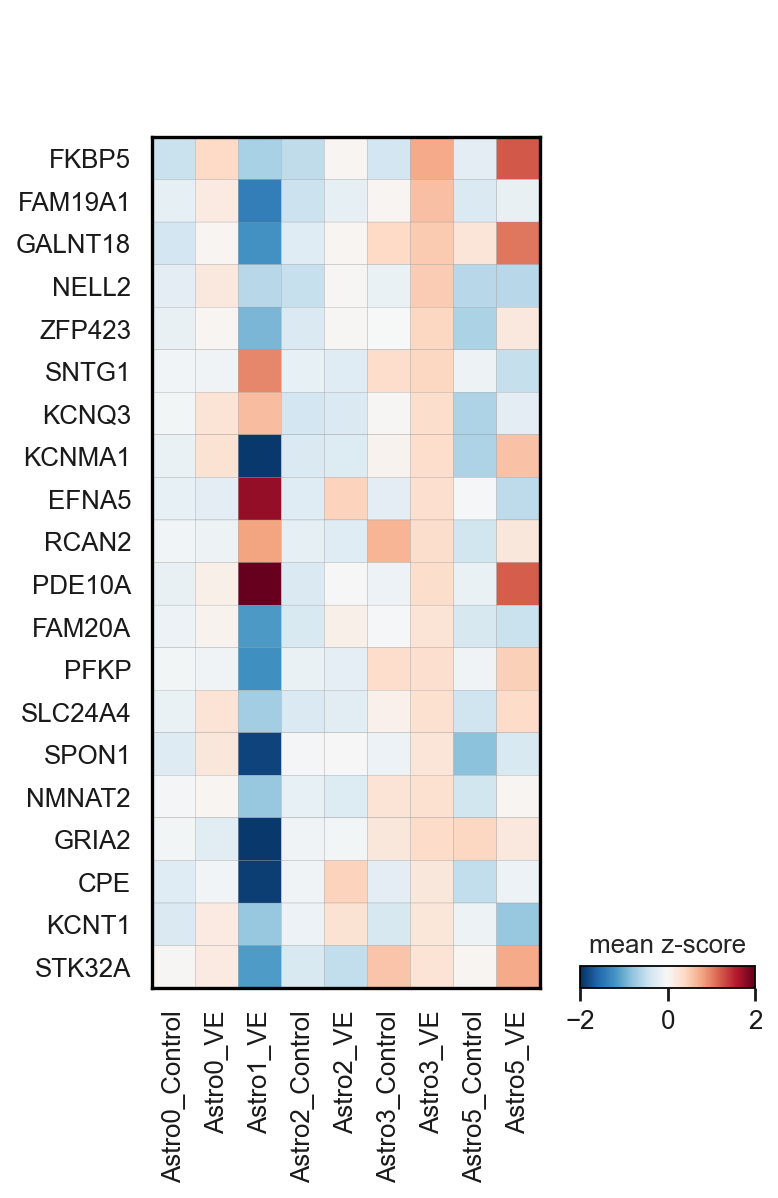

"sc.pl.dotplot(adata_astro_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_astro_str','Condition'], dendrogram=True,\n             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)\n\nsc.pl.dotplot(adata_astro_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_astro_str','Condition'], dendrogram=False,\n             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)\n"

In [216]:
genes_to_plot =  mast_C3_res_UP['gene'].head(20)
adata_astro_BS.layers['scaled'] = sc.pp.scale(adata_astro_BS, copy=True).X
sc.pl.matrixplot(adata_astro_BS, genes_to_plot, groupby=['PhenoGraph_clusters_astro_str','Condition'], dendrogram=False,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r',swap_axes=True)

'''sc.pl.dotplot(adata_astro_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_astro_str','Condition'], dendrogram=True,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_astro_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_astro_str','Condition'], dendrogram=False,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)
'''

#### Enricher

In [167]:
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
import gseapy
gene_set_names = gseapy.get_library_name(database='Mouse')
#print(gene_set_names)

mast_C3_res_n_list = mast_C3_res_UP.gene.str.strip().tolist()
enr_res = gseapy.enrichr(gene_list=mast_C3_res_n_list,
                     organism='Mouse',
                     gene_sets=['KEGG_2019_Mouse'],
                     description='pathway',
                     cutoff = 0.5)

In [168]:
enr_res.results.head(20)

Gene_set                                   Term Overlap   P-value  \
0   KEGG_2019_Mouse      Thyroid hormone signaling pathway   4/115  0.001599   
1   KEGG_2019_Mouse                 Long-term potentiation    3/67  0.003116   
2   KEGG_2019_Mouse                  Wnt signaling pathway   4/160  0.005249   
3   KEGG_2019_Mouse                       Circadian rhythm    2/30  0.007518   
4   KEGG_2019_Mouse                   Galactose metabolism    2/32  0.008524   
5   KEGG_2019_Mouse              Pentose phosphate pathway    2/32  0.008524   
6   KEGG_2019_Mouse        Fructose and mannose metabolism    2/35  0.010140   
7   KEGG_2019_Mouse                 cAMP signaling pathway   4/211  0.013567   
8   KEGG_2019_Mouse                   Long-term depression    2/61  0.029000   
9   KEGG_2019_Mouse    Central carbon metabolism in cancer    2/64  0.031682   
10  KEGG_2019_Mouse           Glycolysis / Gluconeogenesis    2/67  0.034458   
11  KEGG_2019_Mouse               Type I diabetes mellitus    2/69  0.036360   
12  KEGG_2019_Mouse          Inositol phosphate metabolism    2/73  0.040281   
13  KEGG_2019_Mouse                        Renin secretion    2/76  0.043322   
14  KEGG_2019_Mouse                     Salivary secretion    2/78  0.045395   
15  KEGG_2019_Mouse                        RNA degradation    2/83  0.050736   
16  KEGG_2019_Mouse                      Insulin secretion    2/86  0.054043   
17  KEGG_2019_Mouse  Phosphatidylinositol signaling system    2/98  0.067994   
18  KEGG_2019_Mouse                  Circadian entrainment    2/99  0.069206   
19  KEGG_2019_Mouse                          Melanogenesis   2/100  0.070424   

    Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0           0.179009            0                     0    8.597417   
1           0.179009            0                     0   11.076451   
2           0.179009            0                     0    6.103491   
3           0.179009            0                     0   16.710084   
4           0.179009            0                     0   15.594510   
5           0.179009            0                     0   15.594510   
6           0.182518            0                     0   14.174688   
7           0.213674            0                     0    4.587859   
8           0.381322            0                     0    7.917846   
9           0.381322            0                     0    7.533586   
10          0.381322            0                     0    7.184796   
11          0.381322            0                     0    6.969622   
12          0.381322            0                     0    6.575642   
13          0.381322            0                     0    6.308108   
14          0.381322            0                     0    6.141486   
15          0.399545            0                     0    5.760930   
16          0.400557            0                     0    5.554342   
17          0.408878            0                     0    4.857108   
18          0.408878            0                     0    4.806792   
19          0.408878            0                     0    4.757503   

    Combined Score                      Genes  
0        55.351214    CREBBP;RCAN2;PLCB1;PFKP  
1        63.925349         GRIA2;CREBBP;PLCB1  
2        32.042003  CREBBP;DAAM2;CSNK1E;PLCB1  
3        81.719767                RORA;CSNK1E  
4        74.305329                  PFKM;PFKP  
5        74.305329                  PFKM;PFKP  
6        65.079972                  PFKM;PFKP  
7        19.728452   VAV3;GRIA2;CREBBP;PDE10A  
8        28.032799                GRIA2;PLCB1  
9        26.005973                  PFKM;PFKP  
10       24.198484                  PFKM;PFKP  
11       23.099416                 PTPRN2;CPE  
12       21.120200                 OCRL;PLCB1  
13       19.801784               KCNMA1;PLCB1  
14       18.991588               KCNMA1;PLCB1  
15       17.174041                  PFKM;PFKP  
16       16.207391    

## Pathway analysis

In [ ]:
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
import gseapy
gene_set_names = gseapy.get_library_name(database='Mouse')
print(gene_set_names)

In [274]:
group_2VE_n_list = pval_table[(pval_table.group_2VE_p < 0.05)].group_2VE_n.str.strip().tolist()
len(group_2VE_n_list)

280

In [ ]:
Allen_Brain_Atlas_10x_scRNA_2021
MSigDB_Hallmark_2020
KEGG_2019_Mouse
MSigDB_Oncogenic_Signatures
Reactome_2016
WikiPathways_2019_Mouse

In [167]:
enr_res = gseapy.enrichr(gene_list=group_2VE_n_list,
                     organism='Mouse',
                     gene_sets='MSigDB_Hallmark_2020',
                     description='pathway',
                     cutoff = 0.5)

In [173]:
enr_res.results.head(n = 15)

Gene_set                               Term Overlap   P-value  \
0   MSigDB_Hallmark_2020                            Hypoxia  10/200  0.000537   
1   MSigDB_Hallmark_2020                         Myogenesis   9/200  0.002094   
2   MSigDB_Hallmark_2020                  Androgen Response   6/100  0.002835   
3   MSigDB_Hallmark_2020                     UV Response Dn   7/144  0.004221   
4   MSigDB_Hallmark_2020             Estrogen Response Late   8/200  0.007332   
5   MSigDB_Hallmark_2020  Epithelial Mesenchymal Transition   8/200  0.007332   
6   MSigDB_Hallmark_2020                         Glycolysis   8/200  0.007332   
7   MSigDB_Hallmark_2020                  KRAS Signaling Dn   8/200  0.007332   
8   MSigDB_Hallmark_2020                    Apical Junction   7/200  0.022862   
9   MSigDB_Hallmark_2020                     UV Response Up   5/158  0.071647   
10  MSigDB_Hallmark_2020                    Notch Signaling    2/32  0.073609   
11  MSigDB_Hallmark_2020                 Hedgehog Signaling    2/36  0.090202   
12  MSigDB_Hallmark_2020                     Apical Surface    2/44  0.126138   
13  MSigDB_Hallmark_2020                    Mitotic Spindle   5/199  0.147864   
14  MSigDB_Hallmark_2020                         Complement   5/200  0.150046   

    Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0           0.025262            0                     0    3.807018   
1           0.043073            0                     0    3.395626   
2           0.043073            0                     0    4.571983   
3           0.043073            0                     0    3.665169   
4           0.043073            0                     0    2.991422   
5           0.043073            0                     0    2.991422   
6           0.043073            0                     0    2.991422   
7           0.043073            0                     0    2.991422   
8           0.119389            0                     0    2.594261   
9           0.314513            0                     0    2.325253   
10          0.314513            0                     0    4.721823   
11          0.353290            0                     0    4.165468   
12          0.440759            0                     0    3.370675   
13          0.440759            0                     0    1.829991   
14          0.440759            0                     0    1.820513   

    Combined Score                                              Genes  
0        28.661560  WSB1;SDC2;SDC3;PGM2;PYGM;ALDOC;ENO1;NR3C1;PPAR...  
1        20.946892     MRAS;NOTCH1;SGCD;AGL;PYGM;DMD;KIFC3;CKB;SORBS1  
2        26.817141              INPP4B;CCND3;HOMER2;ELOVL5;SAT1;FKBP5  
3        20.039960              INPP4B;FZD2;PLCB4;SDC2;NEK7;FYN;NR3C1  
4        14.704539        CHST8;HOMER2;ELOVL5;DLG5;CPE;MAPT;CKB;FKBP5  
5        14.704539       SGCD;CADM1;NTM;IGFBP2;TIMP3;SAT1;EDIL3;VEGFA  
6        14.704539           FUT8;SDC2;AGL;NDST3;SDC3;PGM2;ENO1;VEGFA  
7        14.704539  LFNG;CNTFR;GRID2;ITIH3;NR6A1;CAMK1D;IGFBP2;SLC...  
8         9.801873         NFASC;NEGR1;CADM2;SDC3;CNTN1;SHROOM2;SKAP2  
9         6.129373                     CCND3;PLCL1;NTRK3;IGFBP2;GRINA  
10       12.319155                                        LFNG;NOTCH1  
11       10.020894                                        CNTFR;VEGFA  
12        6.978569                                      SHROOM2;EFNA5  
13        3.497954                  PREX1;DOCK4;TRIO;SHROOM2;CDK5RAP2  
14        3.453179                        DOCK4;CPQ;KCNIP3;FYN;PLA2G7

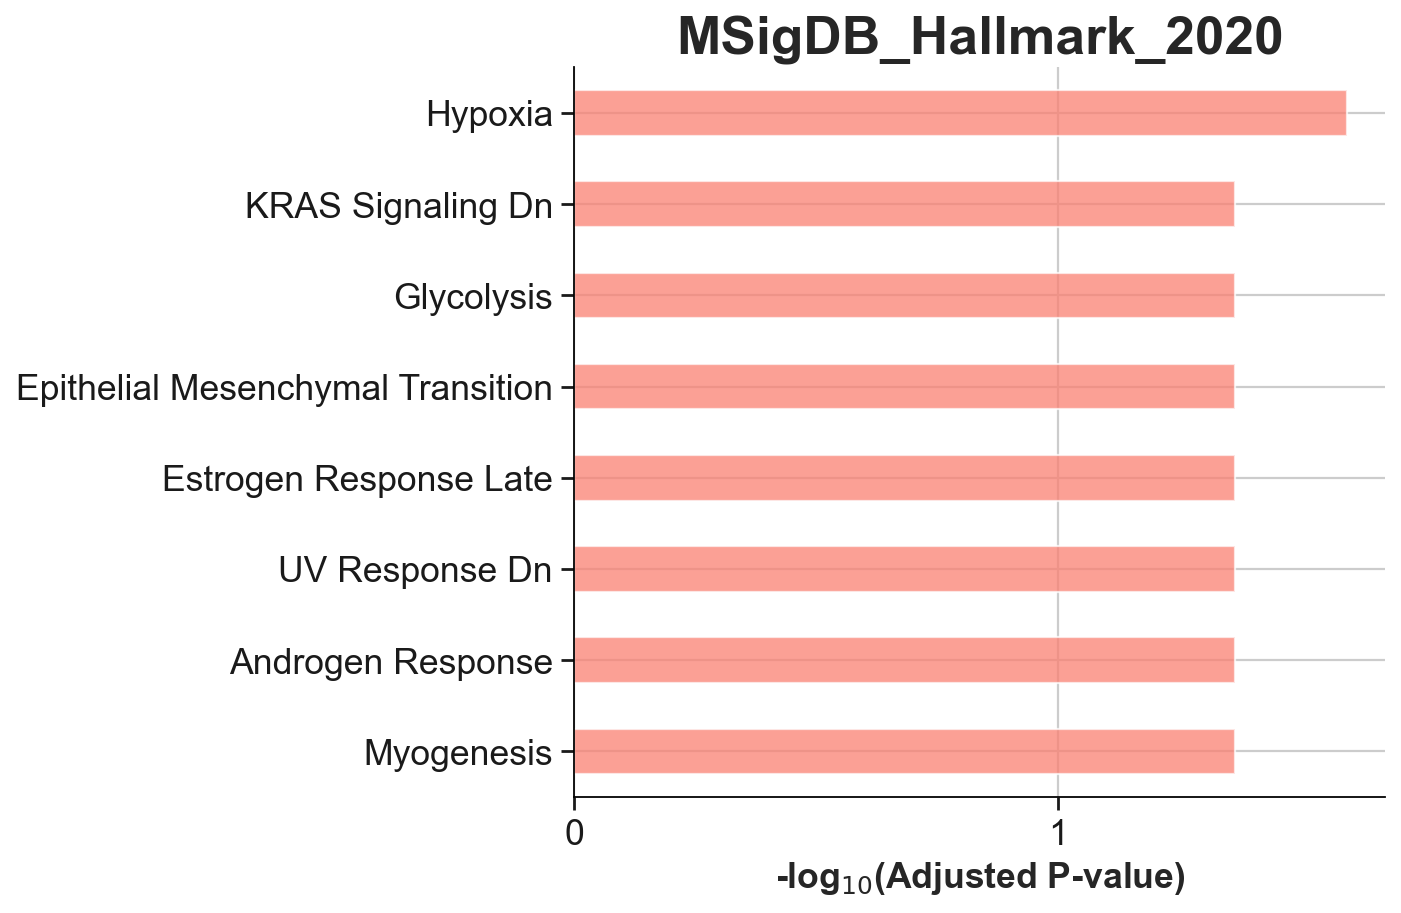

In [175]:
gseapy.barplot(enr_res.res2d,title='MSigDB_Hallmark_2020')

<AxesSubplot:title={'center':'MSigDB_Hallmark_2020'}, xlabel='-log$_{10}$(Adjusted P-value)'>

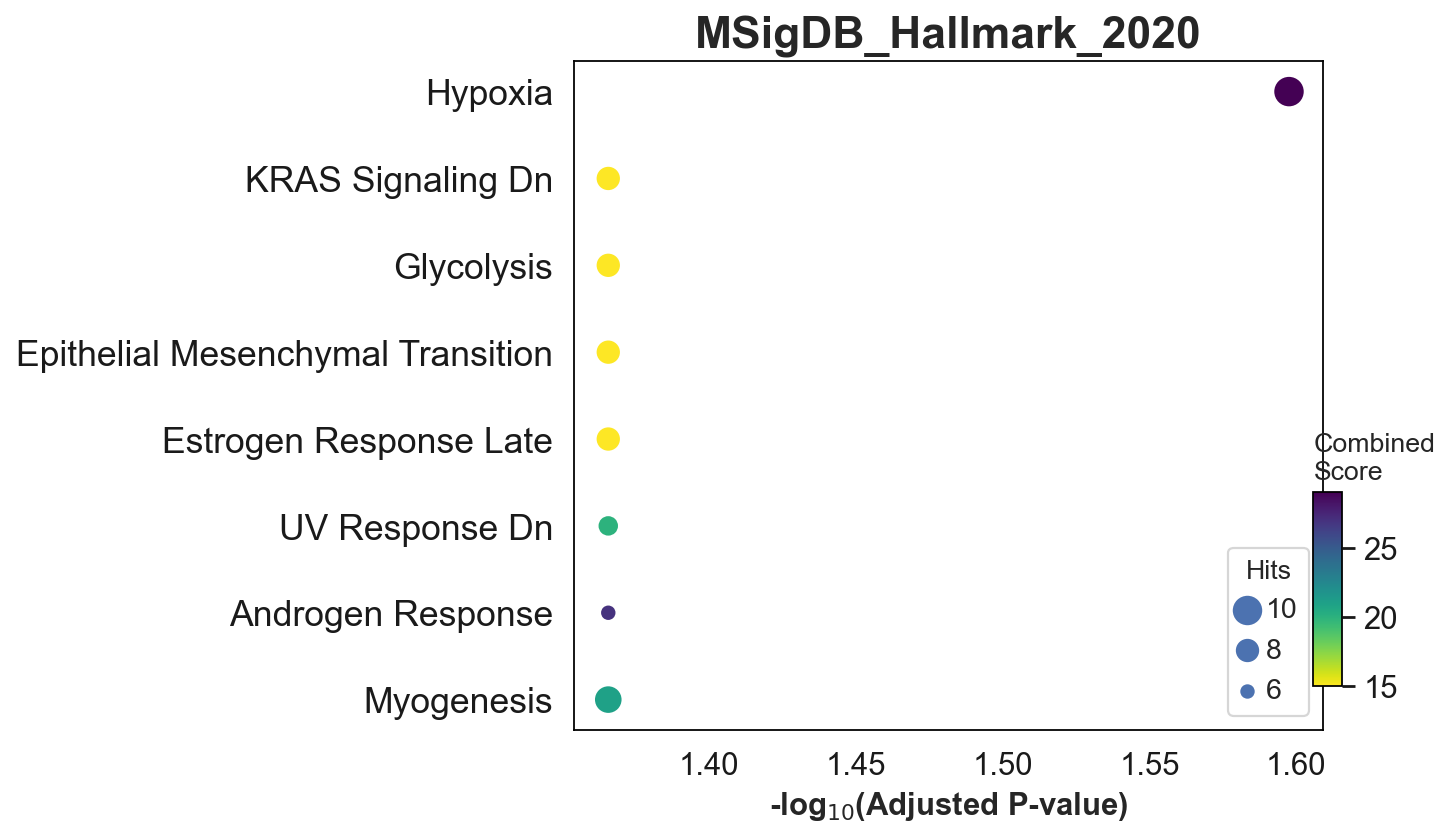

In [174]:
gseapy.dotplot(enr_res.res2d, title='MSigDB_Hallmark_2020',cmap='viridis_r')

### GSEA pre-rank

In [248]:
pval_table_rnk = pval_table[['group_2VE_n','group_2VE_l','group_2VE_p']]

rank_score = pval_table_rnk['group_2VE_l'] * -np.log10(pval_table_rnk['group_2VE_p'])
rank_score
pval_table_rnk['score'] = rank_score

<ipython-input-248-7a84639e6373>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pval_table_rnk['score'] = rank_score


In [254]:
pval_table_rnk = pval_table_rnk.sort_values(by= 'score', ascending=False)
pval_table_rnk = pval_table_rnk[['group_2VE_n', 'score']]
pval_table_rnk.head(15)

group_2VE_n      score
0         MEG3  36.597010
1          CPE  29.334827
3          AGT  19.304500
5       GABBR2  17.432252
8         SGCD  13.961925
2         CST3  13.497513
4        ASIC2  13.352811
6       SORBS1   9.782407
14       EFNA5   9.543876
9        KCNT1   8.684135
11       CCND3   7.508717
21       FKBP5   7.315688
24    ADAMTS20   4.386285
7         APOE   4.376864
26        WNK2   3.977045

In [252]:
pre_res = gseapy.prerank(rnk=pval_table_rnk, 
                     gene_sets='Reactome_2016',
                     processes=4,
                     permutation_num=100, # reduce number to speed up testing
                     outdir='test/prerank_report_kegg', format='png', seed=6)

In [253]:
pre_res.res2d.sort_index().head(n=25).sort_values('pval')

es       nes  \
Term                                                                     
ABC-family proteins mediated transport Homo sap...       NaN       NaN   
Abortive elongation of HIV-1 transcript in the ...       NaN       NaN   
Activation of ATR in response to replication st...       NaN       NaN   
AURKA Activation by TPX2 Homo sapiens R-HSA-885... -0.942555 -1.056915   
APC-Cdc20 mediated degradation of Nek2A Homo sa... -0.947361       NaN   
A tetrasaccharide linker sequence is required f... -0.950072       NaN   
Activated TLR4 signalling Homo sapiens R-HSA-16... -0.929772 -1.073955   
Activated NOTCH1 Transmits Signal to the Nucleu... -0.947497       NaN   
APC/C:Cdc20 mediated degradation of Cyclin B Ho... -0.947365       NaN   
APC/C-mediated degradation of cell cycle protei... -0.925739 -1.056873   
APC:Cdc20 mediated degradation of cell cycle pr... -0.925773 -1.035305   
ATF4 activates genes Homo sapiens R-HSA-380994     -0.938863       NaN   
APC/C:Cdc20 mediated degradation of Securin Hom... -0.925777 -1.045276   
APC/C:Cdc20 mediated degradation of mitotic pro... -0.925769 -1.047356   
ADP signalling through P2Y purinoceptor 1 Homo ... -0.930771       NaN   
APC/C:Cdh1 mediated degradation of Cdc20 and ot... -0.925769 -1.026688   
Activation of APC/C and APC/C:Cdc20 mediated de... -0.925769 -1.013640   
AUF1 (hnRNP D0) binds and destabilizes mRNA Hom... -0.925823 -1.010142   
3' -UTR-mediated translational regulation Homo ... -0.927338       NaN   
ARMS-mediated activation Homo sapiens R-HSA-170984 -0.741196 -0.880002   
Activation of G protein gated Potassium channel...  0.583411       NaN   
Activation of Kainate Receptors upon glutamate ... -0.908783       NaN   
Activation of HOX genes during differentiation ... -0.737566 -0.810446   
Activation of BH3-only proteins Homo sapiens R-... -0.666745       NaN   
Activation of GABAB receptors Homo sapiens R-HS... -0.513788       NaN   

                                                        pval       fdr  \
Term                                                                     
ABC-family proteins mediated transport Homo sap...  0.000000  1.000000   
Abortive elongation of HIV-1 transcript in the ...  0.000000  1.000000   
Activation of ATR in response to replication st...  0.000000  1.000000   
AURKA Activation by TPX2 Homo sapiens R-HSA-885...  0.285714  1.000000   
APC-Cdc20 mediated degradation of Nek2A Homo sa...  0.342105  1.000000   
A tetrasaccharide linker sequence is required f...  0.414634  1.000000   
Activated TLR4 signalling Homo sapiens R-HSA-16...  0.428571  1.000000   
Activated NOTCH1 Transmits Signal to the Nucleu...  0.437500  1.000000   
APC/C:Cdc20 mediated degradation of Cyclin B Ho...  0.506667  1.000000   
APC/C-mediated degradation of cell cycle protei...  0.510638  1.000000   
APC:Cdc20 mediated degradation of cell cycle pr...  0.538462  1.000000   
ATF4 activates genes Homo sapiens R-HSA-380994      0.556962  1.000000   
APC/C:Cdc20 mediated degradation of Securin Hom...  0.563830  1.000000   
APC/C:Cdc20 mediated degradation of mitotic pro...  0.584270  1.000000   
ADP signalling through P2Y purinoceptor 1 Homo ...  0.608108  1.000000   
APC/C:Cdh1 mediated degradation of Cdc20 and ot...  0.625000  1.000000   
Activation of APC/C and APC/C:Cdc20 mediated de...  0.648352  1.000000   
AUF1 (hnRNP D0) binds and destabilizes mRNA Hom...  0.659341  1.000000   
3' -UTR-mediated translational regulation Homo ...  0.729412  1.000000   
ARMS-mediated activation Homo sapiens R-HSA-170984  0.793478  1.000000   
Activation of G protein gated Potassium channel...  0.833333  1.000000   
Activation of Kainate Receptors upon glutamate ...  0.839506  1.000000   
Activation of HOX genes during differentiation ...  0.943820  0.969051   
Activation of BH3-only proteins Homo sapiens R-...  1.000000  1.000000   
Activation of GABAB receptors Homo sapiens R-HS...  1.000000  1.000000   

                                                    geneset_